<div
  style="
    display: flex;
    justify-content: center;
    flex-direction: column;
    align-items: center;
  "
>
<div style="width: 500px; padding: 20px; background: #fff; border: 1px solid #999; color: black; border-radius: 6px">
  <p style="opacity: 0.5; margin-bottom: -10px"><i>TDT4173 Machine Learning 2023</i></p>
  <h1 style="margin-bottom: -5px"><b>Short Notebook 1</b></h1>
  <h3>Kaggle Name: NeuralNet Ninjas™️</h3>
  <br />
  <h3>Team Members:</h3>
  <table style="margin: 0 auto; width: 100%; text-align: left">
    <tr style="background: #eee">
      <th style="border: 0.5px solid #999; color: black">Name</th>
      <th style="border: 0.5px solid #999; color: black">Student ID</th>
    </tr>
    <tr style="background: #fff">
      <td style="border-width: 0.5px; border-color: #555">Eggen, Sivert Antonsen</td>
      <td style="border-width: 0.5px; border-color: #555">54 46 17</td>
    </tr>
    <tr>
      <td style="border-width: 0.5px; border-color: #555">Grude, Kristoffer VI Nicolay Broch</td>
      <td style="border-width: 0.5px; border-color: #555">52 77 63</td>
    </tr>
    <tr>
      <td style="border-width: 0.5px; border-color: #555">Raa, Mathias Skogen</td>
      <td style="border-width: 0.5px; border-color: #555">54 46 38</td>
    </tr>
  </table>
  <br />
  <h3>Runtime: ~3 hours</h3>
  <p style="opacity: 0.5;"><i>Specs: MacBook Pro 2021, Apple M1 Pro Chip, 16 GB RAM</i></p>
  </div>
</div>


---

In [68]:
# Utils
import os

# Data
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_predict, KFold, train_test_split

# Models
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.common import space

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

import scipy.optimize as opt

import fastai
import fastai.tabular as tabular
import fastai.tabular.all as tabular_all

#######################################
# Ray version 2.6.3 must be installed
# in order to train Autogluon within 
# the time limit.
#######################################

# 1 - Preprocessing

### 1.1 - Dataset loading

In [4]:
# Load data

y_data = {}
y_test_data = pd.read_csv(f"../data/test.csv")
X_test_estimated_data = {}
X_train_estimated_data = {}
X_train_observed_data = {}
locations = ["A", "B", "C"]

for location in locations:
    y_data[location] = pd.read_parquet(f"../data/{location}/train_targets.parquet")

    X_test_estimated_data[location] = pd.read_parquet(
        f"../data/{location}/X_test_estimated.parquet"
    )
    X_train_estimated_data[location] = pd.read_parquet(
        f"../data/{location}/X_train_estimated.parquet"
    )
    X_train_observed_data[location] = pd.read_parquet(
        f"../data/{location}/X_train_observed.parquet"
    )

In [5]:
# Combine data

combine_data = (
    lambda data: pd.concat(data.values(), keys=data.keys())
    .reset_index()
    .drop(columns="level_1")
    .rename(columns={"level_0": "location"})
)

y = combine_data(y_data).sort_values(by=["time", "location"])

y_test_data = y_test_data.rename(columns={"prediction": "pv_measurement"})
y_test_data = y_test_data[["time", "location", "pv_measurement"]]

# Add Kaggle test data to y
y = pd.concat([y, y_test_data]).sort_values(by=["time", "location"])
y["time"] = pd.to_datetime(y["time"])

X_train_observed = combine_data(X_train_observed_data).assign(data_type="observed")
X_train_estimated = combine_data(X_train_estimated_data).assign(data_type="estimated")
X_test_estimated = combine_data(X_test_estimated_data).assign(data_type="test")

X = pd.concat([X_train_observed, X_train_estimated, X_test_estimated]).sort_values(
    by=["date_forecast", "location"]
)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (413791, 49)
y shape: (101248, 3)


### 1.2 - Data cleaning

#### 1.2.1 - Resample data to hourly granularity

In [6]:
# Custom aggregation function
def custom_resample(aggregation_dict, default_agg = "mean"): 
    result = {}
    for column in X.columns:
        if column in ["date_forecast"]:
            continue

        aggregation = aggregation_dict.get(column, default_agg)  # Use 'mean' by default

        result[column] = aggregation
    return result

# Specify the aggregation method for specific columns
aggregation_dict = {
    "location": "first",
    "data_type": "first",

    # Categorical weather features
    "is_day:idx": "first",
    "is_in_shadow:idx": "first",
    "precip_type_5min:idx": "first",
    "dew_or_rime:idx": "first",
    "snow_drift:idx": "first",
}

X = (
    X.set_index("date_forecast")
    .groupby("location")
    .resample("H")
    .apply(custom_resample(aggregation_dict))
    .drop(columns=["location"])
    .reset_index()
    .sort_values(by=["date_forecast", "location"])
    .reset_index(drop=True)
)

X_no_resample = (
    X.set_index("date_forecast")
    .groupby("location")
    .resample("H")
    .apply(custom_resample(aggregation_dict, "first"))
    .drop(columns=["location"])
    .reset_index()
    .sort_values(by=["date_forecast", "location"])
    .reset_index(drop=True)
)


#### 1.2.2 - Remove NaN rows

In [7]:
# Find all rows that only contain NaN in X

nan_rows = X[X.drop(columns=["date_forecast", "location"]).isna().all(axis=1)].index

X = X.drop(nan_rows).reset_index(drop=True)
display(X.describe())

# No-resample version
nan_rows = X_no_resample[X_no_resample.drop(columns=["date_forecast", "location"]).isna().all(axis=1)].index

X_no_resample = X_no_resample.drop(nan_rows).reset_index(drop=True)

# Find all rows that only contain NaN in y

nan_rows = y[y.drop(columns=["time", "location"]).isna().all(axis=1)].index

y = y.drop(nan_rows).reset_index(drop=True)
display(y.describe())


date_forecast  absolute_humidity_2m:gm3  \
count                      103450             103450.000000   
mean   2021-02-27 11:19:43.458675                  6.022451   
min           2019-01-01 00:00:00                  0.500000   
25%           2020-02-15 04:00:00                  4.000000   
50%           2021-02-08 08:30:00                  5.450000   
75%           2022-02-02 13:00:00                  7.900000   
max           2023-07-03 23:00:00                 18.700001   
std                           NaN                  2.766933   

       air_density_2m:kgm3  ceiling_height_agl:m  clear_sky_energy_1h:J  \
count        103450.000000          85710.000000           1.034500e+05   
mean              1.255468           2818.218750           5.340856e+05   
min               1.139250             27.600000           0.000000e+00   
25%               1.230000           1063.206177           0.000000e+00   
50%               1.255000           1847.675049           1.444562e+04   
75%               1.279000           3831.431152           8.463045e+05   
max               1.441000          12294.901367           2.990596e+06   
std               0.037343           2490.036865           8.363739e+05   

       clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  \
count    103450.000000      95988.000000    103450.000000   103450.000000   
mean        148.357071       1728.615723         0.002707      275.193604   
min           0.000000         27.299997        -1.000000      247.425003   
25%           0.000000        602.687500         0.000000      270.600006   
50%           2.350000       1170.074951         0.000000      275.000000   
75%         233.250000       2085.399902         0.000000      280.649994   
max         835.650024      11673.724609         1.000000      294.924988   
std         232.910690       1777.656860         0.254857        7.007361   

       diffuse_rad:W  ...  sun_elevation:d  super_cooled_liquid_water:kgm2  \
count  103450.000000  ...    103450.000000                   103450.000000   
mean       40.692169  ...        -0.686007                        0.056825   
min         0.000000  ...       -49.931999                        0.000000   
25%         0.000000  ...       -17.985250                        0.000000   
50%         1.400000  ...        -0.422625                        0.000000   
75%        68.193748  ...        16.086188                        0.100000   
max       334.750000  ...        49.943748                        1.375000   
std        61.679428  ...        24.151178                        0.105950   

         t_1000hPa:K  total_cloud_cover:p   visibility:m  wind_speed_10m:ms  \
count  103450.000000        103450.000000  103450.000000      103450.000000   
mean      279.437866            73.615753   33047.601562           3.017211   
min       258.024994             0.000000     132.375000           0.025000   
25%       274.799988            52.900002   17214.430664           1.675000   
50%       278.700012            93.025002   36858.449219           2.675000   
75%       284.093758            99.925003   48121.931641           4.025000   
max       303.250000           100.000000   75489.328125          13.275000   
std         6.689478            34.071289   17768.177734           1.743098   

       wind_speed_u_10m:ms  wind_speed_v_10m:ms  wind_speed_w_1000hPa:ms  \
count        103450.000000        103450.000000            103450.000000   
mean              0.677701             0.670877                 0.000048   
min              -7.225000            -8.400000                -0.100000   
25%              -1.325000            -0.600000                 0.000000   
50%               0.325000             0.700000                 0.000000   
75%               2.500000             1.850000                 0.000000   
max              11.200000             8.825000                 0.100000   
std               2.773586             1.871724            

time  pv_measurement
count                          95184    95184.000000
mean   2021-03-24 10:51:46.807866880      280.506347
min              2018-12-31 23:00:00       -0.000000
25%              2020-04-08 15:45:00        0.000000
50%              2021-03-05 05:30:00        0.000000
75%              2022-01-29 20:00:00      161.287500
max              2023-07-03 23:00:00     5733.420000
std                              NaN      758.866540

#### 1.2.3 - Remove outliers

In [8]:
# Remove repeated values

def find_repeated_indexes(df, column_name, repeat_count=12, ignore_zeros=True) -> list:
    """
    Find and return the indexes of rows with a specified number of repeated values in a given column.

    Parameters:
    - df: DataFrame to search for repeated rows.
    - column_name: Name of the column to check for repeated values.
    - repeat_count: Number of repeated values required to consider a row as a match.

    Returns:
    - List of indexes for rows with the specified number of repeated values in the given column.
    """
    repeated_indexes = []
    temp_repeated_indexes = []
    current_value = None

    for index, row in df.iterrows():
        value = row[column_name]

        if value == 0 and ignore_zeros:
            continue

        if value == current_value:
            temp_repeated_indexes.append(index)
        else:
            current_value = value
            if len(temp_repeated_indexes) <= repeat_count:
                temp_repeated_indexes.clear()
            else:
                repeated_indexes.extend(
                    set(temp_repeated_indexes) - set(repeated_indexes)
                )
                temp_repeated_indexes.clear()

    return repeated_indexes

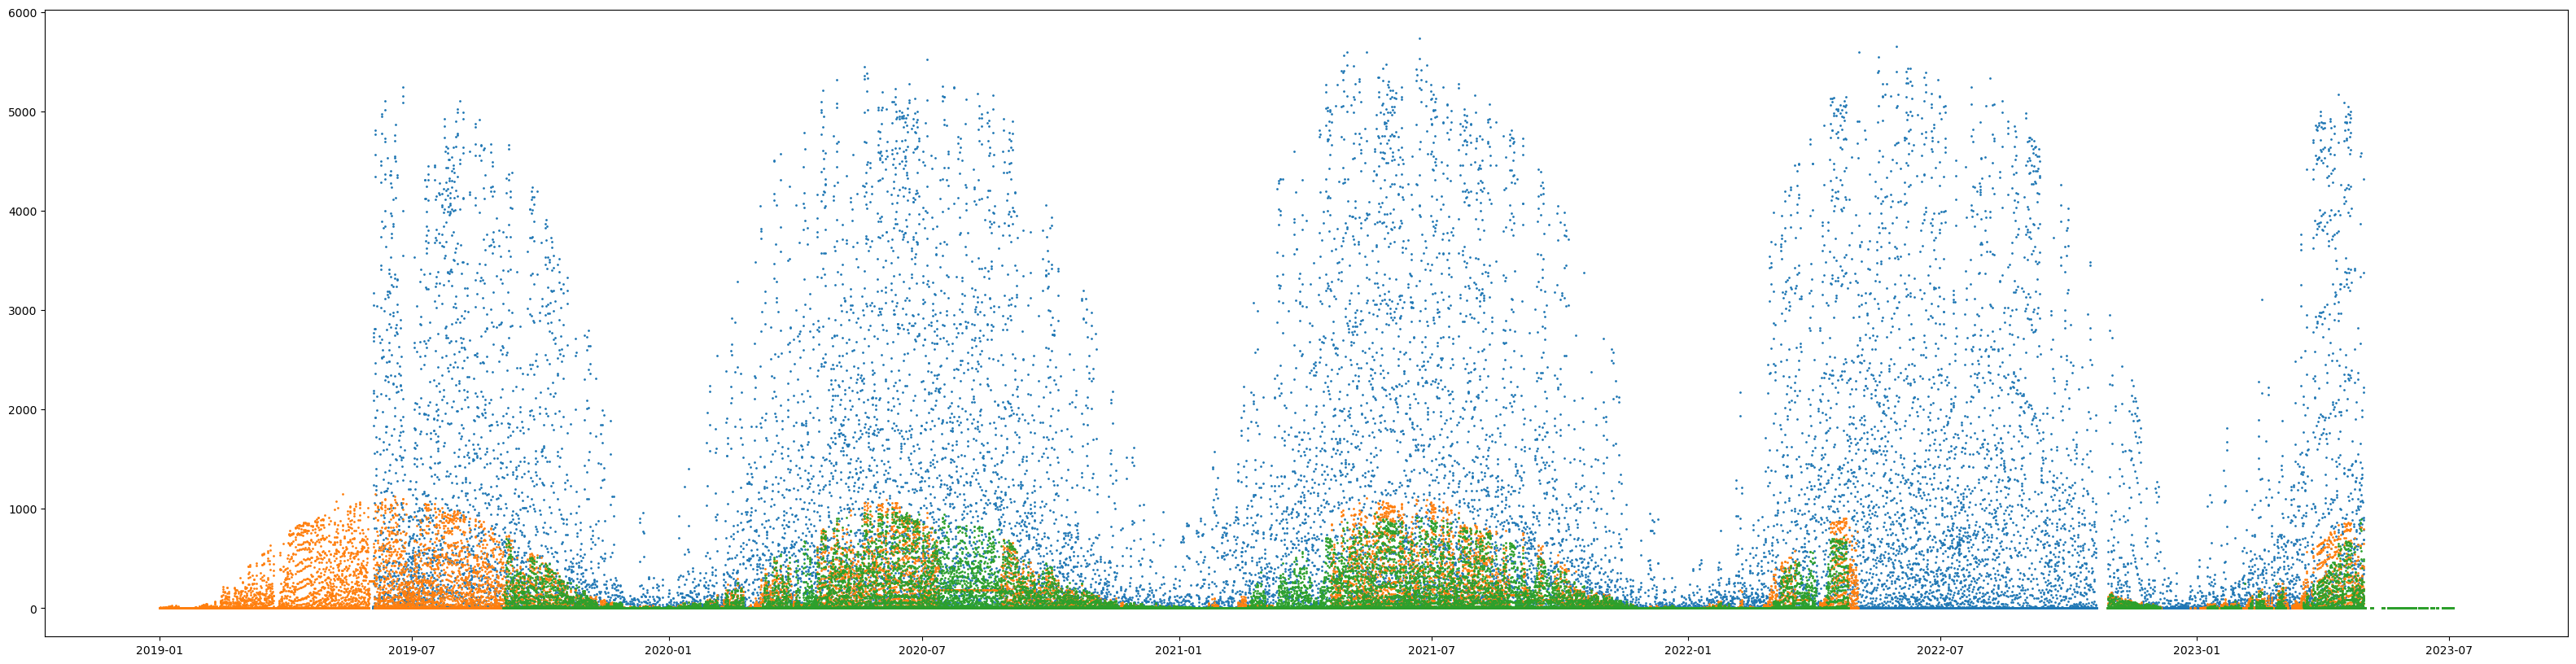

In [9]:
# Visulize data per location
plt.figure(figsize=(40, 10))

for location in locations:
    plt.scatter(y[y.location == location].time, y[y.location == location]["pv_measurement"], s=1)

### 1.3 - Combine X and y

#### 1.3.1 Create no-resample preprocessing data

In [10]:
# Remove repeated values (Version 1)

# Create a copy of X and y
y_no_resample = y.copy()

for location in locations:
    # Drop rows with repeated values over 24 hours
    repeated_indexes = find_repeated_indexes(
        y_no_resample[y_no_resample.location == location].sort_values(by=["location", "time"]),
        "pv_measurement",
        repeat_count=24,
        ignore_zeros=True,
    )

    y_no_resample = y_no_resample.drop(repeated_indexes).reset_index(drop=True)

    # Drop rows with repeated zeros over 4 days,
    # ignore dates after '2023-05-01 00:00:00' as they are test data

    repeated_indexes = find_repeated_indexes(
        y_no_resample[(y_no_resample.location == location) & (y_no_resample.time <= "2023-05-01 00:00:00")].sort_values(
            by=["location", "time"]
        ),
        "pv_measurement",
        repeat_count=72,
        ignore_zeros=False,
    )

    y_no_resample = y_no_resample.drop(repeated_indexes).reset_index(drop=True)

In [11]:
# Combine X and y on date_forecast and location. Drop rows where a row does not exist in both X and y.

data_no_resample = pd.merge(
    X_no_resample, y_no_resample, left_on=["date_forecast", "location"], right_on=["time", "location"]
).drop(columns=["time"])

#### 1.3.1 Create standard preprocessing data

In [12]:
# Remove repeated values (Version 1)

# Create a copy of X and y
X_standard = X.copy()
y_standard = y.copy()

for location in locations:
    # Drop rows with repeated values over 24 hours
    repeated_indexes = find_repeated_indexes(
        y_standard[y_standard.location == location].sort_values(by=["location", "time"]),
        "pv_measurement",
        repeat_count=24,
        ignore_zeros=True,
    )

    y_standard = y_standard.drop(repeated_indexes).reset_index(drop=True)

    # Drop rows with repeated zeros over 4 days,
    # ignore dates after '2023-05-01 00:00:00' as they are test data

    repeated_indexes = find_repeated_indexes(
        y_standard[(y_standard.location == location) & (y_standard.time <= "2023-05-01 00:00:00")].sort_values(
            by=["location", "time"]
        ),
        "pv_measurement",
        repeat_count=72,
        ignore_zeros=False,
    )

    y_standard = y_standard.drop(repeated_indexes).reset_index(drop=True)

In [13]:
# Combine X and y on date_forecast and location. Drop rows where a row does not exist in both X and y.

data_standard = pd.merge(
    X_standard, y_standard, left_on=["date_forecast", "location"], right_on=["time", "location"]
).drop(columns=["time"])

#### 1.3.2 Create simple preprocessing data 

In [14]:
# Remove repeated values (Version 2)

# Create a copy of X and y
X_simple = X.copy()
y_simple = y.copy()

for location in locations:
    # Drop rows with repeated values over 24 hours
    repeated_indexes = find_repeated_indexes(
        y_simple[y_simple.location == location].sort_values(by=["location", "time"]),
        "pv_measurement",
        repeat_count=48,
        ignore_zeros=True,
    )

    y_simple = y_simple.drop(repeated_indexes).reset_index(drop=True)

In [15]:
# Combine X and y on date_forecast and location. Drop rows where a row does not exist in both X and y.

data_simple = pd.merge(
    X_simple, y_simple, left_on=["date_forecast", "location"], right_on=["time", "location"]
).drop(columns=["time"])

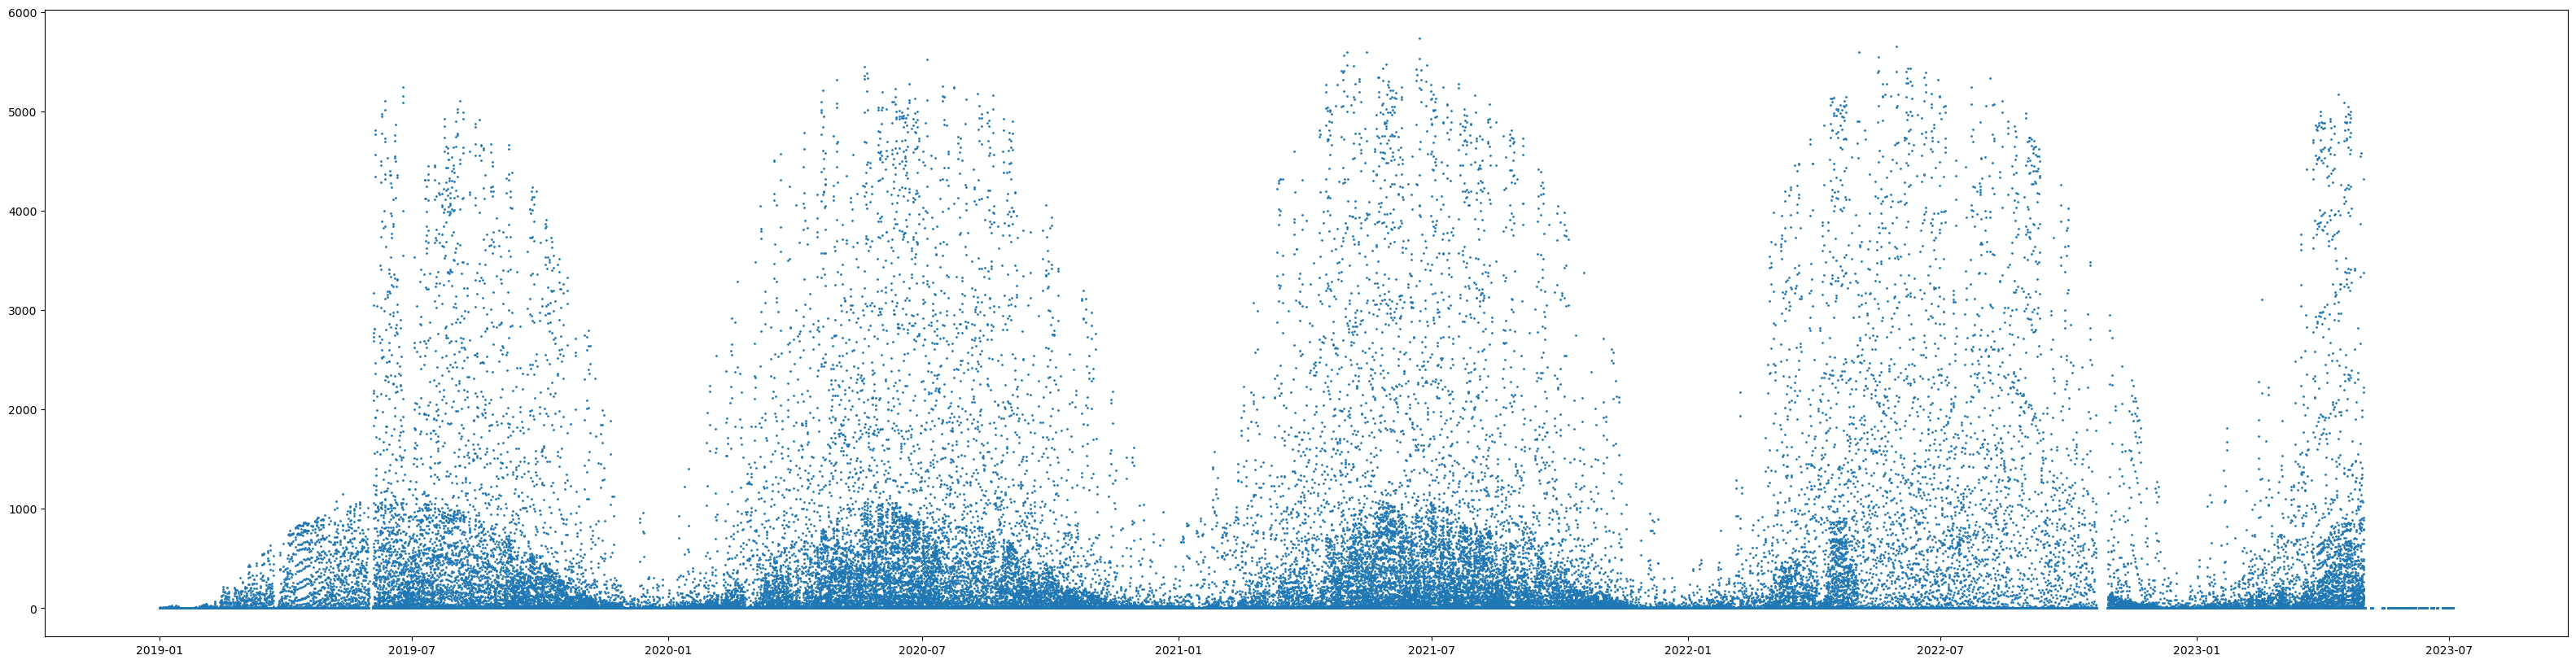

In [16]:
plt.figure(figsize=(40, 10))
plt.scatter(data_simple.date_forecast, data_simple["pv_measurement"], s=1)

### 1.4 - Feature Engineering

#### 1.4.1 - Add sinus and cosinus features

In [17]:
# Function that sinus and cosinus transform a column

def add_sin_cos(df, column_name, period):
    """
    Add sinus and cosinus transformed columns for the given column.

    Parameters:
    - df: DataFrame to add the transformed columns to.
    - column_name: Name of the column to transform.
    - period: Period of the sinus and cosinus functions.
    """
    df[f"{column_name}_sin"] = np.sin(2 * np.pi * df[column_name] / period)
    df[f"{column_name}_cos"] = np.cos(2 * np.pi * df[column_name] / period)


In [18]:
# Add sinus and cosinus transformed columns for time for data_standard

data_standard["hour"] = data_standard["date_forecast"].dt.hour
data_standard["month"] = data_standard["date_forecast"].dt.month

add_sin_cos(data_standard, "hour", 23)
add_sin_cos(data_standard, "month", 12)

In [19]:
# Add sinus and cosinus transformed columns for time for data_simple

data_simple["hour"] = data_simple["date_forecast"].dt.hour
data_simple["month"] = data_simple["date_forecast"].dt.month

add_sin_cos(data_simple, "hour", 23)
add_sin_cos(data_simple, "month", 12)

In [20]:
# Add sinus and cosinus transformed columns for time for data_no_resample

data_no_resample["hour"] = data_no_resample["date_forecast"].dt.hour
data_no_resample["month"] = data_no_resample["date_forecast"].dt.month

add_sin_cos(data_no_resample, "hour", 23)
add_sin_cos(data_no_resample, "month", 12)

#### 1.4.2 - Transform sun_azimuth feature

In [21]:
# Sun azimuth feature engineering

def convert_from_degree_to_ciruclar(df, feature):
    """
    Converts a feature from degree to circular
    """
    df[feature + "_sin"] = np.sin(np.radians(df[feature]))
    df[feature + "_cos"] = np.cos(np.radians(df[feature]))

    return df

In [22]:
# Convert sun_azimuth from degree to circular for data_standard
data_standard = convert_from_degree_to_ciruclar(data_standard, "sun_azimuth:d")

In [23]:
# Convert sun_azimuth from degree to circular for data_standard
data_simple = convert_from_degree_to_ciruclar(data_simple, "sun_azimuth:d")

In [24]:
# Convert sun_azimuth from degree to circular for data_standard
data_no_resample = convert_from_degree_to_ciruclar(data_no_resample, "sun_azimuth:d")

### 1.5 - Result

In [25]:
data_standard.describe().T.drop(columns=["std", "25%", "50%", "75%"])

count                        mean  \
date_forecast                     85205  2021-03-27 13:59:56.155155   
absolute_humidity_2m:gm3        85205.0                    6.214849   
air_density_2m:kgm3             85205.0                    1.252912   
ceiling_height_agl:m            69963.0                 2903.989258   
clear_sky_energy_1h:J           85205.0                  553656.875   
clear_sky_rad:W                 85205.0                  153.780457   
cloud_base_agl:m                78892.0                 1748.616577   
dew_or_rime:idx                 85205.0                    0.015879   
dew_point_2m:K                  85205.0                  275.824036   
diffuse_rad:W                   85205.0                   41.908321   
diffuse_rad_1h:J                85205.0                150879.96875   
direct_rad:W                    85205.0                   54.301579   
direct_rad_1h:J                 85205.0                195499.15625   
effective_cloud_cover:p         85205.0                   66.873695   
elevation:m                     85205.0                   11.100123   
fresh_snow_12h:cm               85205.0                    0.092189   
fresh_snow_1h:cm                85205.0                     0.00765   
fresh_snow_24h:cm               85205.0                    0.182312   
fresh_snow_3h:cm                85205.0                    0.022987   
fresh_snow_6h:cm                85205.0                    0.046025   
is_day:idx                      85205.0                     0.50233   
is_in_shadow:idx                85205.0                    0.545203   
msl_pressure:hPa                85205.0                 1009.967468   
precip_5min:mm                  85205.0                    0.005691   
precip_type_5min:idx            85205.0                    0.076944   
pressure_100m:hPa               85205.0                  996.340759   
pressure_50m:hPa                85205.0                 1002.460632   
prob_rime:p                     85205.0                    0.591769   
rain_water:kgm2                 85205.0                    0.009961   
relative_humidity_1000hPa:p     85205.0                   73.533554   
sfc_pressure:hPa                85205.0                 1008.607544   
snow_density:kgm3                2512.0                       250.0   
snow_depth:cm                   85205.0                    0.114916   
snow_drift:idx                  85205.0                    0.000023   
snow_melt_10min:mm              85205.0                    0.000208   
snow_water:kgm2                 85205.0                    0.088535   
sun_azimuth:d                   85205.0                  179.642044   
sun_elevation:d                 85205.0                    0.068016   
super_cooled_liquid_water:kgm2  85205.0                    0.057439   
t_1000hPa:K                     85205.0                  279.956207   
total_cloud_cover:p             85205.0                   73.569359   
visibility:m                    85205.0                32871.074219   
wind_speed_10m:ms               85205.0                    3.026494   
wind_speed_u_10m:ms             85205.0                    0.676903   
wind_speed_v_10m:ms             85205.0                    0.620215   
wind_speed_w_1000hPa:ms         85205.0                    0.000042   
date_calc                         13085  2023-02-20 17:57:39.905999   
pv_measurement                  85205.0                  308.626345   
hour                            85205.0                    11.50274   
month                           85205.0                    6.404307   
hour_sin                        85205.0                   -0.000119   
hour_cos                        85205.0                        0.04   
month_sin                       85205.0                    0.031021   
month_cos                       85205.0                     0.00923   
sun_azimuth:d_sin               85205.0                    0.012768   
sun_azimuth:d_cos               85205.0                   

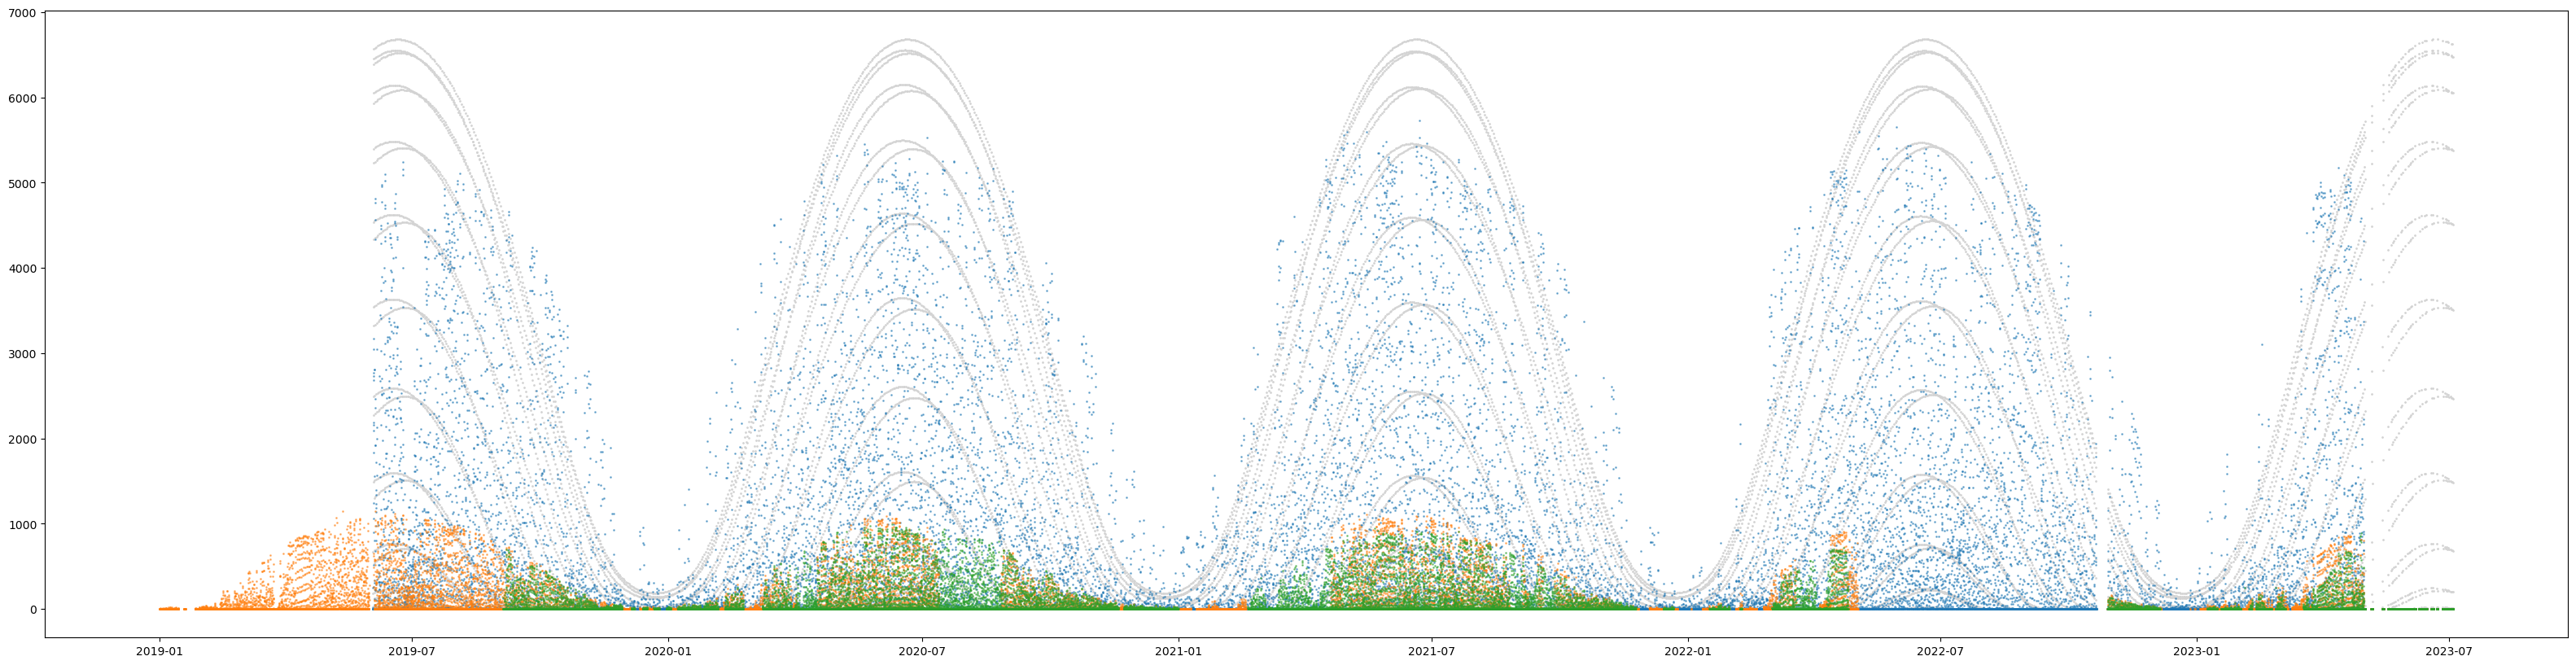

In [26]:
# Plot alignment and values
plt.figure(figsize=(40, 10))

plt.scatter(
    data_standard[data_standard.location == "A"].date_forecast,
    data_standard[data_standard.location == "A"]["clear_sky_rad:W"] * 8,
    s=1,
    color="lightgrey",
)

for loc in locations:
    plt.scatter(
        data_standard[data_standard.location == loc].date_forecast,
        data_standard[data_standard.location == loc]["pv_measurement"],
        s=1,
        alpha=0.5,
    )

In [27]:
data_simple.describe().T.drop(columns=["std", "25%", "50%", "75%"])

count                        mean  \
date_forecast                     92117  2021-03-26 19:47:34.417751   
absolute_humidity_2m:gm3        92117.0                     6.00584   
air_density_2m:kgm3             92117.0                    1.255348   
ceiling_height_agl:m            75668.0                 2880.849121   
clear_sky_energy_1h:J           92117.0                523999.90625   
clear_sky_rad:W                 92117.0                  145.547226   
cloud_base_agl:m                85300.0                 1740.147217   
dew_or_rime:idx                 92117.0                    0.007447   
dew_point_2m:K                  92117.0                  275.219177   
diffuse_rad:W                   92117.0                    39.95409   
diffuse_rad_1h:J                92117.0                  143842.375   
direct_rad:W                    92117.0                   51.247185   
direct_rad_1h:J                 92117.0                 184493.9375   
effective_cloud_cover:p         92117.0                   66.931633   
elevation:m                     92117.0                   11.566648   
fresh_snow_12h:cm               92117.0                    0.118093   
fresh_snow_1h:cm                92117.0                    0.009816   
fresh_snow_24h:cm               92117.0                    0.233314   
fresh_snow_3h:cm                92117.0                    0.029502   
fresh_snow_6h:cm                92117.0                    0.059037   
is_day:idx                      92117.0                    0.486664   
is_in_shadow:idx                92117.0                    0.562567   
msl_pressure:hPa                92117.0                  1009.52356   
precip_5min:mm                  92117.0                    0.005672   
precip_type_5min:idx            92117.0                    0.083882   
pressure_100m:hPa               92117.0                  995.811951   
pressure_50m:hPa                92117.0                 1001.942383   
prob_rime:p                     92117.0                    0.752863   
rain_water:kgm2                 92117.0                    0.009387   
relative_humidity_1000hPa:p     92117.0                   73.522812   
sfc_pressure:hPa                92117.0                 1008.100159   
snow_density:kgm3                4206.0                       250.0   
snow_depth:cm                   92117.0                    0.194885   
snow_drift:idx                  92117.0                    0.000022   
snow_melt_10min:mm              92117.0                    0.000276   
snow_water:kgm2                 92117.0                    0.089012   
sun_azimuth:d                   92117.0                  179.651199   
sun_elevation:d                 92117.0                   -0.999806   
super_cooled_liquid_water:kgm2  92117.0                    0.056464   
t_1000hPa:K                     92117.0                   279.44281   
total_cloud_cover:p             92117.0                   73.510788   
visibility:m                    92117.0                33197.234375   
wind_speed_10m:ms               92117.0                    3.031902   
wind_speed_u_10m:ms             92117.0                     0.65842   
wind_speed_v_10m:ms             92117.0                    0.680368   
wind_speed_w_1000hPa:ms         92117.0                         0.0   
date_calc                         13085  2023-02-20 17:57:39.905999   
pv_measurement                  92117.0                   285.60086   
hour                            92117.0                   11.503349   
month                           92117.0                    6.284638   
hour_sin                        92117.0                   -0.000222   
hour_cos                        92117.0                    0.041075   
month_sin                       92117.0                    0.065891   
month_cos                       92117.0                     0.05217   
sun_azimuth:d_sin               92117.0                    0.011757   
sun_azimuth:d_cos               92117.0                   

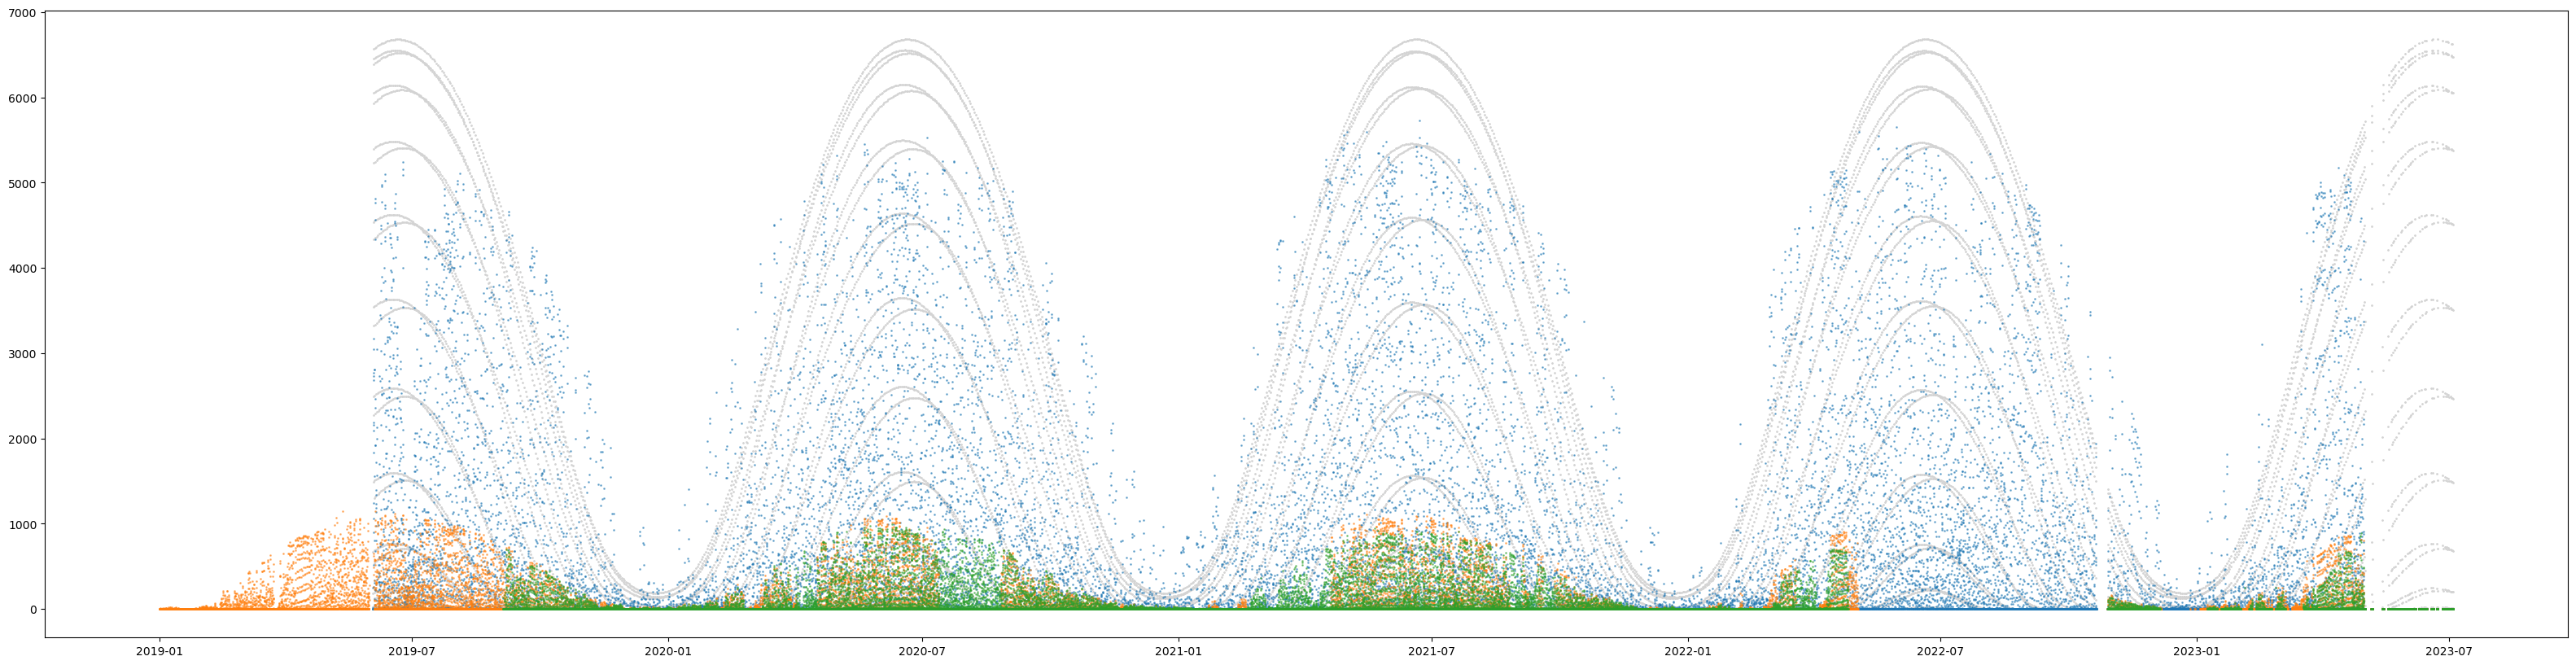

In [28]:
# Plot alignment and values
plt.figure(figsize=(40, 10))

plt.scatter(
    data_simple[data_simple.location == "A"].date_forecast,
    data_simple[data_simple.location == "A"]["clear_sky_rad:W"] * 8,
    s=1,
    color="lightgrey",
)

for loc in locations:
    plt.scatter(
        data_simple[data_simple.location == loc].date_forecast,
        data_simple[data_simple.location == loc]["pv_measurement"],
        s=1,
        alpha=0.5,
    )

# 2 – Modeling

**Model Stack**
1. Target Encoded Catboost
2. Simple LightGBM
3. Target Log Transform Catboost
4. Location Specific Catboost
5. Location Specific AutoGluon
6. Location Specific FastAI Neural Network

<div>
<svg width="1200" height="813" viewBox="0 0 1705 813" fill="none" xmlns="http://www.w3.org/2000/svg">
<rect width="1705" height="813" fill="white"/>
<rect x="632" y="49" width="368" height="80" rx="6" fill="#FFA629"/>
<path d="M678.905 80.5455V98H675.717L668.124 87.0142H667.996V98H664.305V80.5455H667.544L675.078 91.5227H675.232V80.5455H678.905ZM687.396 98.2557C686.049 98.2557 684.89 97.983 683.918 97.4375C682.952 96.8864 682.208 96.108 681.685 95.1023C681.163 94.0909 680.901 92.8949 680.901 91.5142C680.901 90.1676 681.163 88.9858 681.685 87.9688C682.208 86.9517 682.944 86.1591 683.893 85.5909C684.847 85.0227 685.967 84.7386 687.251 84.7386C688.114 84.7386 688.918 84.8778 689.663 85.1562C690.413 85.429 691.066 85.8409 691.623 86.392C692.185 86.9432 692.623 87.6364 692.935 88.4716C693.248 89.3011 693.404 90.2727 693.404 91.3864V92.3835H682.35V90.1335H689.987C689.987 89.6108 689.873 89.1477 689.646 88.7443C689.418 88.3409 689.103 88.0256 688.7 87.7983C688.302 87.5653 687.839 87.4489 687.31 87.4489C686.759 87.4489 686.271 87.5767 685.844 87.8324C685.424 88.0824 685.094 88.4205 684.856 88.8466C684.617 89.267 684.495 89.7358 684.489 90.2528V92.392C684.489 93.0398 684.609 93.5994 684.847 94.071C685.092 94.5426 685.435 94.9062 685.879 95.1619C686.322 95.4176 686.847 95.5455 687.455 95.5455C687.859 95.5455 688.228 95.4886 688.563 95.375C688.898 95.2614 689.185 95.0909 689.424 94.8636C689.663 94.6364 689.844 94.358 689.969 94.0284L693.327 94.25C693.157 95.0568 692.808 95.7614 692.279 96.3636C691.756 96.9602 691.08 97.4261 690.251 97.7614C689.427 98.0909 688.475 98.2557 687.396 98.2557ZM703.712 92.4261V84.9091H707.343V98H703.857V95.6222H703.721C703.425 96.3892 702.934 97.0057 702.246 97.4716C701.565 97.9375 700.732 98.1705 699.749 98.1705C698.874 98.1705 698.104 97.9716 697.44 97.5739C696.775 97.1761 696.255 96.6108 695.88 95.8778C695.511 95.1449 695.323 94.267 695.317 93.2443V84.9091H698.948V92.5966C698.954 93.3693 699.161 93.9801 699.57 94.429C699.979 94.8778 700.528 95.1023 701.215 95.1023C701.653 95.1023 702.062 95.0028 702.442 94.804C702.823 94.5994 703.13 94.2983 703.363 93.9006C703.602 93.5028 703.718 93.0114 703.712 92.4261ZM709.791 98V84.9091H713.311V87.1932H713.447C713.686 86.3807 714.087 85.767 714.649 85.3523C715.212 84.9318 715.859 84.7216 716.592 84.7216C716.774 84.7216 716.97 84.733 717.18 84.7557C717.391 84.7784 717.575 84.8097 717.734 84.8494V88.071C717.564 88.0199 717.328 87.9744 717.027 87.9347C716.726 87.8949 716.45 87.875 716.2 87.875C715.666 87.875 715.189 87.9915 714.768 88.2244C714.354 88.4517 714.024 88.7699 713.78 89.179C713.541 89.5881 713.422 90.0597 713.422 90.5938V98H709.791ZM722.513 98.2472C721.678 98.2472 720.934 98.1023 720.28 97.8125C719.627 97.517 719.11 97.0824 718.729 96.5085C718.354 95.929 718.167 95.2074 718.167 94.3438C718.167 93.6165 718.3 93.0057 718.567 92.5114C718.834 92.017 719.198 91.6193 719.658 91.3182C720.119 91.017 720.641 90.7898 721.226 90.6364C721.817 90.483 722.437 90.375 723.084 90.3125C723.846 90.233 724.459 90.1591 724.925 90.0909C725.391 90.017 725.729 89.9091 725.94 89.767C726.15 89.625 726.255 89.4148 726.255 89.1364V89.0852C726.255 88.5455 726.084 88.1278 725.744 87.8324C725.408 87.5369 724.931 87.3892 724.312 87.3892C723.658 87.3892 723.138 87.5341 722.752 87.8239C722.366 88.108 722.11 88.4659 721.985 88.8977L718.627 88.625C718.797 87.8295 719.133 87.142 719.633 86.5625C720.133 85.9773 720.778 85.5284 721.567 85.2159C722.363 84.8977 723.283 84.7386 724.329 84.7386C725.056 84.7386 725.752 84.8239 726.417 84.9943C727.087 85.1648 727.681 85.429 728.198 85.7869C728.721 86.1449 729.133 86.6051 729.434 87.1676C729.735 87.7244 729.886 88.392 729.886 89.1705V98H726.442V96.1847H726.34C726.13 96.5938 725.849 96.9545 725.496 97.267C725.144 97.5739 724.721 97.8153 724.226 97.9915C723.732 98.1619 723.161 98.2472 722.513 98.2472ZM723.553 95.7415C724.087 95.7415 724.559 95.6364 724.968 95.4261C725.377 95.2102 725.698 94.9205 725.931 94.5568C726.164 94.1932 726.28 93.7812 726.28 93.321V91.9318C726.167 92.0057 726.011 92.0739 725.812 92.1364C725.619 92.1932 725.4 92.2472 725.155 92.2983C724.911 92.3437 724.667 92.3864 724.422 92.4261C724.178 92.4602 723.957 92.4915 723.758 92.5199C723.332 92.5824 722.959 92.6818 722.641 92.8182C722.323 92.9545 722.076 93.1392 721.9 93.3722C721.724 93.5994 721.636 93.8835 721.636 94.2244C721.636 94.7188 721.815 95.0966 722.172 95.358C722.536 95.6136 722.996 95.7415 723.553 95.7415ZM735.877 80.5455V98H732.246V80.5455H735.877ZM752.997 80.5455V98H749.81L742.216 87.0142H742.088V98H738.398V80.5455H741.636L749.17 91.5227H749.324V80.5455H752.997ZM761.488 98.2557C760.141 98.2557 758.982 97.983 758.01 97.4375C757.045 96.8864 756.3 96.108 755.778 95.1023C755.255 94.0909 754.993 92.8949 754.993 91.5142C754.993 90.1676 755.255 88.9858 755.778 87.9688C756.3 86.9517 757.036 86.1591 757.985 85.5909C758.939 85.0227 760.059 84.7386 761.343 84.7386C762.206 84.7386 763.01 84.8778 763.755 85.1562C764.505 85.429 765.158 85.8409 765.715 86.392C766.278 86.9432 766.715 87.6364 767.028 88.4716C767.34 89.3011 767.496 90.2727 767.496 91.3864V92.3835H756.442V90.1335H764.079C764.079 89.6108 763.965 89.1477 763.738 88.7443C763.51 88.3409 763.195 88.0256 762.792 87.7983C762.394 87.5653 761.931 87.4489 761.403 87.4489C760.851 87.4489 760.363 87.5767 759.937 87.8324C759.516 88.0824 759.187 88.4205 758.948 88.8466C758.709 89.267 758.587 89.7358 758.581 90.2528V92.392C758.581 93.0398 758.701 93.5994 758.939 94.071C759.184 94.5426 759.528 94.9062 759.971 95.1619C760.414 95.4176 760.939 95.5455 761.547 95.5455C761.951 95.5455 762.32 95.4886 762.655 95.375C762.991 95.2614 763.278 95.0909 763.516 94.8636C763.755 94.6364 763.937 94.358 764.062 94.0284L767.42 94.25C767.249 95.0568 766.9 95.7614 766.371 96.3636C765.849 96.9602 765.172 97.4261 764.343 97.7614C763.519 98.0909 762.567 98.2557 761.488 98.2557ZM776.373 84.9091V87.6364H768.489V84.9091H776.373ZM770.279 81.7727H773.91V93.9773C773.91 94.3125 773.961 94.5739 774.063 94.7614C774.165 94.9432 774.307 95.071 774.489 95.1449C774.677 95.2187 774.893 95.2557 775.137 95.2557C775.307 95.2557 775.478 95.2415 775.648 95.2131C775.819 95.179 775.949 95.1534 776.04 95.1364L776.611 97.8381C776.429 97.8949 776.174 97.9602 775.844 98.0341C775.515 98.1136 775.114 98.1619 774.643 98.179C773.768 98.2131 773 98.0966 772.341 97.8295C771.688 97.5625 771.179 97.1477 770.816 96.5852C770.452 96.0227 770.273 95.3125 770.279 94.4545V81.7727ZM798.048 80.5455V98H794.861L787.267 87.0142H787.139V98H783.449V80.5455H786.687L794.221 91.5227H794.375V80.5455H798.048ZM800.573 98V84.9091H804.204V98H800.573ZM802.397 83.2216C801.857 83.2216 801.394 83.0426 801.007 82.6847C800.627 82.321 800.436 81.8864 800.436 81.3807C800.436 80.8807 800.627 80.4517 801.007 80.0938C801.394 79.7301 801.857 79.5483 802.397 79.5483C802.936 79.5483 803.397 79.7301 803.777 80.0938C804.164 80.4517 804.357 80.8807 804.357 81.3807C804.357 81.8864 804.164 82.321 803.777 82.6847C803.397 83.0426 802.936 83.2216 802.397 83.2216ZM810.287 90.4318V98H806.656V84.9091H810.116V87.2188H810.27C810.559 86.4574 811.045 85.8551 811.727 85.4119C812.409 84.9631 813.235 84.7386 814.207 84.7386C815.116 84.7386 815.909 84.9375 816.585 85.3352C817.261 85.733 817.787 86.3011 818.162 87.0398C818.537 87.7727 818.724 88.6477 818.724 89.6648V98H815.093V90.3125C815.099 89.5114 814.895 88.8864 814.48 88.4375C814.065 87.983 813.494 87.7557 812.767 87.7557C812.278 87.7557 811.846 87.8608 811.471 88.071C811.102 88.2812 810.812 88.5881 810.602 88.9915C810.397 89.3892 810.292 89.8693 810.287 90.4318ZM821.13 84.9091H824.76V98.6477C824.76 99.6591 824.561 100.477 824.164 101.102C823.766 101.727 823.195 102.185 822.451 102.474C821.712 102.764 820.828 102.909 819.8 102.909C819.675 102.909 819.556 102.906 819.442 102.901C819.323 102.901 819.198 102.898 819.067 102.892V100.054C819.164 100.06 819.249 100.062 819.323 100.062C819.391 100.068 819.465 100.071 819.544 100.071C820.13 100.071 820.539 99.946 820.772 99.696C821.01 99.4517 821.13 99.0824 821.13 98.5881V84.9091ZM822.936 83.2216C822.402 83.2216 821.942 83.0426 821.556 82.6847C821.169 82.321 820.976 81.8864 820.976 81.3807C820.976 80.8807 821.169 80.4517 821.556 80.0938C821.942 79.7301 822.402 79.5483 822.936 79.5483C823.482 79.5483 823.945 79.7301 824.326 80.0938C824.712 80.4517 824.905 80.8807 824.905 81.3807C824.905 81.8864 824.712 82.321 824.326 82.6847C823.945 83.0426 823.482 83.2216 822.936 83.2216ZM830.946 98.2472C830.11 98.2472 829.366 98.1023 828.713 97.8125C828.059 97.517 827.542 97.0824 827.162 96.5085C826.787 95.929 826.599 95.2074 826.599 94.3438C826.599 93.6165 826.733 93.0057 827 92.5114C827.267 92.017 827.63 91.6193 828.09 91.3182C828.551 91.017 829.073 90.7898 829.659 90.6364C830.25 90.483 830.869 90.375 831.517 90.3125C832.278 90.233 832.892 90.1591 833.358 90.0909C833.823 90.017 834.162 89.9091 834.372 89.767C834.582 89.625 834.687 89.4148 834.687 89.1364V89.0852C834.687 88.5455 834.517 88.1278 834.176 87.8324C833.84 87.5369 833.363 87.3892 832.744 87.3892C832.09 87.3892 831.571 87.5341 831.184 87.8239C830.798 88.108 830.542 88.4659 830.417 88.8977L827.059 88.625C827.23 87.8295 827.565 87.142 828.065 86.5625C828.565 85.9773 829.21 85.5284 830 85.2159C830.795 84.8977 831.715 84.7386 832.761 84.7386C833.488 84.7386 834.184 84.8239 834.849 84.9943C835.519 85.1648 836.113 85.429 836.63 85.7869C837.153 86.1449 837.565 86.6051 837.866 87.1676C838.167 87.7244 838.318 88.392 838.318 89.1705V98H834.875V96.1847H834.772C834.562 96.5938 834.281 96.9545 833.929 97.267C833.576 97.5739 833.153 97.8153 832.659 97.9915C832.164 98.1619 831.593 98.2472 830.946 98.2472ZM831.985 95.7415C832.519 95.7415 832.991 95.6364 833.4 95.4261C833.809 95.2102 834.13 94.9205 834.363 94.5568C834.596 94.1932 834.713 93.7812 834.713 93.321V91.9318C834.599 92.0057 834.443 92.0739 834.244 92.1364C834.051 92.1932 833.832 92.2472 833.588 92.2983C833.343 92.3437 833.099 92.3864 832.855 92.4261C832.61 92.4602 832.389 92.4915 832.19 92.5199C831.764 92.5824 831.392 92.6818 831.073 92.8182C830.755 92.9545 830.508 93.1392 830.332 93.3722C830.156 93.5994 830.068 93.8835 830.068 94.2244C830.068 94.7188 830.247 95.0966 830.605 95.358C830.968 95.6136 831.429 95.7415 831.985 95.7415ZM851.571 88.642L848.247 88.8466C848.19 88.5625 848.068 88.3068 847.88 88.0795C847.693 87.8466 847.446 87.6619 847.139 87.5256C846.838 87.3835 846.477 87.3125 846.056 87.3125C845.494 87.3125 845.019 87.4318 844.633 87.6705C844.247 87.9034 844.054 88.2159 844.054 88.608C844.054 88.9205 844.179 89.1847 844.429 89.4006C844.679 89.6165 845.108 89.7898 845.715 89.9205L848.085 90.3977C849.358 90.6591 850.306 91.0795 850.931 91.6591C851.556 92.2386 851.869 93 851.869 93.9432C851.869 94.8011 851.616 95.554 851.11 96.2017C850.61 96.8494 849.923 97.3551 849.048 97.7188C848.179 98.0767 847.176 98.2557 846.039 98.2557C844.306 98.2557 842.926 97.8949 841.897 97.1733C840.875 96.446 840.275 95.4574 840.099 94.2074L843.67 94.0199C843.778 94.5483 844.039 94.9517 844.454 95.2301C844.869 95.5028 845.4 95.6392 846.048 95.6392C846.684 95.6392 847.196 95.517 847.582 95.2727C847.974 95.0227 848.173 94.7017 848.179 94.3097C848.173 93.9801 848.034 93.7102 847.761 93.5C847.488 93.2841 847.068 93.1193 846.5 93.0057L844.233 92.554C842.954 92.2983 842.002 91.8551 841.377 91.2244C840.758 90.5937 840.448 89.7898 840.448 88.8125C840.448 87.9716 840.676 87.2472 841.13 86.6392C841.59 86.0312 842.235 85.5625 843.065 85.233C843.9 84.9034 844.877 84.7386 845.997 84.7386C847.65 84.7386 848.951 85.0881 849.9 85.7869C850.855 86.4858 851.411 87.4375 851.571 88.642ZM858.866 98V80.5455H870.627V83.5881H862.556V87.7472H870.022V90.7898H862.556V94.9574H870.661V98H858.866ZM876.668 90.4318V98H873.037V84.9091H876.497V87.2188H876.651C876.94 86.4574 877.426 85.8551 878.108 85.4119C878.79 84.9631 879.617 84.7386 880.588 84.7386C881.497 84.7386 882.29 84.9375 882.966 85.3352C883.642 85.733 884.168 86.3011 884.543 87.0398C884.918 87.7727 885.105 88.6477 885.105 89.6648V98H881.475V90.3125C881.48 89.5114 881.276 88.8864 880.861 88.4375C880.446 87.983 879.875 87.7557 879.148 87.7557C878.659 87.7557 878.227 87.8608 877.852 88.071C877.483 88.2812 877.193 88.5881 876.983 88.9915C876.779 89.3892 876.673 89.8693 876.668 90.4318ZM898.403 88.642L895.079 88.8466C895.022 88.5625 894.9 88.3068 894.712 88.0795C894.525 87.8466 894.278 87.6619 893.971 87.5256C893.67 87.3835 893.309 87.3125 892.889 87.3125C892.326 87.3125 891.852 87.4318 891.465 87.6705C891.079 87.9034 890.886 88.2159 890.886 88.608C890.886 88.9205 891.011 89.1847 891.261 89.4006C891.511 89.6165 891.94 89.7898 892.548 89.9205L894.917 90.3977C896.19 90.6591 897.139 91.0795 897.764 91.6591C898.389 92.2386 898.701 93 898.701 93.9432C898.701 94.8011 898.448 95.554 897.943 96.2017C897.443 96.8494 896.755 97.3551 895.88 97.7188C895.011 98.0767 894.008 98.2557 892.872 98.2557C891.139 98.2557 889.758 97.8949 888.73 97.1733C887.707 96.446 887.107 95.4574 886.931 94.2074L890.502 94.0199C890.61 94.5483 890.872 94.9517 891.286 95.2301C891.701 95.5028 892.232 95.6392 892.88 95.6392C893.516 95.6392 894.028 95.517 894.414 95.2727C894.806 95.0227 895.005 94.7017 895.011 94.3097C895.005 93.9801 894.866 93.7102 894.593 93.5C894.32 93.2841 893.9 93.1193 893.332 93.0057L891.065 92.554C889.786 92.2983 888.835 91.8551 888.21 91.2244C887.59 90.5937 887.281 89.7898 887.281 88.8125C887.281 87.9716 887.508 87.2472 887.962 86.6392C888.423 86.0312 889.068 85.5625 889.897 85.233C890.732 84.9034 891.71 84.7386 892.829 84.7386C894.482 84.7386 895.783 85.0881 896.732 85.7869C897.687 86.4858 898.244 87.4375 898.403 88.642ZM904.264 98.2472C903.429 98.2472 902.685 98.1023 902.031 97.8125C901.378 97.517 900.861 97.0824 900.48 96.5085C900.105 95.929 899.918 95.2074 899.918 94.3438C899.918 93.6165 900.051 93.0057 900.318 92.5114C900.585 92.017 900.949 91.6193 901.409 91.3182C901.869 91.017 902.392 90.7898 902.977 90.6364C903.568 90.483 904.188 90.375 904.835 90.3125C905.597 90.233 906.21 90.1591 906.676 90.0909C907.142 90.017 907.48 89.9091 907.69 89.767C907.901 89.625 908.006 89.4148 908.006 89.1364V89.0852C908.006 88.5455 907.835 88.1278 907.494 87.8324C907.159 87.5369 906.682 87.3892 906.063 87.3892C905.409 87.3892 904.889 87.5341 904.503 87.8239C904.117 88.108 903.861 88.4659 903.736 88.8977L900.378 88.625C900.548 87.8295 900.884 87.142 901.384 86.5625C901.884 85.9773 902.528 85.5284 903.318 85.2159C904.114 84.8977 905.034 84.7386 906.08 84.7386C906.807 84.7386 907.503 84.8239 908.168 84.9943C908.838 85.1648 909.432 85.429 909.949 85.7869C910.472 86.1449 910.884 86.6051 911.185 87.1676C911.486 87.7244 911.636 88.392 911.636 89.1705V98H908.193V96.1847H908.091C907.881 96.5938 907.6 96.9545 907.247 97.267C906.895 97.5739 906.472 97.8153 905.977 97.9915C905.483 98.1619 904.912 98.2472 904.264 98.2472ZM905.304 95.7415C905.838 95.7415 906.31 95.6364 906.719 95.4261C907.128 95.2102 907.449 94.9205 907.682 94.5568C907.915 94.1932 908.031 93.7812 908.031 93.321V91.9318C907.918 92.0057 907.761 92.0739 907.563 92.1364C907.369 92.1932 907.151 92.2472 906.906 92.2983C906.662 92.3437 906.418 92.3864 906.173 92.4261C905.929 92.4602 905.707 92.4915 905.509 92.5199C905.082 92.5824 904.71 92.6818 904.392 92.8182C904.074 92.9545 903.827 93.1392 903.651 93.3722C903.475 93.5994 903.386 93.8835 903.386 94.2244C903.386 94.7188 903.565 95.0966 903.923 95.358C904.287 95.6136 904.747 95.7415 905.304 95.7415ZM913.997 98V84.9091H917.457V87.2188H917.611C917.884 86.4517 918.338 85.8466 918.974 85.4034C919.611 84.9602 920.372 84.7386 921.259 84.7386C922.156 84.7386 922.92 84.9631 923.551 85.4119C924.182 85.8551 924.602 86.4574 924.813 87.2188H924.949C925.216 86.4688 925.699 85.8693 926.398 85.4205C927.102 84.9659 927.935 84.7386 928.895 84.7386C930.117 84.7386 931.108 85.1278 931.869 85.9062C932.636 86.679 933.02 87.7756 933.02 89.196V98H929.398V89.9119C929.398 89.1847 929.205 88.6392 928.818 88.2756C928.432 87.9119 927.949 87.7301 927.369 87.7301C926.71 87.7301 926.196 87.9403 925.827 88.3608C925.457 88.7756 925.273 89.3239 925.273 90.0057V98H921.753V89.8352C921.753 89.1932 921.568 88.6818 921.199 88.3011C920.835 87.9205 920.355 87.7301 919.759 87.7301C919.355 87.7301 918.992 87.8324 918.668 88.0369C918.349 88.2358 918.097 88.517 917.909 88.8807C917.722 89.2386 917.628 89.6591 917.628 90.142V98H913.997ZM935.5 98V80.5455H939.131V87.108H939.241C939.401 86.7557 939.631 86.3977 939.932 86.0341C940.239 85.6648 940.636 85.358 941.125 85.1136C941.619 84.8636 942.233 84.7386 942.966 84.7386C943.92 84.7386 944.801 84.9886 945.608 85.4886C946.415 85.983 947.06 86.7301 947.543 87.7301C948.026 88.7244 948.267 89.9716 948.267 91.4716C948.267 92.9318 948.031 94.1648 947.56 95.1705C947.094 96.1705 946.457 96.929 945.651 97.446C944.849 97.9574 943.952 98.2131 942.957 98.2131C942.253 98.2131 941.653 98.0966 941.159 97.8636C940.67 97.6307 940.27 97.3381 939.957 96.9858C939.645 96.6278 939.406 96.267 939.241 95.9034H939.08V98H935.5ZM939.054 91.4545C939.054 92.233 939.162 92.9119 939.378 93.4915C939.594 94.071 939.906 94.5227 940.315 94.8466C940.724 95.1648 941.222 95.3239 941.807 95.3239C942.398 95.3239 942.898 95.1619 943.307 94.8381C943.716 94.5085 944.026 94.054 944.236 93.4744C944.452 92.8892 944.56 92.2159 944.56 91.4545C944.56 90.6989 944.455 90.0341 944.244 89.4602C944.034 88.8864 943.724 88.4375 943.315 88.1136C942.906 87.7898 942.403 87.6278 941.807 87.6278C941.216 87.6278 940.716 87.7841 940.307 88.0966C939.903 88.4091 939.594 88.8523 939.378 89.4261C939.162 90 939.054 90.6761 939.054 91.4545ZM953.864 80.5455V98H950.234V80.5455H953.864ZM962.283 98.2557C960.936 98.2557 959.777 97.983 958.805 97.4375C957.839 96.8864 957.095 96.108 956.572 95.1023C956.05 94.0909 955.788 92.8949 955.788 91.5142C955.788 90.1676 956.05 88.9858 956.572 87.9688C957.095 86.9517 957.831 86.1591 958.78 85.5909C959.734 85.0227 960.854 84.7386 962.138 84.7386C963.001 84.7386 963.805 84.8778 964.55 85.1562C965.3 85.429 965.953 85.8409 966.51 86.392C967.072 86.9432 967.51 87.6364 967.822 88.4716C968.135 89.3011 968.291 90.2727 968.291 91.3864V92.3835H957.237V90.1335H964.874C964.874 89.6108 964.76 89.1477 964.533 88.7443C964.305 88.3409 963.99 88.0256 963.587 87.7983C963.189 87.5653 962.726 87.4489 962.197 87.4489C961.646 87.4489 961.158 87.5767 960.731 87.8324C960.311 88.0824 959.981 88.4205 959.743 88.8466C959.504 89.267 959.382 89.7358 959.376 90.2528V92.392C959.376 93.0398 959.496 93.5994 959.734 94.071C959.979 94.5426 960.322 94.9062 960.766 95.1619C961.209 95.4176 961.734 95.5455 962.342 95.5455C962.746 95.5455 963.115 95.4886 963.45 95.375C963.785 95.2614 964.072 95.0909 964.311 94.8636C964.55 94.6364 964.731 94.358 964.856 94.0284L968.214 94.25C968.044 95.0568 967.695 95.7614 967.166 96.3636C966.643 96.9602 965.967 97.4261 965.138 97.7614C964.314 98.0909 963.362 98.2557 962.283 98.2557Z" fill="black" fill-opacity="0.8"/>
<rect x="200" y="409" width="288" height="64" rx="6" fill="#0D99FF"/>
<path d="M245.935 450H243.139L249.42 432.545H252.463L258.744 450H255.949L251.014 435.716H250.878L245.935 450ZM246.403 443.165H255.472V445.381H246.403V443.165ZM268.897 444.571V436.909H271.454V450H268.948V447.733H268.812C268.511 448.432 268.028 449.014 267.363 449.48C266.704 449.94 265.883 450.17 264.9 450.17C264.059 450.17 263.315 449.986 262.667 449.616C262.025 449.241 261.519 448.688 261.15 447.955C260.786 447.222 260.604 446.315 260.604 445.236V436.909H263.153V444.929C263.153 445.821 263.4 446.531 263.894 447.06C264.388 447.588 265.03 447.852 265.82 447.852C266.297 447.852 266.772 447.733 267.243 447.494C267.721 447.256 268.116 446.895 268.428 446.412C268.746 445.929 268.903 445.315 268.897 444.571ZM280.533 436.909V438.955H273.382V436.909H280.533ZM275.3 433.773H277.848V446.156C277.848 446.651 277.922 447.023 278.069 447.273C278.217 447.517 278.408 447.685 278.64 447.776C278.879 447.861 279.138 447.903 279.416 447.903C279.621 447.903 279.8 447.889 279.953 447.861C280.106 447.832 280.226 447.81 280.311 447.793L280.771 449.898C280.623 449.955 280.413 450.011 280.14 450.068C279.868 450.131 279.527 450.165 279.118 450.17C278.447 450.182 277.822 450.062 277.243 449.812C276.663 449.562 276.194 449.176 275.836 448.653C275.479 448.131 275.3 447.474 275.3 446.685V433.773ZM288.269 450.264C287.042 450.264 285.971 449.983 285.056 449.42C284.141 448.858 283.431 448.071 282.925 447.06C282.42 446.048 282.167 444.866 282.167 443.514C282.167 442.156 282.42 440.969 282.925 439.952C283.431 438.935 284.141 438.145 285.056 437.582C285.971 437.02 287.042 436.739 288.269 436.739C289.496 436.739 290.567 437.02 291.482 437.582C292.397 438.145 293.107 438.935 293.613 439.952C294.118 440.969 294.371 442.156 294.371 443.514C294.371 444.866 294.118 446.048 293.613 447.06C293.107 448.071 292.397 448.858 291.482 449.42C290.567 449.983 289.496 450.264 288.269 450.264ZM288.278 448.125C289.073 448.125 289.732 447.915 290.255 447.494C290.778 447.074 291.164 446.514 291.414 445.815C291.67 445.116 291.797 444.347 291.797 443.506C291.797 442.67 291.67 441.903 291.414 441.205C291.164 440.5 290.778 439.935 290.255 439.509C289.732 439.082 289.073 438.869 288.278 438.869C287.476 438.869 286.812 439.082 286.283 439.509C285.76 439.935 285.371 440.5 285.116 441.205C284.866 441.903 284.741 442.67 284.741 443.506C284.741 444.347 284.866 445.116 285.116 445.815C285.371 446.514 285.76 447.074 286.283 447.494C286.812 447.915 287.476 448.125 288.278 448.125ZM302.248 455.182C301.209 455.182 300.314 455.045 299.564 454.773C298.819 454.5 298.211 454.139 297.74 453.69C297.268 453.241 296.916 452.75 296.683 452.216L298.873 451.312C299.027 451.562 299.231 451.827 299.487 452.105C299.748 452.389 300.101 452.631 300.544 452.83C300.993 453.028 301.569 453.128 302.274 453.128C303.24 453.128 304.038 452.892 304.669 452.42C305.3 451.955 305.615 451.21 305.615 450.188V447.614H305.453C305.3 447.892 305.078 448.202 304.788 448.543C304.504 448.884 304.112 449.179 303.612 449.429C303.112 449.679 302.461 449.804 301.66 449.804C300.626 449.804 299.694 449.562 298.865 449.08C298.041 448.591 297.388 447.872 296.905 446.923C296.427 445.969 296.189 444.795 296.189 443.403C296.189 442.011 296.425 440.818 296.896 439.824C297.373 438.83 298.027 438.068 298.856 437.54C299.686 437.006 300.626 436.739 301.677 436.739C302.49 436.739 303.146 436.875 303.646 437.148C304.146 437.415 304.535 437.727 304.814 438.085C305.098 438.443 305.317 438.759 305.47 439.031H305.657V436.909H308.155V450.29C308.155 451.415 307.893 452.338 307.371 453.06C306.848 453.781 306.14 454.315 305.248 454.662C304.362 455.009 303.362 455.182 302.248 455.182ZM302.223 447.69C302.956 447.69 303.575 447.52 304.081 447.179C304.592 446.832 304.978 446.338 305.24 445.696C305.507 445.048 305.64 444.273 305.64 443.369C305.64 442.489 305.51 441.713 305.248 441.043C304.987 440.372 304.603 439.849 304.098 439.474C303.592 439.094 302.967 438.903 302.223 438.903C301.456 438.903 300.817 439.102 300.305 439.5C299.794 439.892 299.407 440.426 299.146 441.102C298.89 441.778 298.763 442.534 298.763 443.369C298.763 444.227 298.893 444.98 299.155 445.628C299.416 446.276 299.802 446.781 300.314 447.145C300.831 447.509 301.467 447.69 302.223 447.69ZM313.665 432.545V450H311.116V432.545H313.665ZM324.929 444.571V436.909H327.486V450H324.981V447.733H324.844C324.543 448.432 324.06 449.014 323.395 449.48C322.736 449.94 321.915 450.17 320.932 450.17C320.091 450.17 319.347 449.986 318.699 449.616C318.057 449.241 317.552 448.688 317.182 447.955C316.819 447.222 316.637 446.315 316.637 445.236V436.909H319.185V444.929C319.185 445.821 319.432 446.531 319.927 447.06C320.421 447.588 321.063 447.852 321.853 447.852C322.33 447.852 322.804 447.733 323.276 447.494C323.753 447.256 324.148 446.895 324.461 446.412C324.779 445.929 324.935 445.315 324.929 444.571ZM335.968 450.264C334.741 450.264 333.67 449.983 332.755 449.42C331.841 448.858 331.13 448.071 330.625 447.06C330.119 446.048 329.866 444.866 329.866 443.514C329.866 442.156 330.119 440.969 330.625 439.952C331.13 438.935 331.841 438.145 332.755 437.582C333.67 437.02 334.741 436.739 335.968 436.739C337.196 436.739 338.267 437.02 339.181 437.582C340.096 438.145 340.806 438.935 341.312 439.952C341.818 440.969 342.071 442.156 342.071 443.514C342.071 444.866 341.818 446.048 341.312 447.06C340.806 448.071 340.096 448.858 339.181 449.42C338.267 449.983 337.196 450.264 335.968 450.264ZM335.977 448.125C336.772 448.125 337.431 447.915 337.954 447.494C338.477 447.074 338.863 446.514 339.113 445.815C339.369 445.116 339.497 444.347 339.497 443.506C339.497 442.67 339.369 441.903 339.113 441.205C338.863 440.5 338.477 439.935 337.954 439.509C337.431 439.082 336.772 438.869 335.977 438.869C335.176 438.869 334.511 439.082 333.983 439.509C333.46 439.935 333.071 440.5 332.815 441.205C332.565 441.903 332.44 442.67 332.44 443.506C332.44 444.347 332.565 445.116 332.815 445.815C333.071 446.514 333.46 447.074 333.983 447.494C334.511 447.915 335.176 448.125 335.977 448.125ZM347.007 442.227V450H344.459V436.909H346.905V439.04H347.067C347.368 438.347 347.84 437.79 348.482 437.369C349.13 436.949 349.945 436.739 350.928 436.739C351.82 436.739 352.601 436.926 353.272 437.301C353.942 437.67 354.462 438.222 354.831 438.955C355.201 439.687 355.385 440.594 355.385 441.673V450H352.837V441.98C352.837 441.031 352.59 440.29 352.096 439.756C351.601 439.216 350.922 438.946 350.059 438.946C349.468 438.946 348.942 439.074 348.482 439.33C348.027 439.585 347.667 439.96 347.4 440.455C347.138 440.943 347.007 441.534 347.007 442.227ZM363.586 434.812V432.545H377.095V434.812H371.649V450H369.024V434.812H363.586ZM381.448 450.29C380.618 450.29 379.868 450.136 379.198 449.83C378.527 449.517 377.996 449.065 377.604 448.474C377.218 447.884 377.024 447.159 377.024 446.301C377.024 445.562 377.166 444.955 377.451 444.477C377.735 444 378.118 443.622 378.601 443.344C379.084 443.065 379.624 442.855 380.22 442.713C380.817 442.571 381.425 442.463 382.044 442.389C382.828 442.298 383.465 442.224 383.953 442.168C384.442 442.105 384.797 442.006 385.019 441.869C385.24 441.733 385.351 441.511 385.351 441.205V441.145C385.351 440.401 385.141 439.824 384.72 439.415C384.306 439.006 383.686 438.801 382.862 438.801C382.005 438.801 381.328 438.991 380.834 439.372C380.345 439.747 380.007 440.165 379.82 440.625L377.425 440.08C377.709 439.284 378.124 438.642 378.669 438.153C379.22 437.659 379.854 437.301 380.57 437.08C381.286 436.852 382.039 436.739 382.828 436.739C383.351 436.739 383.905 436.801 384.49 436.926C385.081 437.045 385.632 437.267 386.144 437.591C386.661 437.915 387.084 438.378 387.414 438.98C387.743 439.577 387.908 440.352 387.908 441.307V450H385.419V448.21H385.317C385.152 448.54 384.905 448.864 384.576 449.182C384.246 449.5 383.823 449.764 383.306 449.974C382.789 450.185 382.169 450.29 381.448 450.29ZM382.002 448.244C382.706 448.244 383.308 448.105 383.808 447.827C384.314 447.548 384.698 447.185 384.959 446.736C385.226 446.281 385.36 445.795 385.36 445.278V443.591C385.269 443.682 385.093 443.767 384.831 443.847C384.576 443.92 384.283 443.986 383.953 444.043C383.624 444.094 383.303 444.142 382.99 444.188C382.678 444.227 382.416 444.261 382.206 444.29C381.712 444.352 381.26 444.457 380.851 444.605C380.448 444.753 380.124 444.966 379.88 445.244C379.641 445.517 379.522 445.881 379.522 446.335C379.522 446.966 379.755 447.443 380.22 447.767C380.686 448.085 381.28 448.244 382.002 448.244ZM391.051 450V432.545H393.599V439.031H393.752C393.9 438.759 394.113 438.443 394.392 438.085C394.67 437.727 395.056 437.415 395.551 437.148C396.045 436.875 396.698 436.739 397.511 436.739C398.568 436.739 399.511 437.006 400.34 437.54C401.17 438.074 401.821 438.844 402.292 439.849C402.769 440.855 403.008 442.065 403.008 443.48C403.008 444.895 402.772 446.108 402.301 447.119C401.829 448.125 401.181 448.901 400.357 449.446C399.534 449.986 398.593 450.256 397.536 450.256C396.741 450.256 396.09 450.122 395.585 449.855C395.085 449.588 394.693 449.276 394.409 448.918C394.125 448.56 393.906 448.241 393.752 447.963H393.539V450H391.051ZM393.548 443.455C393.548 444.375 393.681 445.182 393.948 445.875C394.215 446.568 394.602 447.111 395.107 447.503C395.613 447.889 396.232 448.082 396.965 448.082C397.727 448.082 398.363 447.881 398.875 447.477C399.386 447.068 399.772 446.514 400.034 445.815C400.301 445.116 400.434 444.33 400.434 443.455C400.434 442.591 400.303 441.815 400.042 441.128C399.786 440.44 399.4 439.898 398.883 439.5C398.372 439.102 397.732 438.903 396.965 438.903C396.227 438.903 395.602 439.094 395.09 439.474C394.585 439.855 394.201 440.386 393.94 441.068C393.678 441.75 393.548 442.545 393.548 443.455ZM413.706 444.571V436.909H416.263V450H413.757V447.733H413.621C413.32 448.432 412.837 449.014 412.172 449.48C411.513 449.94 410.692 450.17 409.709 450.17C408.868 450.17 408.124 449.986 407.476 449.616C406.834 449.241 406.328 448.688 405.959 447.955C405.595 447.222 405.414 446.315 405.414 445.236V436.909H407.962V444.929C407.962 445.821 408.209 446.531 408.703 447.06C409.198 447.588 409.84 447.852 410.629 447.852C411.107 447.852 411.581 447.733 412.053 447.494C412.53 447.256 412.925 446.895 413.237 446.412C413.556 445.929 413.712 445.315 413.706 444.571ZM421.779 432.545V450H419.231V432.545H421.779ZM428.561 450.29C427.732 450.29 426.982 450.136 426.311 449.83C425.641 449.517 425.11 449.065 424.717 448.474C424.331 447.884 424.138 447.159 424.138 446.301C424.138 445.562 424.28 444.955 424.564 444.477C424.848 444 425.232 443.622 425.715 443.344C426.198 443.065 426.737 442.855 427.334 442.713C427.931 442.571 428.538 442.463 429.158 442.389C429.942 442.298 430.578 442.224 431.067 442.168C431.556 442.105 431.911 442.006 432.132 441.869C432.354 441.733 432.465 441.511 432.465 441.205V441.145C432.465 440.401 432.254 439.824 431.834 439.415C431.419 439.006 430.8 438.801 429.976 438.801C429.118 438.801 428.442 438.991 427.948 439.372C427.459 439.747 427.121 440.165 426.933 440.625L424.538 440.08C424.823 439.284 425.237 438.642 425.783 438.153C426.334 437.659 426.967 437.301 427.683 437.08C428.399 436.852 429.152 436.739 429.942 436.739C430.465 436.739 431.019 436.801 431.604 436.926C432.195 437.045 432.746 437.267 433.257 437.591C433.774 437.915 434.198 438.378 434.527 438.98C434.857 439.577 435.021 440.352 435.021 441.307V450H432.533V448.21H432.431C432.266 448.54 432.019 448.864 431.689 449.182C431.36 449.5 430.936 449.764 430.419 449.974C429.902 450.185 429.283 450.29 428.561 450.29ZM429.115 448.244C429.82 448.244 430.422 448.105 430.922 447.827C431.428 447.548 431.811 447.185 432.073 446.736C432.34 446.281 432.473 445.795 432.473 445.278V443.591C432.382 443.682 432.206 443.767 431.945 443.847C431.689 443.92 431.396 443.986 431.067 444.043C430.737 444.094 430.416 444.142 430.104 444.188C429.791 444.227 429.53 444.261 429.32 444.29C428.825 444.352 428.374 444.457 427.965 444.605C427.561 444.753 427.237 444.966 426.993 445.244C426.754 445.517 426.635 445.881 426.635 446.335C426.635 446.966 426.868 447.443 427.334 447.767C427.8 448.085 428.394 448.244 429.115 448.244ZM437.96 450V436.909H440.423V438.989H440.559C440.798 438.284 441.218 437.73 441.82 437.327C442.428 436.918 443.116 436.713 443.883 436.713C444.042 436.713 444.229 436.719 444.445 436.73C444.667 436.741 444.84 436.756 444.965 436.773V439.21C444.863 439.182 444.681 439.151 444.42 439.116C444.158 439.077 443.897 439.057 443.636 439.057C443.033 439.057 442.497 439.185 442.025 439.44C441.559 439.69 441.19 440.04 440.917 440.489C440.644 440.932 440.508 441.437 440.508 442.006V450H437.96Z" fill="white"/>
<rect x="664" y="409" width="304" height="64" rx="6" fill="#9747FF"/>
<path d="M693.548 450V432.545H704.372V434.812H696.181V440.131H703.596V442.389H696.181V450H693.548ZM710.713 450.29C709.883 450.29 709.133 450.136 708.463 449.83C707.792 449.517 707.261 449.065 706.869 448.474C706.483 447.884 706.289 447.159 706.289 446.301C706.289 445.562 706.431 444.955 706.716 444.477C707 444 707.383 443.622 707.866 443.344C708.349 443.065 708.889 442.855 709.485 442.713C710.082 442.571 710.69 442.463 711.309 442.389C712.093 442.298 712.73 442.224 713.218 442.168C713.707 442.105 714.062 442.006 714.284 441.869C714.505 441.733 714.616 441.511 714.616 441.205V441.145C714.616 440.401 714.406 439.824 713.985 439.415C713.571 439.006 712.951 438.801 712.127 438.801C711.269 438.801 710.593 438.991 710.099 439.372C709.61 439.747 709.272 440.165 709.085 440.625L706.69 440.08C706.974 439.284 707.389 438.642 707.934 438.153C708.485 437.659 709.119 437.301 709.835 437.08C710.551 436.852 711.304 436.739 712.093 436.739C712.616 436.739 713.17 436.801 713.755 436.926C714.346 437.045 714.897 437.267 715.409 437.591C715.926 437.915 716.349 438.378 716.679 438.98C717.008 439.577 717.173 440.352 717.173 441.307V450H714.684V448.21H714.582C714.417 448.54 714.17 448.864 713.841 449.182C713.511 449.5 713.088 449.764 712.571 449.974C712.054 450.185 711.434 450.29 710.713 450.29ZM711.267 448.244C711.971 448.244 712.573 448.105 713.073 447.827C713.579 447.548 713.963 447.185 714.224 446.736C714.491 446.281 714.625 445.795 714.625 445.278V443.591C714.534 443.682 714.358 443.767 714.096 443.847C713.841 443.92 713.548 443.986 713.218 444.043C712.889 444.094 712.568 444.142 712.255 444.188C711.943 444.227 711.681 444.261 711.471 444.29C710.977 444.352 710.525 444.457 710.116 444.605C709.713 444.753 709.389 444.966 709.144 445.244C708.906 445.517 708.787 445.881 708.787 446.335C708.787 446.966 709.019 447.443 709.485 447.767C709.951 448.085 710.545 448.244 711.267 448.244ZM729.921 440.105L727.611 440.514C727.514 440.219 727.361 439.937 727.151 439.67C726.946 439.403 726.668 439.185 726.316 439.014C725.963 438.844 725.523 438.759 724.995 438.759C724.273 438.759 723.671 438.92 723.188 439.244C722.705 439.562 722.463 439.974 722.463 440.48C722.463 440.918 722.625 441.27 722.949 441.537C723.273 441.804 723.796 442.023 724.517 442.193L726.597 442.67C727.801 442.949 728.699 443.378 729.29 443.957C729.881 444.537 730.176 445.29 730.176 446.216C730.176 447 729.949 447.699 729.495 448.312C729.046 448.92 728.418 449.398 727.611 449.744C726.81 450.091 725.881 450.264 724.824 450.264C723.358 450.264 722.162 449.952 721.236 449.327C720.31 448.696 719.742 447.801 719.532 446.642L721.995 446.267C722.148 446.909 722.463 447.395 722.941 447.724C723.418 448.048 724.04 448.21 724.807 448.21C725.642 448.21 726.31 448.037 726.81 447.69C727.31 447.338 727.56 446.909 727.56 446.403C727.56 445.994 727.407 445.651 727.1 445.372C726.799 445.094 726.335 444.884 725.71 444.741L723.495 444.256C722.273 443.977 721.37 443.534 720.784 442.926C720.205 442.318 719.915 441.548 719.915 440.616C719.915 439.844 720.131 439.168 720.563 438.588C720.995 438.009 721.591 437.557 722.353 437.233C723.114 436.903 723.986 436.739 724.969 436.739C726.384 436.739 727.497 437.045 728.31 437.659C729.122 438.267 729.659 439.082 729.921 440.105ZM738.633 436.909V438.955H731.482V436.909H738.633ZM733.4 433.773H735.948V446.156C735.948 446.651 736.022 447.023 736.17 447.273C736.318 447.517 736.508 447.685 736.741 447.776C736.98 447.861 737.238 447.903 737.517 447.903C737.721 447.903 737.9 447.889 738.054 447.861C738.207 447.832 738.326 447.81 738.411 447.793L738.872 449.898C738.724 449.955 738.514 450.011 738.241 450.068C737.968 450.131 737.627 450.165 737.218 450.17C736.548 450.182 735.923 450.062 735.343 449.812C734.764 449.562 734.295 449.176 733.937 448.653C733.579 448.131 733.4 447.474 733.4 446.685V433.773ZM742.675 450H739.879L746.161 432.545H749.203L755.485 450H752.689L747.754 435.716H747.618L742.675 450ZM743.144 443.165H752.212V445.381H743.144V443.165ZM760.183 432.545V450H757.549V432.545H760.183ZM783.546 432.545V450H781.125L772.253 437.199H772.091V450H769.457V432.545H771.895L780.776 445.364H780.938V432.545H783.546ZM792.369 450.264C791.079 450.264 789.968 449.989 789.036 449.438C788.11 448.881 787.394 448.099 786.889 447.094C786.389 446.082 786.139 444.898 786.139 443.54C786.139 442.199 786.389 441.017 786.889 439.994C787.394 438.972 788.099 438.173 789.002 437.599C789.911 437.026 790.974 436.739 792.19 436.739C792.928 436.739 793.644 436.861 794.337 437.105C795.031 437.349 795.653 437.733 796.204 438.256C796.755 438.778 797.19 439.457 797.508 440.293C797.826 441.122 797.985 442.131 797.985 443.318V444.222H787.579V442.312H795.488C795.488 441.642 795.352 441.048 795.079 440.531C794.806 440.009 794.423 439.597 793.928 439.295C793.44 438.994 792.866 438.844 792.207 438.844C791.491 438.844 790.866 439.02 790.332 439.372C789.803 439.719 789.394 440.173 789.104 440.736C788.82 441.293 788.678 441.898 788.678 442.551V444.043C788.678 444.918 788.832 445.662 789.139 446.276C789.451 446.889 789.886 447.358 790.443 447.682C790.999 448 791.65 448.159 792.394 448.159C792.877 448.159 793.318 448.091 793.715 447.955C794.113 447.812 794.457 447.602 794.747 447.324C795.036 447.045 795.258 446.702 795.411 446.293L797.823 446.727C797.63 447.437 797.283 448.06 796.783 448.594C796.289 449.122 795.667 449.534 794.917 449.83C794.173 450.119 793.323 450.264 792.369 450.264ZM808.649 444.571V436.909H811.206V450H808.7V447.733H808.564C808.263 448.432 807.78 449.014 807.115 449.48C806.456 449.94 805.635 450.17 804.652 450.17C803.811 450.17 803.067 449.986 802.419 449.616C801.777 449.241 801.271 448.688 800.902 447.955C800.538 447.222 800.357 446.315 800.357 445.236V436.909H802.905V444.929C802.905 445.821 803.152 446.531 803.646 447.06C804.141 447.588 804.783 447.852 805.572 447.852C806.05 447.852 806.524 447.733 806.996 447.494C807.473 447.256 807.868 446.895 808.18 446.412C808.499 445.929 808.655 445.315 808.649 444.571ZM814.174 450V436.909H816.637V438.989H816.773C817.012 438.284 817.433 437.73 818.035 437.327C818.643 436.918 819.33 436.713 820.097 436.713C820.256 436.713 820.444 436.719 820.66 436.73C820.881 436.741 821.055 436.756 821.18 436.773V439.21C821.077 439.182 820.896 439.151 820.634 439.116C820.373 439.077 820.112 439.057 819.85 439.057C819.248 439.057 818.711 439.185 818.239 439.44C817.773 439.69 817.404 440.04 817.131 440.489C816.859 440.932 816.722 441.437 816.722 442.006V450H814.174ZM826.621 450.29C825.792 450.29 825.042 450.136 824.371 449.83C823.701 449.517 823.17 449.065 822.778 448.474C822.391 447.884 822.198 447.159 822.198 446.301C822.198 445.562 822.34 444.955 822.624 444.477C822.908 444 823.292 443.622 823.775 443.344C824.258 443.065 824.798 442.855 825.394 442.713C825.991 442.571 826.599 442.463 827.218 442.389C828.002 442.298 828.638 442.224 829.127 442.168C829.616 442.105 829.971 442.006 830.192 441.869C830.414 441.733 830.525 441.511 830.525 441.205V441.145C830.525 440.401 830.315 439.824 829.894 439.415C829.479 439.006 828.86 438.801 828.036 438.801C827.178 438.801 826.502 438.991 826.008 439.372C825.519 439.747 825.181 440.165 824.994 440.625L822.599 440.08C822.883 439.284 823.298 438.642 823.843 438.153C824.394 437.659 825.028 437.301 825.744 437.08C826.459 436.852 827.212 436.739 828.002 436.739C828.525 436.739 829.079 436.801 829.664 436.926C830.255 437.045 830.806 437.267 831.317 437.591C831.834 437.915 832.258 438.378 832.587 438.98C832.917 439.577 833.082 440.352 833.082 441.307V450H830.593V448.21H830.491C830.326 448.54 830.079 448.864 829.749 449.182C829.42 449.5 828.996 449.764 828.479 449.974C827.962 450.185 827.343 450.29 826.621 450.29ZM827.175 448.244C827.88 448.244 828.482 448.105 828.982 447.827C829.488 447.548 829.871 447.185 830.133 446.736C830.4 446.281 830.533 445.795 830.533 445.278V443.591C830.442 443.682 830.266 443.767 830.005 443.847C829.749 443.92 829.457 443.986 829.127 444.043C828.798 444.094 828.477 444.142 828.164 444.188C827.852 444.227 827.59 444.261 827.38 444.29C826.886 444.352 826.434 444.457 826.025 444.605C825.621 444.753 825.298 444.966 825.053 445.244C824.815 445.517 824.695 445.881 824.695 446.335C824.695 446.966 824.928 447.443 825.394 447.767C825.86 448.085 826.454 448.244 827.175 448.244ZM838.568 432.545V450H836.02V432.545H838.568ZM861.729 432.545V450H859.308L850.436 437.199H850.274V450H847.64V432.545H850.078L858.959 445.364H859.121V432.545H861.729ZM870.552 450.264C869.262 450.264 868.151 449.989 867.219 449.438C866.293 448.881 865.577 448.099 865.072 447.094C864.572 446.082 864.322 444.898 864.322 443.54C864.322 442.199 864.572 441.017 865.072 439.994C865.577 438.972 866.282 438.173 867.185 437.599C868.094 437.026 869.157 436.739 870.373 436.739C871.111 436.739 871.827 436.861 872.52 437.105C873.214 437.349 873.836 437.733 874.387 438.256C874.938 438.778 875.373 439.457 875.691 440.293C876.009 441.122 876.168 442.131 876.168 443.318V444.222H865.762V442.312H873.671C873.671 441.642 873.535 441.048 873.262 440.531C872.989 440.009 872.606 439.597 872.111 439.295C871.623 438.994 871.049 438.844 870.39 438.844C869.674 438.844 869.049 439.02 868.515 439.372C867.986 439.719 867.577 440.173 867.287 440.736C867.003 441.293 866.861 441.898 866.861 442.551V444.043C866.861 444.918 867.015 445.662 867.322 446.276C867.634 446.889 868.069 447.358 868.626 447.682C869.182 448 869.833 448.159 870.577 448.159C871.06 448.159 871.501 448.091 871.898 447.955C872.296 447.812 872.64 447.602 872.93 447.324C873.219 447.045 873.441 446.702 873.594 446.293L876.006 446.727C875.813 447.437 875.466 448.06 874.966 448.594C874.472 449.122 873.85 449.534 873.1 449.83C872.356 450.119 871.506 450.264 870.552 450.264ZM884.65 436.909V438.955H877.5V436.909H884.65ZM879.417 433.773H881.966V446.156C881.966 446.651 882.04 447.023 882.187 447.273C882.335 447.517 882.525 447.685 882.758 447.776C882.997 447.861 883.255 447.903 883.534 447.903C883.738 447.903 883.917 447.889 884.071 447.861C884.224 447.832 884.344 447.81 884.429 447.793L884.889 449.898C884.741 449.955 884.531 450.011 884.258 450.068C883.986 450.131 883.645 450.165 883.236 450.17C882.565 450.182 881.94 450.062 881.361 449.812C880.781 449.562 880.312 449.176 879.954 448.653C879.596 448.131 879.417 447.474 879.417 446.685V433.773ZM889.851 450L885.999 436.909H888.633L891.198 446.523H891.326L893.9 436.909H896.533L899.09 446.48H899.218L901.766 436.909H904.4L900.556 450H897.956L895.297 440.548H895.101L892.442 450H889.851ZM911.478 450.264C910.25 450.264 909.179 449.983 908.265 449.42C907.35 448.858 906.64 448.071 906.134 447.06C905.628 446.048 905.375 444.866 905.375 443.514C905.375 442.156 905.628 440.969 906.134 439.952C906.64 438.935 907.35 438.145 908.265 437.582C909.179 437.02 910.25 436.739 911.478 436.739C912.705 436.739 913.776 437.02 914.691 437.582C915.606 438.145 916.316 438.935 916.821 439.952C917.327 440.969 917.58 442.156 917.58 443.514C917.58 444.866 917.327 446.048 916.821 447.06C916.316 448.071 915.606 448.858 914.691 449.42C913.776 449.983 912.705 450.264 911.478 450.264ZM911.486 448.125C912.282 448.125 912.941 447.915 913.464 447.494C913.986 447.074 914.373 446.514 914.623 445.815C914.878 445.116 915.006 444.347 915.006 443.506C915.006 442.67 914.878 441.903 914.623 441.205C914.373 440.5 913.986 439.935 913.464 439.509C912.941 439.082 912.282 438.869 911.486 438.869C910.685 438.869 910.02 439.082 909.492 439.509C908.969 439.935 908.58 440.5 908.324 441.205C908.074 441.903 907.949 442.67 907.949 443.506C907.949 444.347 908.074 445.116 908.324 445.815C908.58 446.514 908.969 447.074 909.492 447.494C910.02 447.915 910.685 448.125 911.486 448.125ZM919.968 450V436.909H922.432V438.989H922.568C922.807 438.284 923.227 437.73 923.829 437.327C924.437 436.918 925.125 436.713 925.892 436.713C926.051 436.713 926.238 436.719 926.454 436.73C926.676 436.741 926.849 436.756 926.974 436.773V439.21C926.872 439.182 926.69 439.151 926.429 439.116C926.167 439.077 925.906 439.057 925.645 439.057C925.042 439.057 924.505 439.185 924.034 439.44C923.568 439.69 923.199 440.04 922.926 440.489C922.653 440.932 922.517 441.437 922.517 442.006V450H919.968ZM931.067 445.56L931.05 442.449H931.493L936.709 436.909H939.76L933.811 443.216H933.411L931.067 445.56ZM928.723 450V432.545H931.272V450H928.723ZM936.99 450L932.303 443.778L934.059 441.997L940.118 450H936.99Z" fill="white"/>
<rect x="1144" y="409" width="304" height="64" rx="6" fill="#F24822"/>
<path d="M1226.76 450V432.545H1229.39V447.733H1237.3V450H1226.76ZM1239.85 450V432.545H1246.07C1247.43 432.545 1248.55 432.793 1249.44 433.287C1250.34 433.781 1251 434.457 1251.45 435.315C1251.89 436.168 1252.11 437.128 1252.11 438.196C1252.11 439.27 1251.89 440.236 1251.44 441.094C1250.99 441.946 1250.32 442.622 1249.43 443.122C1248.53 443.616 1247.41 443.864 1246.06 443.864H1241.78V441.631H1245.82C1246.68 441.631 1247.38 441.483 1247.91 441.188C1248.44 440.886 1248.84 440.477 1249.09 439.96C1249.34 439.443 1249.46 438.855 1249.46 438.196C1249.46 437.537 1249.34 436.952 1249.09 436.44C1248.84 435.929 1248.44 435.528 1247.9 435.239C1247.37 434.949 1246.66 434.804 1245.79 434.804H1242.48V450H1239.85ZM1260.64 450V432.545H1271.58V434.812H1263.27V440.131H1271.01V442.389H1263.27V447.733H1271.68V450H1260.64ZM1276.99 442.227V450H1274.44V436.909H1276.88V439.04H1277.05C1277.35 438.347 1277.82 437.79 1278.46 437.369C1279.11 436.949 1279.92 436.739 1280.91 436.739C1281.8 436.739 1282.58 436.926 1283.25 437.301C1283.92 437.67 1284.44 438.222 1284.81 438.955C1285.18 439.687 1285.36 440.594 1285.36 441.673V450H1282.82V441.98C1282.82 441.031 1282.57 440.29 1282.07 439.756C1281.58 439.216 1280.9 438.946 1280.04 438.946C1279.45 438.946 1278.92 439.074 1278.46 439.33C1278.01 439.585 1277.65 439.96 1277.38 440.455C1277.12 440.943 1276.99 441.534 1276.99 442.227ZM1298.14 440.105L1295.83 440.514C1295.73 440.219 1295.58 439.937 1295.37 439.67C1295.16 439.403 1294.88 439.185 1294.53 439.014C1294.18 438.844 1293.74 438.759 1293.21 438.759C1292.49 438.759 1291.89 438.92 1291.4 439.244C1290.92 439.562 1290.68 439.974 1290.68 440.48C1290.68 440.918 1290.84 441.27 1291.16 441.537C1291.49 441.804 1292.01 442.023 1292.73 442.193L1294.81 442.67C1296.02 442.949 1296.91 443.378 1297.51 443.957C1298.1 444.537 1298.39 445.29 1298.39 446.216C1298.39 447 1298.16 447.699 1297.71 448.312C1297.26 448.92 1296.63 449.398 1295.83 449.744C1295.03 450.091 1294.1 450.264 1293.04 450.264C1291.57 450.264 1290.38 449.952 1289.45 449.327C1288.53 448.696 1287.96 447.801 1287.75 446.642L1290.21 446.267C1290.36 446.909 1290.68 447.395 1291.16 447.724C1291.63 448.048 1292.26 448.21 1293.02 448.21C1293.86 448.21 1294.53 448.037 1295.03 447.69C1295.53 447.338 1295.78 446.909 1295.78 446.403C1295.78 445.994 1295.62 445.651 1295.31 445.372C1295.01 445.094 1294.55 444.884 1293.93 444.741L1291.71 444.256C1290.49 443.977 1289.58 443.534 1289 442.926C1288.42 442.318 1288.13 441.548 1288.13 440.616C1288.13 439.844 1288.35 439.168 1288.78 438.588C1289.21 438.009 1289.81 437.557 1290.57 437.233C1291.33 436.903 1292.2 436.739 1293.18 436.739C1294.6 436.739 1295.71 437.045 1296.53 437.659C1297.34 438.267 1297.87 439.082 1298.14 440.105ZM1304.55 450.29C1303.72 450.29 1302.97 450.136 1302.3 449.83C1301.63 449.517 1301.1 449.065 1300.7 448.474C1300.32 447.884 1300.12 447.159 1300.12 446.301C1300.12 445.562 1300.27 444.955 1300.55 444.477C1300.83 444 1301.22 443.622 1301.7 443.344C1302.18 443.065 1302.72 442.855 1303.32 442.713C1303.92 442.571 1304.52 442.463 1305.14 442.389C1305.93 442.298 1306.56 442.224 1307.05 442.168C1307.54 442.105 1307.9 442.006 1308.12 441.869C1308.34 441.733 1308.45 441.511 1308.45 441.205V441.145C1308.45 440.401 1308.24 439.824 1307.82 439.415C1307.41 439.006 1306.79 438.801 1305.96 438.801C1305.1 438.801 1304.43 438.991 1303.93 439.372C1303.44 439.747 1303.11 440.165 1302.92 440.625L1300.52 440.08C1300.81 439.284 1301.22 438.642 1301.77 438.153C1302.32 437.659 1302.95 437.301 1303.67 437.08C1304.39 436.852 1305.14 436.739 1305.93 436.739C1306.45 436.739 1307 436.801 1307.59 436.926C1308.18 437.045 1308.73 437.267 1309.24 437.591C1309.76 437.915 1310.18 438.378 1310.51 438.98C1310.84 439.577 1311.01 440.352 1311.01 441.307V450H1308.52V448.21H1308.42C1308.25 448.54 1308 448.864 1307.68 449.182C1307.35 449.5 1306.92 449.764 1306.41 449.974C1305.89 450.185 1305.27 450.29 1304.55 450.29ZM1305.1 448.244C1305.81 448.244 1306.41 448.105 1306.91 447.827C1307.41 447.548 1307.8 447.185 1308.06 446.736C1308.33 446.281 1308.46 445.795 1308.46 445.278V443.591C1308.37 443.682 1308.19 443.767 1307.93 443.847C1307.68 443.92 1307.38 443.986 1307.05 444.043C1306.72 444.094 1306.4 444.142 1306.09 444.188C1305.78 444.227 1305.52 444.261 1305.31 444.29C1304.81 444.352 1304.36 444.457 1303.95 444.605C1303.55 444.753 1303.22 444.966 1302.98 445.244C1302.74 445.517 1302.62 445.881 1302.62 446.335C1302.62 446.966 1302.85 447.443 1303.32 447.767C1303.79 448.085 1304.38 448.244 1305.1 448.244ZM1313.95 450V436.909H1316.39V439.04H1316.55C1316.83 438.318 1317.27 437.756 1317.89 437.352C1318.51 436.943 1319.25 436.739 1320.12 436.739C1320.99 436.739 1321.72 436.943 1322.31 437.352C1322.91 437.761 1323.35 438.324 1323.64 439.04H1323.77C1324.08 438.341 1324.58 437.784 1325.26 437.369C1325.95 436.949 1326.76 436.739 1327.7 436.739C1328.89 436.739 1329.86 437.111 1330.61 437.855C1331.36 438.599 1331.74 439.722 1331.74 441.222V450H1329.19V441.46C1329.19 440.574 1328.95 439.932 1328.47 439.534C1327.99 439.136 1327.41 438.938 1326.74 438.938C1325.91 438.938 1325.26 439.193 1324.8 439.705C1324.34 440.21 1324.11 440.861 1324.11 441.656V450H1321.57V441.298C1321.57 440.588 1321.35 440.017 1320.91 439.585C1320.47 439.153 1319.89 438.938 1319.18 438.938C1318.7 438.938 1318.25 439.065 1317.84 439.321C1317.44 439.571 1317.11 439.92 1316.86 440.369C1316.62 440.818 1316.49 441.338 1316.49 441.929V450H1313.95ZM1334.91 450V432.545H1337.45V439.031H1337.61C1337.75 438.759 1337.97 438.443 1338.25 438.085C1338.52 437.727 1338.91 437.415 1339.41 437.148C1339.9 436.875 1340.55 436.739 1341.37 436.739C1342.42 436.739 1343.37 437.006 1344.19 437.54C1345.02 438.074 1345.67 438.844 1346.15 439.849C1346.62 440.855 1346.86 442.065 1346.86 443.48C1346.86 444.895 1346.63 446.108 1346.16 447.119C1345.68 448.125 1345.04 448.901 1344.21 449.446C1343.39 449.986 1342.45 450.256 1341.39 450.256C1340.6 450.256 1339.94 450.122 1339.44 449.855C1338.94 449.588 1338.55 449.276 1338.26 448.918C1337.98 448.56 1337.76 448.241 1337.61 447.963H1337.39V450H1334.91ZM1337.4 443.455C1337.4 444.375 1337.54 445.182 1337.8 445.875C1338.07 446.568 1338.46 447.111 1338.96 447.503C1339.47 447.889 1340.09 448.082 1340.82 448.082C1341.58 448.082 1342.22 447.881 1342.73 447.477C1343.24 447.068 1343.63 446.514 1343.89 445.815C1344.16 445.116 1344.29 444.33 1344.29 443.455C1344.29 442.591 1344.16 441.815 1343.9 441.128C1343.64 440.44 1343.25 439.898 1342.74 439.5C1342.23 439.102 1341.59 438.903 1340.82 438.903C1340.08 438.903 1339.46 439.094 1338.94 439.474C1338.44 439.855 1338.06 440.386 1337.79 441.068C1337.53 441.75 1337.4 442.545 1337.4 443.455ZM1351.82 432.545V450H1349.27V432.545H1351.82ZM1360.43 450.264C1359.14 450.264 1358.03 449.989 1357.1 449.438C1356.17 448.881 1355.46 448.099 1354.95 447.094C1354.45 446.082 1354.2 444.898 1354.2 443.54C1354.2 442.199 1354.45 441.017 1354.95 439.994C1355.46 438.972 1356.16 438.173 1357.06 437.599C1357.97 437.026 1359.04 436.739 1360.25 436.739C1360.99 436.739 1361.71 436.861 1362.4 437.105C1363.09 437.349 1363.71 437.733 1364.27 438.256C1364.82 438.778 1365.25 439.457 1365.57 440.293C1365.89 441.122 1366.05 442.131 1366.05 443.318V444.222H1355.64V442.312H1363.55C1363.55 441.642 1363.41 441.048 1363.14 440.531C1362.87 440.009 1362.48 439.597 1361.99 439.295C1361.5 438.994 1360.93 438.844 1360.27 438.844C1359.55 438.844 1358.93 439.02 1358.39 439.372C1357.87 439.719 1357.46 440.173 1357.17 440.736C1356.88 441.293 1356.74 441.898 1356.74 442.551V444.043C1356.74 444.918 1356.89 445.662 1357.2 446.276C1357.51 446.889 1357.95 447.358 1358.5 447.682C1359.06 448 1359.71 448.159 1360.46 448.159C1360.94 448.159 1361.38 448.091 1361.78 447.955C1362.17 447.812 1362.52 447.602 1362.81 447.324C1363.1 447.045 1363.32 446.702 1363.47 446.293L1365.89 446.727C1365.69 447.437 1365.35 448.06 1364.85 448.594C1364.35 449.122 1363.73 449.534 1362.98 449.83C1362.23 450.119 1361.39 450.264 1360.43 450.264Z" fill="white"/>
<rect x="649" y="221" width="144" height="96" rx="6" fill="#0D99FF"/>
<path d="M697.233 274.591V272.46L704.776 260.545H706.455V263.682H705.39L699.995 272.222V272.358H710.333V274.591H697.233ZM705.509 278V273.943L705.526 272.972V260.545H708.023V278H705.509ZM718.924 278.29C717.577 278.284 716.426 277.929 715.472 277.224C714.517 276.52 713.787 275.494 713.282 274.148C712.776 272.801 712.523 271.179 712.523 269.281C712.523 267.389 712.776 265.773 713.282 264.432C713.793 263.091 714.526 262.068 715.48 261.364C716.441 260.659 717.588 260.307 718.924 260.307C720.259 260.307 721.404 260.662 722.358 261.372C723.313 262.077 724.043 263.099 724.549 264.44C725.06 265.776 725.316 267.389 725.316 269.281C725.316 271.185 725.063 272.81 724.557 274.156C724.051 275.497 723.321 276.523 722.367 277.233C721.412 277.938 720.265 278.29 718.924 278.29ZM718.924 276.014C720.105 276.014 721.029 275.438 721.694 274.284C722.364 273.131 722.699 271.463 722.699 269.281C722.699 267.832 722.546 266.608 722.239 265.608C721.938 264.602 721.503 263.841 720.935 263.324C720.373 262.801 719.702 262.54 718.924 262.54C717.748 262.54 716.824 263.119 716.154 264.278C715.483 265.437 715.145 267.105 715.14 269.281C715.14 270.736 715.29 271.966 715.591 272.972C715.898 273.972 716.333 274.73 716.895 275.247C717.458 275.759 718.134 276.014 718.924 276.014ZM736.994 274.727V273.807C736.994 273.148 737.13 272.545 737.403 272C737.681 271.449 738.085 271.009 738.613 270.679C739.147 270.344 739.792 270.176 740.548 270.176C741.321 270.176 741.968 270.341 742.491 270.67C743.014 271 743.409 271.44 743.676 271.991C743.948 272.543 744.085 273.148 744.085 273.807V274.727C744.085 275.386 743.948 275.991 743.676 276.543C743.403 277.088 743.002 277.528 742.474 277.864C741.951 278.193 741.309 278.358 740.548 278.358C739.781 278.358 739.133 278.193 738.605 277.864C738.076 277.528 737.676 277.088 737.403 276.543C737.13 275.991 736.994 275.386 736.994 274.727ZM738.98 273.807V274.727C738.98 275.216 739.096 275.659 739.329 276.057C739.562 276.455 739.968 276.653 740.548 276.653C741.122 276.653 741.522 276.455 741.75 276.057C741.977 275.659 742.091 275.216 742.091 274.727V273.807C742.091 273.318 741.98 272.875 741.758 272.477C741.542 272.08 741.139 271.881 740.548 271.881C739.98 271.881 739.576 272.08 739.338 272.477C739.099 272.875 738.98 273.318 738.98 273.807ZM728.216 264.739V263.818C728.216 263.159 728.352 262.554 728.625 262.003C728.903 261.452 729.306 261.011 729.835 260.682C730.369 260.352 731.014 260.188 731.769 260.188C732.542 260.188 733.19 260.352 733.713 260.682C734.235 261.011 734.63 261.452 734.897 262.003C735.164 262.554 735.298 263.159 735.298 263.818V264.739C735.298 265.398 735.162 266.003 734.889 266.554C734.622 267.099 734.224 267.54 733.696 267.875C733.173 268.205 732.531 268.369 731.769 268.369C730.997 268.369 730.346 268.205 729.818 267.875C729.295 267.54 728.897 267.099 728.625 266.554C728.352 266.003 728.216 265.398 728.216 264.739ZM730.21 263.818V264.739C730.21 265.227 730.323 265.67 730.551 266.068C730.784 266.466 731.19 266.665 731.769 266.665C732.338 266.665 732.735 266.466 732.963 266.068C733.196 265.67 733.312 265.227 733.312 264.739V263.818C733.312 263.33 733.201 262.886 732.98 262.489C732.758 262.091 732.355 261.892 731.769 261.892C731.201 261.892 730.798 262.091 730.559 262.489C730.326 262.886 730.21 263.33 730.21 263.818ZM729.025 278L741.025 260.545H743.062L731.062 278H729.025Z" fill="white"/>
<rect x="839" y="221" width="144" height="96" rx="6" fill="#F24822"/>
<path d="M887.233 274.591V272.46L894.776 260.545H896.455V263.682H895.39L889.995 272.222V272.358H900.333V274.591H887.233ZM895.509 278V273.943L895.526 272.972V260.545H898.023V278H895.509ZM908.924 278.29C907.577 278.284 906.426 277.929 905.472 277.224C904.517 276.52 903.787 275.494 903.282 274.148C902.776 272.801 902.523 271.179 902.523 269.281C902.523 267.389 902.776 265.773 903.282 264.432C903.793 263.091 904.526 262.068 905.48 261.364C906.441 260.659 907.588 260.307 908.924 260.307C910.259 260.307 911.404 260.662 912.358 261.372C913.313 262.077 914.043 263.099 914.549 264.44C915.06 265.776 915.316 267.389 915.316 269.281C915.316 271.185 915.063 272.81 914.557 274.156C914.051 275.497 913.321 276.523 912.367 277.233C911.412 277.938 910.265 278.29 908.924 278.29ZM908.924 276.014C910.105 276.014 911.029 275.438 911.694 274.284C912.364 273.131 912.699 271.463 912.699 269.281C912.699 267.832 912.546 266.608 912.239 265.608C911.938 264.602 911.503 263.841 910.935 263.324C910.373 262.801 909.702 262.54 908.924 262.54C907.748 262.54 906.824 263.119 906.154 264.278C905.483 265.437 905.145 267.105 905.14 269.281C905.14 270.736 905.29 271.966 905.591 272.972C905.898 273.972 906.333 274.73 906.895 275.247C907.458 275.759 908.134 276.014 908.924 276.014ZM926.994 274.727V273.807C926.994 273.148 927.13 272.545 927.403 272C927.681 271.449 928.085 271.009 928.613 270.679C929.147 270.344 929.792 270.176 930.548 270.176C931.321 270.176 931.968 270.341 932.491 270.67C933.014 271 933.409 271.44 933.676 271.991C933.948 272.543 934.085 273.148 934.085 273.807V274.727C934.085 275.386 933.948 275.991 933.676 276.543C933.403 277.088 933.002 277.528 932.474 277.864C931.951 278.193 931.309 278.358 930.548 278.358C929.781 278.358 929.133 278.193 928.605 277.864C928.076 277.528 927.676 277.088 927.403 276.543C927.13 275.991 926.994 275.386 926.994 274.727ZM928.98 273.807V274.727C928.98 275.216 929.096 275.659 929.329 276.057C929.562 276.455 929.968 276.653 930.548 276.653C931.122 276.653 931.522 276.455 931.75 276.057C931.977 275.659 932.091 275.216 932.091 274.727V273.807C932.091 273.318 931.98 272.875 931.758 272.477C931.542 272.08 931.139 271.881 930.548 271.881C929.98 271.881 929.576 272.08 929.338 272.477C929.099 272.875 928.98 273.318 928.98 273.807ZM918.216 264.739V263.818C918.216 263.159 918.352 262.554 918.625 262.003C918.903 261.452 919.306 261.011 919.835 260.682C920.369 260.352 921.014 260.188 921.769 260.188C922.542 260.188 923.19 260.352 923.713 260.682C924.235 261.011 924.63 261.452 924.897 262.003C925.164 262.554 925.298 263.159 925.298 263.818V264.739C925.298 265.398 925.162 266.003 924.889 266.554C924.622 267.099 924.224 267.54 923.696 267.875C923.173 268.205 922.531 268.369 921.769 268.369C920.997 268.369 920.346 268.205 919.818 267.875C919.295 267.54 918.897 267.099 918.625 266.554C918.352 266.003 918.216 265.398 918.216 264.739ZM920.21 263.818V264.739C920.21 265.227 920.323 265.67 920.551 266.068C920.784 266.466 921.19 266.665 921.769 266.665C922.338 266.665 922.735 266.466 922.963 266.068C923.196 265.67 923.312 265.227 923.312 264.739V263.818C923.312 263.33 923.201 262.886 922.98 262.489C922.758 262.091 922.355 261.892 921.769 261.892C921.201 261.892 920.798 262.091 920.559 262.489C920.326 262.886 920.21 263.33 920.21 263.818ZM919.025 278L931.025 260.545H933.062L921.062 278H919.025Z" fill="white"/>
<rect x="776" y="221" width="80" height="96" rx="6" fill="#9747FF"/>
<path d="M793.092 278V276.091L798.998 269.972C799.629 269.307 800.149 268.724 800.558 268.224C800.973 267.719 801.282 267.239 801.487 266.784C801.691 266.33 801.794 265.847 801.794 265.335C801.794 264.756 801.657 264.256 801.385 263.835C801.112 263.409 800.74 263.082 800.268 262.855C799.797 262.622 799.265 262.506 798.674 262.506C798.049 262.506 797.504 262.634 797.038 262.889C796.572 263.145 796.214 263.506 795.964 263.972C795.714 264.437 795.589 264.983 795.589 265.608H793.075C793.075 264.545 793.319 263.616 793.808 262.821C794.297 262.026 794.967 261.409 795.819 260.972C796.672 260.528 797.64 260.307 798.726 260.307C799.822 260.307 800.788 260.526 801.623 260.963C802.464 261.395 803.12 261.986 803.592 262.736C804.064 263.48 804.299 264.321 804.299 265.259C804.299 265.906 804.177 266.54 803.933 267.159C803.694 267.778 803.277 268.469 802.68 269.23C802.083 269.986 801.254 270.903 800.191 271.983L796.723 275.614V275.741H804.581V278H793.092ZM813.431 278.29C812.085 278.284 810.934 277.929 809.98 277.224C809.025 276.52 808.295 275.494 807.789 274.148C807.284 272.801 807.031 271.179 807.031 269.281C807.031 267.389 807.284 265.773 807.789 264.432C808.301 263.091 809.034 262.068 809.988 261.364C810.949 260.659 812.096 260.307 813.431 260.307C814.767 260.307 815.912 260.662 816.866 261.372C817.821 262.077 818.551 263.099 819.056 264.44C819.568 265.776 819.824 267.389 819.824 269.281C819.824 271.185 819.571 272.81 819.065 274.156C818.559 275.497 817.829 276.523 816.875 277.233C815.92 277.938 814.772 278.29 813.431 278.29ZM813.431 276.014C814.613 276.014 815.537 275.438 816.201 274.284C816.872 273.131 817.207 271.463 817.207 269.281C817.207 267.832 817.054 266.608 816.747 265.608C816.446 264.602 816.011 263.841 815.443 263.324C814.88 262.801 814.21 262.54 813.431 262.54C812.255 262.54 811.332 263.119 810.662 264.278C809.991 265.437 809.653 267.105 809.647 269.281C809.647 270.736 809.798 271.966 810.099 272.972C810.406 273.972 810.841 274.73 811.403 275.247C811.966 275.759 812.642 276.014 813.431 276.014ZM831.502 274.727V273.807C831.502 273.148 831.638 272.545 831.911 272C832.189 271.449 832.593 271.009 833.121 270.679C833.655 270.344 834.3 270.176 835.056 270.176C835.828 270.176 836.476 270.341 836.999 270.67C837.522 271 837.917 271.44 838.184 271.991C838.456 272.543 838.593 273.148 838.593 273.807V274.727C838.593 275.386 838.456 275.991 838.184 276.543C837.911 277.088 837.51 277.528 836.982 277.864C836.459 278.193 835.817 278.358 835.056 278.358C834.289 278.358 833.641 278.193 833.113 277.864C832.584 277.528 832.184 277.088 831.911 276.543C831.638 275.991 831.502 275.386 831.502 274.727ZM833.488 273.807V274.727C833.488 275.216 833.604 275.659 833.837 276.057C834.07 276.455 834.476 276.653 835.056 276.653C835.63 276.653 836.03 276.455 836.257 276.057C836.485 275.659 836.598 275.216 836.598 274.727V273.807C836.598 273.318 836.488 272.875 836.266 272.477C836.05 272.08 835.647 271.881 835.056 271.881C834.488 271.881 834.084 272.08 833.845 272.477C833.607 272.875 833.488 273.318 833.488 273.807ZM822.723 264.739V263.818C822.723 263.159 822.86 262.554 823.132 262.003C823.411 261.452 823.814 261.011 824.343 260.682C824.877 260.352 825.522 260.188 826.277 260.188C827.05 260.188 827.698 260.352 828.22 260.682C828.743 261.011 829.138 261.452 829.405 262.003C829.672 262.554 829.806 263.159 829.806 263.818V264.739C829.806 265.398 829.669 266.003 829.397 266.554C829.13 267.099 828.732 267.54 828.203 267.875C827.681 268.205 827.039 268.369 826.277 268.369C825.505 268.369 824.854 268.205 824.326 267.875C823.803 267.54 823.405 267.099 823.132 266.554C822.86 266.003 822.723 265.398 822.723 264.739ZM824.718 263.818V264.739C824.718 265.227 824.831 265.67 825.059 266.068C825.292 266.466 825.698 266.665 826.277 266.665C826.845 266.665 827.243 266.466 827.47 266.068C827.703 265.67 827.82 265.227 827.82 264.739V263.818C827.82 263.33 827.709 262.886 827.488 262.489C827.266 262.091 826.863 261.892 826.277 261.892C825.709 261.892 825.306 262.091 825.067 262.489C824.834 262.886 824.718 263.33 824.718 263.818ZM823.533 278L835.533 260.545H837.57L825.57 278H823.533Z" fill="white"/>
<rect x="632" y="205" width="368" height="128" rx="6" stroke="#B3B3B3" stroke-width="4" stroke-miterlimit="0" stroke-linecap="round"/>
<path d="M814.5 201C814.5 201.828 815.172 202.5 816 202.5C816.828 202.5 817.5 201.828 817.5 201H814.5ZM817.061 131.939C816.475 131.354 815.525 131.354 814.939 131.939L805.393 141.485C804.808 142.071 804.808 143.021 805.393 143.607C805.979 144.192 806.929 144.192 807.515 143.607L816 135.121L824.485 143.607C825.071 144.192 826.021 144.192 826.607 143.607C827.192 143.021 827.192 142.071 826.607 141.485L817.061 131.939ZM817.5 201V133H814.5V201H817.5Z" fill="#B3B3B3"/>
<path d="M1294.5 405C1294.5 405.828 1295.17 406.5 1296 406.5C1296.83 406.5 1297.5 405.828 1297.5 405H1294.5ZM1002.94 267.939C1002.35 268.525 1002.35 269.475 1002.94 270.061L1012.49 279.607C1013.07 280.192 1014.02 280.192 1014.61 279.607C1015.19 279.021 1015.19 278.071 1014.61 277.485L1006.12 269L1014.61 260.515C1015.19 259.929 1015.19 258.979 1014.61 258.393C1014.02 257.808 1013.07 257.808 1012.49 258.393L1002.94 267.939ZM1297.5 405V293H1294.5V405H1297.5ZM1272 267.5H1004V270.5H1272V267.5ZM1297.5 293C1297.5 278.917 1286.08 267.5 1272 267.5V270.5C1284.43 270.5 1294.5 280.574 1294.5 293H1297.5Z" fill="#B3B3B3"/>
<path d="M814.5 405C814.5 405.828 815.172 406.5 816 406.5C816.828 406.5 817.5 405.828 817.5 405H814.5ZM817.061 335.939C816.475 335.354 815.525 335.354 814.939 335.939L805.393 345.485C804.808 346.071 804.808 347.021 805.393 347.607C805.979 348.192 806.929 348.192 807.515 347.607L816 339.121L824.485 347.607C825.071 348.192 826.021 348.192 826.607 347.607C827.192 347.021 827.192 346.071 826.607 345.485L817.061 335.939ZM817.5 405V337H814.5V405H817.5Z" fill="#B3B3B3"/>
<path d="M342.5 405C342.5 405.828 343.172 406.5 344 406.5C344.828 406.5 345.5 405.828 345.5 405H342.5ZM629.061 270.061C629.646 269.475 629.646 268.525 629.061 267.939L619.515 258.393C618.929 257.808 617.979 257.808 617.393 258.393C616.808 258.979 616.808 259.929 617.393 260.515L625.879 269L617.393 277.485C616.808 278.071 616.808 279.021 617.393 279.607C617.979 280.192 618.929 280.192 619.515 279.607L629.061 270.061ZM345.5 405V293H342.5V405H345.5ZM368 270.5H628V267.5H368V270.5ZM345.5 293C345.5 280.574 355.574 270.5 368 270.5V267.5C353.917 267.5 342.5 278.917 342.5 293H345.5Z" fill="#B3B3B3"/>
<rect x="920" y="569" width="176" height="176" rx="6" fill="#B3B3B3"/>
<path d="M982.052 635.131C981.961 634.324 981.586 633.699 980.927 633.256C980.268 632.807 979.438 632.582 978.438 632.582C977.722 632.582 977.103 632.696 976.58 632.923C976.057 633.145 975.651 633.452 975.361 633.844C975.077 634.23 974.935 634.67 974.935 635.165C974.935 635.58 975.032 635.937 975.225 636.239C975.424 636.54 975.682 636.793 976 636.997C976.324 637.196 976.671 637.364 977.04 637.5C977.41 637.631 977.765 637.739 978.106 637.824L979.81 638.267C980.367 638.403 980.938 638.588 981.523 638.821C982.108 639.054 982.651 639.361 983.151 639.741C983.651 640.122 984.054 640.594 984.361 641.156C984.674 641.719 984.83 642.392 984.83 643.176C984.83 644.165 984.574 645.043 984.063 645.81C983.557 646.577 982.821 647.182 981.856 647.625C980.895 648.068 979.733 648.29 978.37 648.29C977.063 648.29 975.932 648.082 974.978 647.668C974.023 647.253 973.276 646.665 972.736 645.903C972.196 645.136 971.898 644.227 971.841 643.176H974.483C974.535 643.807 974.739 644.332 975.097 644.753C975.461 645.168 975.924 645.477 976.486 645.682C977.054 645.881 977.677 645.98 978.353 645.98C979.097 645.98 979.759 645.864 980.339 645.631C980.924 645.392 981.384 645.062 981.719 644.642C982.054 644.216 982.222 643.719 982.222 643.151C982.222 642.634 982.074 642.21 981.779 641.881C981.489 641.551 981.094 641.278 980.594 641.062C980.1 640.847 979.54 640.656 978.915 640.491L976.853 639.929C975.455 639.548 974.347 638.989 973.529 638.25C972.716 637.511 972.31 636.534 972.31 635.318C972.31 634.312 972.583 633.435 973.128 632.685C973.674 631.935 974.412 631.352 975.344 630.938C976.276 630.517 977.327 630.307 978.498 630.307C979.679 630.307 980.722 630.514 981.625 630.929C982.535 631.344 983.25 631.915 983.773 632.642C984.296 633.364 984.569 634.193 984.591 635.131H982.052ZM987.316 648V634.909H989.865V648H987.316ZM988.603 632.889C988.16 632.889 987.78 632.741 987.461 632.446C987.149 632.145 986.993 631.787 986.993 631.372C986.993 630.952 987.149 630.594 987.461 630.298C987.78 629.997 988.16 629.847 988.603 629.847C989.047 629.847 989.424 629.997 989.737 630.298C990.055 630.594 990.214 630.952 990.214 631.372C990.214 631.787 990.055 632.145 989.737 632.446C989.424 632.741 989.047 632.889 988.603 632.889ZM992.837 648V634.909H995.283V637.04H995.445C995.718 636.318 996.164 635.756 996.783 635.352C997.402 634.943 998.144 634.739 999.007 634.739C999.882 634.739 1000.62 634.943 1001.21 635.352C1001.8 635.761 1002.24 636.324 1002.53 637.04H1002.66C1002.98 636.341 1003.47 635.784 1004.16 635.369C1004.84 634.949 1005.65 634.739 1006.59 634.739C1007.78 634.739 1008.75 635.111 1009.5 635.855C1010.25 636.599 1010.63 637.722 1010.63 639.222V648H1008.08V639.46C1008.08 638.574 1007.84 637.932 1007.36 637.534C1006.88 637.136 1006.3 636.938 1005.63 636.938C1004.8 636.938 1004.16 637.193 1003.69 637.705C1003.23 638.21 1003 638.861 1003 639.656V648H1000.46V639.298C1000.46 638.588 1000.24 638.017 999.8 637.585C999.357 637.153 998.78 636.938 998.07 636.938C997.587 636.938 997.141 637.065 996.732 637.321C996.329 637.571 996.002 637.92 995.752 638.369C995.507 638.818 995.385 639.338 995.385 639.929V648H992.837ZM1013.59 652.909V634.909H1016.08V637.031H1016.29C1016.44 636.759 1016.65 636.443 1016.93 636.085C1017.21 635.727 1017.6 635.415 1018.09 635.148C1018.59 634.875 1019.24 634.739 1020.05 634.739C1021.11 634.739 1022.05 635.006 1022.88 635.54C1023.71 636.074 1024.36 636.844 1024.83 637.849C1025.31 638.855 1025.55 640.065 1025.55 641.48C1025.55 642.895 1025.31 644.108 1024.84 645.119C1024.37 646.125 1023.72 646.901 1022.9 647.446C1022.07 647.986 1021.13 648.256 1020.08 648.256C1019.28 648.256 1018.63 648.122 1018.13 647.855C1017.63 647.588 1017.23 647.276 1016.95 646.918C1016.67 646.56 1016.45 646.241 1016.29 645.963H1016.14V652.909H1013.59ZM1016.09 641.455C1016.09 642.375 1016.22 643.182 1016.49 643.875C1016.76 644.568 1017.14 645.111 1017.65 645.503C1018.15 645.889 1018.77 646.082 1019.51 646.082C1020.27 646.082 1020.9 645.881 1021.42 645.477C1021.93 645.068 1022.31 644.514 1022.57 643.815C1022.84 643.116 1022.98 642.33 1022.98 641.455C1022.98 640.591 1022.84 639.815 1022.58 639.128C1022.33 638.44 1021.94 637.898 1021.42 637.5C1020.91 637.102 1020.27 636.903 1019.51 636.903C1018.77 636.903 1018.14 637.094 1017.63 637.474C1017.13 637.855 1016.74 638.386 1016.48 639.068C1016.22 639.75 1016.09 640.545 1016.09 641.455ZM1030.5 630.545V648H1027.95V630.545H1030.5ZM1039.11 648.264C1037.82 648.264 1036.71 647.989 1035.78 647.438C1034.85 646.881 1034.14 646.099 1033.63 645.094C1033.13 644.082 1032.88 642.898 1032.88 641.54C1032.88 640.199 1033.13 639.017 1033.63 637.994C1034.14 636.972 1034.84 636.173 1035.74 635.599C1036.65 635.026 1037.72 634.739 1038.93 634.739C1039.67 634.739 1040.39 634.861 1041.08 635.105C1041.77 635.349 1042.4 635.733 1042.95 636.256C1043.5 636.778 1043.93 637.457 1044.25 638.293C1044.57 639.122 1044.73 640.131 1044.73 641.318V642.222H1034.32V640.312H1042.23C1042.23 639.642 1042.09 639.048 1041.82 638.531C1041.55 638.009 1041.17 637.597 1040.67 637.295C1040.18 636.994 1039.61 636.844 1038.95 636.844C1038.23 636.844 1037.61 637.02 1037.07 637.372C1036.55 637.719 1036.14 638.173 1035.85 638.736C1035.56 639.293 1035.42 639.898 1035.42 640.551V642.043C1035.42 642.918 1035.57 643.662 1035.88 644.276C1036.19 644.889 1036.63 645.358 1037.18 645.682C1037.74 646 1038.39 646.159 1039.14 646.159C1039.62 646.159 1040.06 646.091 1040.46 645.955C1040.86 645.812 1041.2 645.602 1041.49 645.324C1041.78 645.045 1042 644.702 1042.15 644.293L1044.57 644.727C1044.37 645.437 1044.03 646.06 1043.53 646.594C1043.03 647.122 1042.41 647.534 1041.66 647.83C1040.92 648.119 1040.07 648.264 1039.11 648.264ZM955.053 684V666.545H957.686V681.733H965.595V684H955.053ZM967.939 684V670.909H970.487V684H967.939ZM969.226 668.889C968.783 668.889 968.402 668.741 968.084 668.446C967.771 668.145 967.615 667.787 967.615 667.372C967.615 666.952 967.771 666.594 968.084 666.298C968.402 665.997 968.783 665.847 969.226 665.847C969.669 665.847 970.047 665.997 970.359 666.298C970.678 666.594 970.837 666.952 970.837 667.372C970.837 667.787 970.678 668.145 970.359 668.446C970.047 668.741 969.669 668.889 969.226 668.889ZM978.948 689.182C977.908 689.182 977.014 689.045 976.264 688.773C975.519 688.5 974.911 688.139 974.44 687.69C973.968 687.241 973.616 686.75 973.383 686.216L975.573 685.312C975.727 685.562 975.931 685.827 976.187 686.105C976.448 686.389 976.8 686.631 977.244 686.83C977.693 687.028 978.269 687.128 978.974 687.128C979.94 687.128 980.738 686.892 981.369 686.42C981.999 685.955 982.315 685.21 982.315 684.188V681.614H982.153C981.999 681.892 981.778 682.202 981.488 682.543C981.204 682.884 980.812 683.179 980.312 683.429C979.812 683.679 979.161 683.804 978.36 683.804C977.326 683.804 976.394 683.562 975.565 683.08C974.741 682.591 974.087 681.872 973.604 680.923C973.127 679.969 972.889 678.795 972.889 677.403C972.889 676.011 973.124 674.818 973.596 673.824C974.073 672.83 974.727 672.068 975.556 671.54C976.386 671.006 977.326 670.739 978.377 670.739C979.19 670.739 979.846 670.875 980.346 671.148C980.846 671.415 981.235 671.727 981.514 672.085C981.798 672.443 982.016 672.759 982.17 673.031H982.357V670.909H984.854V684.29C984.854 685.415 984.593 686.338 984.07 687.06C983.548 687.781 982.84 688.315 981.948 688.662C981.062 689.009 980.062 689.182 978.948 689.182ZM978.923 681.69C979.656 681.69 980.275 681.52 980.781 681.179C981.292 680.832 981.678 680.338 981.94 679.696C982.207 679.048 982.34 678.273 982.34 677.369C982.34 676.489 982.21 675.713 981.948 675.043C981.687 674.372 981.303 673.849 980.798 673.474C980.292 673.094 979.667 672.903 978.923 672.903C978.156 672.903 977.516 673.102 977.005 673.5C976.494 673.892 976.107 674.426 975.846 675.102C975.59 675.778 975.462 676.534 975.462 677.369C975.462 678.227 975.593 678.98 975.854 679.628C976.116 680.276 976.502 680.781 977.014 681.145C977.531 681.509 978.167 681.69 978.923 681.69ZM990.364 676.227V684H987.816V666.545H990.33V673.04H990.492C990.799 672.335 991.268 671.776 991.898 671.361C992.529 670.946 993.353 670.739 994.37 670.739C995.268 670.739 996.052 670.923 996.722 671.293C997.398 671.662 997.921 672.213 998.291 672.946C998.666 673.673 998.853 674.582 998.853 675.673V684H996.305V675.98C996.305 675.02 996.058 674.276 995.563 673.747C995.069 673.213 994.381 672.946 993.501 672.946C992.898 672.946 992.359 673.074 991.881 673.33C991.41 673.585 991.038 673.96 990.765 674.455C990.498 674.943 990.364 675.534 990.364 676.227ZM1007.91 670.909V672.955H1000.76V670.909H1007.91ZM1002.68 667.773H1005.22V680.156C1005.22 680.651 1005.3 681.023 1005.45 681.273C1005.59 681.517 1005.78 681.685 1006.02 681.776C1006.25 681.861 1006.51 681.903 1006.79 681.903C1007 681.903 1007.18 681.889 1007.33 681.861C1007.48 681.832 1007.6 681.81 1007.69 681.793L1008.15 683.898C1008 683.955 1007.79 684.011 1007.52 684.068C1007.24 684.131 1006.9 684.165 1006.49 684.17C1005.82 684.182 1005.2 684.062 1004.62 683.812C1004.04 683.562 1003.57 683.176 1003.21 682.653C1002.85 682.131 1002.68 681.474 1002.68 680.685V667.773ZM1022.29 672.06C1022.12 671.543 1021.9 671.08 1021.62 670.67C1021.35 670.256 1021.02 669.903 1020.64 669.614C1020.26 669.318 1019.83 669.094 1019.34 668.94C1018.86 668.787 1018.33 668.71 1017.75 668.71C1016.76 668.71 1015.88 668.963 1015.09 669.469C1014.3 669.974 1013.67 670.716 1013.21 671.693C1012.76 672.665 1012.53 673.855 1012.53 675.264C1012.53 676.679 1012.76 677.875 1013.22 678.852C1013.68 679.83 1014.31 680.571 1015.11 681.077C1015.91 681.582 1016.83 681.835 1017.85 681.835C1018.8 681.835 1019.62 681.642 1020.33 681.256C1021.04 680.869 1021.59 680.324 1021.97 679.619C1022.37 678.909 1022.56 678.074 1022.56 677.114L1023.24 677.241H1018.25V675.068H1025.11V677.054C1025.11 678.52 1024.8 679.793 1024.17 680.872C1023.55 681.946 1022.69 682.776 1021.6 683.361C1020.51 683.946 1019.26 684.239 1017.85 684.239C1016.27 684.239 1014.88 683.875 1013.69 683.148C1012.5 682.42 1011.58 681.389 1010.91 680.054C1010.25 678.713 1009.91 677.122 1009.91 675.281C1009.91 673.889 1010.11 672.639 1010.49 671.531C1010.88 670.423 1011.42 669.483 1012.12 668.71C1012.83 667.932 1013.65 667.338 1014.6 666.929C1015.56 666.514 1016.6 666.307 1017.73 666.307C1018.67 666.307 1019.55 666.446 1020.36 666.724C1021.18 667.003 1021.91 667.398 1022.54 667.909C1023.19 668.42 1023.72 669.028 1024.14 669.733C1024.56 670.432 1024.84 671.207 1024.99 672.06H1022.29ZM1028 684V666.545H1034.39C1035.63 666.545 1036.65 666.75 1037.47 667.159C1038.28 667.562 1038.89 668.111 1039.29 668.804C1039.69 669.491 1039.89 670.267 1039.89 671.131C1039.89 671.858 1039.76 672.472 1039.49 672.972C1039.23 673.466 1038.87 673.864 1038.42 674.165C1037.98 674.46 1037.49 674.676 1036.95 674.812V674.983C1037.53 675.011 1038.1 675.199 1038.65 675.545C1039.21 675.886 1039.67 676.372 1040.03 677.003C1040.39 677.634 1040.58 678.401 1040.58 679.304C1040.58 680.196 1040.37 680.997 1039.95 681.707C1039.53 682.412 1038.89 682.972 1038.02 683.386C1037.15 683.795 1036.04 684 1034.69 684H1028ZM1030.63 681.741H1034.43C1035.69 681.741 1036.6 681.497 1037.14 681.009C1037.69 680.52 1037.96 679.909 1037.96 679.176C1037.96 678.625 1037.82 678.119 1037.54 677.659C1037.26 677.199 1036.87 676.832 1036.35 676.56C1035.84 676.287 1035.23 676.151 1034.52 676.151H1030.63V681.741ZM1030.63 674.097H1034.16C1034.75 674.097 1035.28 673.983 1035.75 673.756C1036.23 673.528 1036.61 673.21 1036.89 672.801C1037.17 672.386 1037.31 671.898 1037.31 671.335C1037.31 670.614 1037.06 670.009 1036.55 669.52C1036.05 669.031 1035.27 668.787 1034.23 668.787H1030.63V674.097ZM1043.24 666.545H1046.44L1052 680.114H1052.2L1057.76 666.545H1060.95V684H1058.45V671.369H1058.29L1053.14 683.974H1051.06L1045.91 671.361H1045.75V684H1043.24V666.545Z" fill="black" fill-opacity="0.8"/>
<rect x="1112" y="569" width="176" height="176" rx="6" fill="#B3B3B3"/>
<path d="M1165.38 614.812V612.545H1178.89V614.812H1173.44V630H1170.82V614.812H1165.38ZM1183.24 630.29C1182.41 630.29 1181.66 630.136 1180.99 629.83C1180.32 629.517 1179.79 629.065 1179.4 628.474C1179.01 627.884 1178.82 627.159 1178.82 626.301C1178.82 625.562 1178.96 624.955 1179.25 624.477C1179.53 624 1179.91 623.622 1180.4 623.344C1180.88 623.065 1181.42 622.855 1182.02 622.713C1182.61 622.571 1183.22 622.463 1183.84 622.389C1184.62 622.298 1185.26 622.224 1185.75 622.168C1186.24 622.105 1186.59 622.006 1186.81 621.869C1187.04 621.733 1187.15 621.511 1187.15 621.205V621.145C1187.15 620.401 1186.94 619.824 1186.52 619.415C1186.1 619.006 1185.48 618.801 1184.66 618.801C1183.8 618.801 1183.12 618.991 1182.63 619.372C1182.14 619.747 1181.8 620.165 1181.62 620.625L1179.22 620.08C1179.5 619.284 1179.92 618.642 1180.46 618.153C1181.02 617.659 1181.65 617.301 1182.37 617.08C1183.08 616.852 1183.83 616.739 1184.62 616.739C1185.15 616.739 1185.7 616.801 1186.29 616.926C1186.88 617.045 1187.43 617.267 1187.94 617.591C1188.46 617.915 1188.88 618.378 1189.21 618.98C1189.54 619.577 1189.7 620.352 1189.7 621.307V630H1187.21V628.21H1187.11C1186.95 628.54 1186.7 628.864 1186.37 629.182C1186.04 629.5 1185.62 629.764 1185.1 629.974C1184.58 630.185 1183.96 630.29 1183.24 630.29ZM1183.8 628.244C1184.5 628.244 1185.1 628.105 1185.6 627.827C1186.11 627.548 1186.49 627.185 1186.75 626.736C1187.02 626.281 1187.16 625.795 1187.16 625.278V623.591C1187.06 623.682 1186.89 623.767 1186.63 623.847C1186.37 623.92 1186.08 623.986 1185.75 624.043C1185.42 624.094 1185.1 624.142 1184.79 624.188C1184.47 624.227 1184.21 624.261 1184 624.29C1183.51 624.352 1183.06 624.457 1182.65 624.605C1182.24 624.753 1181.92 624.966 1181.68 625.244C1181.44 625.517 1181.32 625.881 1181.32 626.335C1181.32 626.966 1181.55 627.443 1182.02 627.767C1182.48 628.085 1183.08 628.244 1183.8 628.244ZM1192.64 630V616.909H1195.1V618.989H1195.24C1195.48 618.284 1195.9 617.73 1196.5 617.327C1197.11 616.918 1197.8 616.713 1198.57 616.713C1198.72 616.713 1198.91 616.719 1199.13 616.73C1199.35 616.741 1199.52 616.756 1199.65 616.773V619.21C1199.55 619.182 1199.36 619.151 1199.1 619.116C1198.84 619.077 1198.58 619.057 1198.32 619.057C1197.72 619.057 1197.18 619.185 1196.71 619.44C1196.24 619.69 1195.87 620.04 1195.6 620.489C1195.33 620.932 1195.19 621.437 1195.19 622.006V630H1192.64ZM1206.42 635.182C1205.38 635.182 1204.48 635.045 1203.73 634.773C1202.99 634.5 1202.38 634.139 1201.91 633.69C1201.44 633.241 1201.08 632.75 1200.85 632.216L1203.04 631.312C1203.19 631.562 1203.4 631.827 1203.66 632.105C1203.92 632.389 1204.27 632.631 1204.71 632.83C1205.16 633.028 1205.74 633.128 1206.44 633.128C1207.41 633.128 1208.21 632.892 1208.84 632.42C1209.47 631.955 1209.78 631.21 1209.78 630.188V627.614H1209.62C1209.47 627.892 1209.25 628.202 1208.96 628.543C1208.67 628.884 1208.28 629.179 1207.78 629.429C1207.28 629.679 1206.63 629.804 1205.83 629.804C1204.79 629.804 1203.86 629.562 1203.03 629.08C1202.21 628.591 1201.56 627.872 1201.07 626.923C1200.6 625.969 1200.36 624.795 1200.36 623.403C1200.36 622.011 1200.59 620.818 1201.06 619.824C1201.54 618.83 1202.19 618.068 1203.02 617.54C1203.85 617.006 1204.79 616.739 1205.85 616.739C1206.66 616.739 1207.31 616.875 1207.81 617.148C1208.31 617.415 1208.7 617.727 1208.98 618.085C1209.27 618.443 1209.48 618.759 1209.64 619.031H1209.83V616.909H1212.32V630.29C1212.32 631.415 1212.06 632.338 1211.54 633.06C1211.02 633.781 1210.31 634.315 1209.42 634.662C1208.53 635.009 1207.53 635.182 1206.42 635.182ZM1206.39 627.69C1207.12 627.69 1207.74 627.52 1208.25 627.179C1208.76 626.832 1209.15 626.338 1209.41 625.696C1209.68 625.048 1209.81 624.273 1209.81 623.369C1209.81 622.489 1209.68 621.713 1209.42 621.043C1209.16 620.372 1208.77 619.849 1208.27 619.474C1207.76 619.094 1207.14 618.903 1206.39 618.903C1205.62 618.903 1204.98 619.102 1204.47 619.5C1203.96 619.892 1203.58 620.426 1203.31 621.102C1203.06 621.778 1202.93 622.534 1202.93 623.369C1202.93 624.227 1203.06 624.98 1203.32 625.628C1203.58 626.276 1203.97 626.781 1204.48 627.145C1205 627.509 1205.64 627.69 1206.39 627.69ZM1220.93 630.264C1219.64 630.264 1218.53 629.989 1217.59 629.438C1216.67 628.881 1215.95 628.099 1215.45 627.094C1214.95 626.082 1214.7 624.898 1214.7 623.54C1214.7 622.199 1214.95 621.017 1215.45 619.994C1215.95 618.972 1216.66 618.173 1217.56 617.599C1218.47 617.026 1219.53 616.739 1220.75 616.739C1221.49 616.739 1222.2 616.861 1222.9 617.105C1223.59 617.349 1224.21 617.733 1224.76 618.256C1225.31 618.778 1225.75 619.457 1226.07 620.293C1226.38 621.122 1226.54 622.131 1226.54 623.318V624.222H1216.14V622.312H1224.05C1224.05 621.642 1223.91 621.048 1223.64 620.531C1223.36 620.009 1222.98 619.597 1222.49 619.295C1222 618.994 1221.42 618.844 1220.76 618.844C1220.05 618.844 1219.42 619.02 1218.89 619.372C1218.36 619.719 1217.95 620.173 1217.66 620.736C1217.38 621.293 1217.24 621.898 1217.24 622.551V624.043C1217.24 624.918 1217.39 625.662 1217.7 626.276C1218.01 626.889 1218.44 627.358 1219 627.682C1219.56 628 1220.21 628.159 1220.95 628.159C1221.43 628.159 1221.88 628.091 1222.27 627.955C1222.67 627.812 1223.01 627.602 1223.3 627.324C1223.59 627.045 1223.82 626.702 1223.97 626.293L1226.38 626.727C1226.19 627.437 1225.84 628.06 1225.34 628.594C1224.85 629.122 1224.22 629.534 1223.47 629.83C1222.73 630.119 1221.88 630.264 1220.93 630.264ZM1235.03 616.909V618.955H1227.87V616.909H1235.03ZM1229.79 613.773H1232.34V626.156C1232.34 626.651 1232.41 627.023 1232.56 627.273C1232.71 627.517 1232.9 627.685 1233.13 627.776C1233.37 627.861 1233.63 627.903 1233.91 627.903C1234.11 627.903 1234.29 627.889 1234.45 627.861C1234.6 627.832 1234.72 627.81 1234.8 627.793L1235.26 629.898C1235.12 629.955 1234.91 630.011 1234.63 630.068C1234.36 630.131 1234.02 630.165 1233.61 630.17C1232.94 630.182 1232.31 630.062 1231.74 629.812C1231.16 629.562 1230.69 629.176 1230.33 628.653C1229.97 628.131 1229.79 627.474 1229.79 626.685V613.773ZM1153.01 666V648.545H1163.95V650.812H1155.64V656.131H1163.38V658.389H1155.64V663.733H1164.05V666H1153.01ZM1169.35 658.227V666H1166.81V652.909H1169.25V655.04H1169.41C1169.72 654.347 1170.19 653.79 1170.83 653.369C1171.48 652.949 1172.29 652.739 1173.27 652.739C1174.17 652.739 1174.95 652.926 1175.62 653.301C1176.29 653.67 1176.81 654.222 1177.18 654.955C1177.55 655.687 1177.73 656.594 1177.73 657.673V666H1175.18V657.98C1175.18 657.031 1174.94 656.29 1174.44 655.756C1173.95 655.216 1173.27 654.946 1172.41 654.946C1171.81 654.946 1171.29 655.074 1170.83 655.33C1170.37 655.585 1170.01 655.96 1169.75 656.455C1169.49 656.943 1169.35 657.534 1169.35 658.227ZM1186.21 666.264C1184.94 666.264 1183.85 665.977 1182.94 665.403C1182.03 664.824 1181.33 664.026 1180.84 663.009C1180.35 661.991 1180.11 660.827 1180.11 659.514C1180.11 658.185 1180.36 657.011 1180.86 655.994C1181.36 654.972 1182.06 654.173 1182.97 653.599C1183.88 653.026 1184.95 652.739 1186.18 652.739C1187.18 652.739 1188.06 652.923 1188.84 653.293C1189.62 653.656 1190.25 654.168 1190.73 654.827C1191.21 655.486 1191.5 656.256 1191.59 657.136H1189.11C1188.97 656.523 1188.66 655.994 1188.17 655.551C1187.69 655.108 1187.04 654.886 1186.23 654.886C1185.51 654.886 1184.89 655.074 1184.36 655.449C1183.83 655.818 1183.42 656.347 1183.12 657.034C1182.83 657.716 1182.68 658.523 1182.68 659.455C1182.68 660.409 1182.82 661.233 1183.11 661.926C1183.4 662.619 1183.81 663.156 1184.34 663.537C1184.88 663.918 1185.5 664.108 1186.23 664.108C1186.71 664.108 1187.15 664.02 1187.54 663.844C1187.94 663.662 1188.27 663.403 1188.53 663.068C1188.81 662.733 1189 662.33 1189.11 661.858H1191.59C1191.5 662.705 1191.22 663.46 1190.76 664.125C1190.3 664.79 1189.68 665.312 1188.91 665.693C1188.14 666.074 1187.24 666.264 1186.21 666.264ZM1199.37 666.264C1198.14 666.264 1197.07 665.983 1196.16 665.42C1195.24 664.858 1194.53 664.071 1194.03 663.06C1193.52 662.048 1193.27 660.866 1193.27 659.514C1193.27 658.156 1193.52 656.969 1194.03 655.952C1194.53 654.935 1195.24 654.145 1196.16 653.582C1197.07 653.02 1198.14 652.739 1199.37 652.739C1200.6 652.739 1201.67 653.02 1202.58 653.582C1203.5 654.145 1204.21 654.935 1204.71 655.952C1205.22 656.969 1205.47 658.156 1205.47 659.514C1205.47 660.866 1205.22 662.048 1204.71 663.06C1204.21 664.071 1203.5 664.858 1202.58 665.42C1201.67 665.983 1200.6 666.264 1199.37 666.264ZM1199.38 664.125C1200.17 664.125 1200.83 663.915 1201.36 663.494C1201.88 663.074 1202.26 662.514 1202.51 661.815C1202.77 661.116 1202.9 660.347 1202.9 659.506C1202.9 658.67 1202.77 657.903 1202.51 657.205C1202.26 656.5 1201.88 655.935 1201.36 655.509C1200.83 655.082 1200.17 654.869 1199.38 654.869C1198.58 654.869 1197.91 655.082 1197.38 655.509C1196.86 655.935 1196.47 656.5 1196.22 657.205C1195.97 657.903 1195.84 658.67 1195.84 659.506C1195.84 660.347 1195.97 661.116 1196.22 661.815C1196.47 662.514 1196.86 663.074 1197.38 663.494C1197.91 663.915 1198.58 664.125 1199.38 664.125ZM1212.76 666.256C1211.7 666.256 1210.76 665.986 1209.93 665.446C1209.11 664.901 1208.46 664.125 1207.99 663.119C1207.52 662.108 1207.29 660.895 1207.29 659.48C1207.29 658.065 1207.52 656.855 1208 655.849C1208.47 654.844 1209.13 654.074 1209.96 653.54C1210.79 653.006 1211.73 652.739 1212.78 652.739C1213.59 652.739 1214.24 652.875 1214.74 653.148C1215.24 653.415 1215.62 653.727 1215.9 654.085C1216.18 654.443 1216.39 654.759 1216.54 655.031H1216.7V648.545H1219.25V666H1216.76V663.963H1216.54C1216.39 664.241 1216.17 664.56 1215.88 664.918C1215.6 665.276 1215.2 665.588 1214.7 665.855C1214.2 666.122 1213.56 666.256 1212.76 666.256ZM1213.32 664.082C1214.06 664.082 1214.68 663.889 1215.18 663.503C1215.69 663.111 1216.08 662.568 1216.34 661.875C1216.61 661.182 1216.74 660.375 1216.74 659.455C1216.74 658.545 1216.61 657.75 1216.35 657.068C1216.09 656.386 1215.7 655.855 1215.2 655.474C1214.69 655.094 1214.07 654.903 1213.32 654.903C1212.56 654.903 1211.92 655.102 1211.41 655.5C1210.89 655.898 1210.51 656.44 1210.25 657.128C1209.99 657.815 1209.86 658.591 1209.86 659.455C1209.86 660.33 1209.99 661.116 1210.25 661.815C1210.52 662.514 1210.9 663.068 1211.41 663.477C1211.93 663.881 1212.57 664.082 1213.32 664.082ZM1228.07 666.264C1226.78 666.264 1225.67 665.989 1224.74 665.438C1223.81 664.881 1223.1 664.099 1222.59 663.094C1222.09 662.082 1221.84 660.898 1221.84 659.54C1221.84 658.199 1222.09 657.017 1222.59 655.994C1223.1 654.972 1223.8 654.173 1224.7 653.599C1225.61 653.026 1226.67 652.739 1227.89 652.739C1228.63 652.739 1229.35 652.861 1230.04 653.105C1230.73 653.349 1231.35 653.733 1231.9 654.256C1232.46 654.778 1232.89 655.457 1233.21 656.293C1233.53 657.122 1233.69 658.131 1233.69 659.318V660.222H1223.28V658.312H1231.19C1231.19 657.642 1231.05 657.048 1230.78 656.531C1230.51 656.009 1230.12 655.597 1229.63 655.295C1229.14 654.994 1228.57 654.844 1227.91 654.844C1227.19 654.844 1226.57 655.02 1226.03 655.372C1225.5 655.719 1225.1 656.173 1224.81 656.736C1224.52 657.293 1224.38 657.898 1224.38 658.551V660.043C1224.38 660.918 1224.53 661.662 1224.84 662.276C1225.15 662.889 1225.59 663.358 1226.14 663.682C1226.7 664 1227.35 664.159 1228.1 664.159C1228.58 664.159 1229.02 664.091 1229.42 663.955C1229.81 663.812 1230.16 663.602 1230.45 663.324C1230.74 663.045 1230.96 662.702 1231.11 662.293L1233.52 662.727C1233.33 663.437 1232.98 664.06 1232.48 664.594C1231.99 665.122 1231.37 665.534 1230.62 665.83C1229.87 666.119 1229.02 666.264 1228.07 666.264ZM1240.96 666.256C1239.9 666.256 1238.96 665.986 1238.13 665.446C1237.3 664.901 1236.66 664.125 1236.19 663.119C1235.72 662.108 1235.49 660.895 1235.49 659.48C1235.49 658.065 1235.72 656.855 1236.19 655.849C1236.67 654.844 1237.32 654.074 1238.15 653.54C1238.98 653.006 1239.92 652.739 1240.98 652.739C1241.79 652.739 1242.44 652.875 1242.94 653.148C1243.44 653.415 1243.82 653.727 1244.09 654.085C1244.37 654.443 1244.59 654.759 1244.74 655.031H1244.9V648.545H1247.44V666H1244.96V663.963H1244.74C1244.59 664.241 1244.37 664.56 1244.08 664.918C1243.79 665.276 1243.4 665.588 1242.9 665.855C1242.4 666.122 1241.75 666.256 1240.96 666.256ZM1241.52 664.082C1242.25 664.082 1242.87 663.889 1243.38 663.503C1243.89 663.111 1244.28 662.568 1244.54 661.875C1244.8 661.182 1244.94 660.375 1244.94 659.455C1244.94 658.545 1244.81 657.75 1244.55 657.068C1244.28 656.386 1243.9 655.855 1243.4 655.474C1242.89 655.094 1242.26 654.903 1241.52 654.903C1240.75 654.903 1240.11 655.102 1239.6 655.5C1239.09 655.898 1238.71 656.44 1238.44 657.128C1238.19 657.815 1238.06 658.591 1238.06 659.455C1238.06 660.33 1238.19 661.116 1238.45 661.815C1238.71 662.514 1239.1 663.068 1239.61 663.477C1240.13 663.881 1240.76 664.082 1241.52 664.082ZM1164.88 690.222H1162.22C1162.12 689.653 1161.93 689.153 1161.65 688.722C1161.37 688.29 1161.03 687.923 1160.63 687.622C1160.22 687.321 1159.77 687.094 1159.27 686.94C1158.78 686.787 1158.25 686.71 1157.69 686.71C1156.69 686.71 1155.79 686.963 1154.99 687.469C1154.2 687.974 1153.58 688.716 1153.12 689.693C1152.66 690.67 1152.43 691.864 1152.43 693.273C1152.43 694.693 1152.66 695.892 1153.12 696.869C1153.58 697.847 1154.2 698.585 1155 699.085C1155.8 699.585 1156.69 699.835 1157.68 699.835C1158.24 699.835 1158.76 699.761 1159.25 699.614C1159.75 699.46 1160.2 699.236 1160.61 698.94C1161.01 698.645 1161.35 698.284 1161.63 697.858C1161.91 697.426 1162.11 696.932 1162.22 696.375L1164.88 696.384C1164.74 697.241 1164.46 698.031 1164.05 698.753C1163.65 699.469 1163.13 700.088 1162.49 700.611C1161.86 701.128 1161.14 701.528 1160.33 701.812C1159.51 702.097 1158.63 702.239 1157.67 702.239C1156.16 702.239 1154.81 701.881 1153.63 701.165C1152.45 700.443 1151.51 699.412 1150.83 698.071C1150.16 696.73 1149.82 695.131 1149.82 693.273C1149.82 691.409 1150.16 689.81 1150.84 688.474C1151.52 687.134 1152.45 686.105 1153.64 685.389C1154.82 684.668 1156.16 684.307 1157.67 684.307C1158.59 684.307 1159.46 684.44 1160.26 684.707C1161.07 684.969 1161.79 685.355 1162.43 685.866C1163.07 686.372 1163.61 686.991 1164.03 687.724C1164.45 688.452 1164.73 689.284 1164.88 690.222ZM1171.18 702.29C1170.35 702.29 1169.6 702.136 1168.93 701.83C1168.26 701.517 1167.73 701.065 1167.33 700.474C1166.95 699.884 1166.76 699.159 1166.76 698.301C1166.76 697.562 1166.9 696.955 1167.18 696.477C1167.47 696 1167.85 695.622 1168.33 695.344C1168.81 695.065 1169.35 694.855 1169.95 694.713C1170.55 694.571 1171.16 694.463 1171.77 694.389C1172.56 694.298 1173.2 694.224 1173.68 694.168C1174.17 694.105 1174.53 694.006 1174.75 693.869C1174.97 693.733 1175.08 693.511 1175.08 693.205V693.145C1175.08 692.401 1174.87 691.824 1174.45 691.415C1174.04 691.006 1173.42 690.801 1172.59 690.801C1171.74 690.801 1171.06 690.991 1170.56 691.372C1170.08 691.747 1169.74 692.165 1169.55 692.625L1167.16 692.08C1167.44 691.284 1167.85 690.642 1168.4 690.153C1168.95 689.659 1169.58 689.301 1170.3 689.08C1171.02 688.852 1171.77 688.739 1172.56 688.739C1173.08 688.739 1173.64 688.801 1174.22 688.926C1174.81 689.045 1175.36 689.267 1175.87 689.591C1176.39 689.915 1176.81 690.378 1177.14 690.98C1177.47 691.577 1177.64 692.352 1177.64 693.307V702H1175.15V700.21H1175.05C1174.88 700.54 1174.64 700.864 1174.31 701.182C1173.98 701.5 1173.55 701.764 1173.04 701.974C1172.52 702.185 1171.9 702.29 1171.18 702.29ZM1171.73 700.244C1172.44 700.244 1173.04 700.105 1173.54 699.827C1174.04 699.548 1174.43 699.185 1174.69 698.736C1174.96 698.281 1175.09 697.795 1175.09 697.278V695.591C1175 695.682 1174.82 695.767 1174.56 695.847C1174.31 695.92 1174.01 695.986 1173.68 696.043C1173.35 696.094 1173.03 696.142 1172.72 696.188C1172.41 696.227 1172.15 696.261 1171.94 696.29C1171.44 696.352 1170.99 696.457 1170.58 696.605C1170.18 696.753 1169.85 696.966 1169.61 697.244C1169.37 697.517 1169.25 697.881 1169.25 698.335C1169.25 698.966 1169.49 699.443 1169.95 699.767C1170.42 700.085 1171.01 700.244 1171.73 700.244ZM1186.69 688.909V690.955H1179.54V688.909H1186.69ZM1181.45 685.773H1184V698.156C1184 698.651 1184.08 699.023 1184.22 699.273C1184.37 699.517 1184.56 699.685 1184.8 699.776C1185.03 699.861 1185.29 699.903 1185.57 699.903C1185.78 699.903 1185.95 699.889 1186.11 699.861C1186.26 699.832 1186.38 699.81 1186.47 699.793L1186.93 701.898C1186.78 701.955 1186.57 702.011 1186.3 702.068C1186.02 702.131 1185.68 702.165 1185.27 702.17C1184.6 702.182 1183.98 702.062 1183.4 701.812C1182.82 701.562 1182.35 701.176 1181.99 700.653C1181.63 700.131 1181.45 699.474 1181.45 698.685V685.773ZM1189.54 702V684.545H1192.08V691.031H1192.24C1192.39 690.759 1192.6 690.443 1192.88 690.085C1193.16 689.727 1193.54 689.415 1194.04 689.148C1194.53 688.875 1195.18 688.739 1196 688.739C1197.05 688.739 1198 689.006 1198.83 689.54C1199.66 690.074 1200.31 690.844 1200.78 691.849C1201.25 692.855 1201.49 694.065 1201.49 695.48C1201.49 696.895 1201.26 698.108 1200.79 699.119C1200.31 700.125 1199.67 700.901 1198.84 701.446C1198.02 701.986 1197.08 702.256 1196.02 702.256C1195.23 702.256 1194.58 702.122 1194.07 701.855C1193.57 701.588 1193.18 701.276 1192.89 700.918C1192.61 700.56 1192.39 700.241 1192.24 699.963H1192.02V702H1189.54ZM1192.03 695.455C1192.03 696.375 1192.17 697.182 1192.43 697.875C1192.7 698.568 1193.09 699.111 1193.59 699.503C1194.1 699.889 1194.72 700.082 1195.45 700.082C1196.21 700.082 1196.85 699.881 1197.36 699.477C1197.87 699.068 1198.26 698.514 1198.52 697.815C1198.79 697.116 1198.92 696.33 1198.92 695.455C1198.92 694.591 1198.79 693.815 1198.53 693.128C1198.27 692.44 1197.89 691.898 1197.37 691.5C1196.86 691.102 1196.22 690.903 1195.45 690.903C1194.71 690.903 1194.09 691.094 1193.58 691.474C1193.07 691.855 1192.69 692.386 1192.43 693.068C1192.16 693.75 1192.03 694.545 1192.03 695.455ZM1209.41 702.264C1208.19 702.264 1207.12 701.983 1206.2 701.42C1205.29 700.858 1204.58 700.071 1204.07 699.06C1203.56 698.048 1203.31 696.866 1203.31 695.514C1203.31 694.156 1203.56 692.969 1204.07 691.952C1204.58 690.935 1205.29 690.145 1206.2 689.582C1207.12 689.02 1208.19 688.739 1209.41 688.739C1210.64 688.739 1211.71 689.02 1212.63 689.582C1213.54 690.145 1214.25 690.935 1214.76 691.952C1215.26 692.969 1215.52 694.156 1215.52 695.514C1215.52 696.866 1215.26 698.048 1214.76 699.06C1214.25 700.071 1213.54 700.858 1212.63 701.42C1211.71 701.983 1210.64 702.264 1209.41 702.264ZM1209.42 700.125C1210.22 700.125 1210.88 699.915 1211.4 699.494C1211.92 699.074 1212.31 698.514 1212.56 697.815C1212.81 697.116 1212.94 696.347 1212.94 695.506C1212.94 694.67 1212.81 693.903 1212.56 693.205C1212.31 692.5 1211.92 691.935 1211.4 691.509C1210.88 691.082 1210.22 690.869 1209.42 690.869C1208.62 690.869 1207.96 691.082 1207.43 691.509C1206.9 691.935 1206.52 692.5 1206.26 693.205C1206.01 693.903 1205.88 694.67 1205.88 695.506C1205.88 696.347 1206.01 697.116 1206.26 697.815C1206.52 698.514 1206.9 699.074 1207.43 699.494C1207.96 699.915 1208.62 700.125 1209.42 700.125ZM1223.42 702.264C1222.19 702.264 1221.12 701.983 1220.21 701.42C1219.29 700.858 1218.58 700.071 1218.07 699.06C1217.57 698.048 1217.32 696.866 1217.32 695.514C1217.32 694.156 1217.57 692.969 1218.07 691.952C1218.58 690.935 1219.29 690.145 1220.21 689.582C1221.12 689.02 1222.19 688.739 1223.42 688.739C1224.65 688.739 1225.72 689.02 1226.63 689.582C1227.55 690.145 1228.26 690.935 1228.76 691.952C1229.27 692.969 1229.52 694.156 1229.52 695.514C1229.52 696.866 1229.27 698.048 1228.76 699.06C1228.26 700.071 1227.55 700.858 1226.63 701.42C1225.72 701.983 1224.65 702.264 1223.42 702.264ZM1223.43 700.125C1224.22 700.125 1224.88 699.915 1225.4 699.494C1225.93 699.074 1226.31 698.514 1226.56 697.815C1226.82 697.116 1226.95 696.347 1226.95 695.506C1226.95 694.67 1226.82 693.903 1226.56 693.205C1226.31 692.5 1225.93 691.935 1225.4 691.509C1224.88 691.082 1224.22 690.869 1223.43 690.869C1222.63 690.869 1221.96 691.082 1221.43 691.509C1220.91 691.935 1220.52 692.5 1220.26 693.205C1220.01 693.903 1219.89 694.67 1219.89 695.506C1219.89 696.347 1220.01 697.116 1220.26 697.815C1220.52 698.514 1220.91 699.074 1221.43 699.494C1221.96 699.915 1222.63 700.125 1223.43 700.125ZM1241.72 692.105L1239.41 692.514C1239.31 692.219 1239.16 691.937 1238.95 691.67C1238.74 691.403 1238.47 691.185 1238.11 691.014C1237.76 690.844 1237.32 690.759 1236.79 690.759C1236.07 690.759 1235.47 690.92 1234.99 691.244C1234.5 691.562 1234.26 691.974 1234.26 692.48C1234.26 692.918 1234.42 693.27 1234.75 693.537C1235.07 693.804 1235.59 694.023 1236.32 694.193L1238.39 694.67C1239.6 694.949 1240.5 695.378 1241.09 695.957C1241.68 696.537 1241.97 697.29 1241.97 698.216C1241.97 699 1241.75 699.699 1241.29 700.312C1240.84 700.92 1240.22 701.398 1239.41 701.744C1238.61 702.091 1237.68 702.264 1236.62 702.264C1235.16 702.264 1233.96 701.952 1233.03 701.327C1232.11 700.696 1231.54 699.801 1231.33 698.642L1233.79 698.267C1233.95 698.909 1234.26 699.395 1234.74 699.724C1235.22 700.048 1235.84 700.21 1236.61 700.21C1237.44 700.21 1238.11 700.037 1238.61 699.69C1239.11 699.338 1239.36 698.909 1239.36 698.403C1239.36 697.994 1239.2 697.651 1238.9 697.372C1238.6 697.094 1238.13 696.884 1237.51 696.741L1235.29 696.256C1234.07 695.977 1233.17 695.534 1232.58 694.926C1232 694.318 1231.71 693.548 1231.71 692.616C1231.71 691.844 1231.93 691.168 1232.36 690.588C1232.79 690.009 1233.39 689.557 1234.15 689.233C1234.91 688.903 1235.78 688.739 1236.77 688.739C1238.18 688.739 1239.3 689.045 1240.11 689.659C1240.92 690.267 1241.46 691.082 1241.72 692.105ZM1250.43 688.909V690.955H1243.28V688.909H1250.43ZM1245.2 685.773H1247.75V698.156C1247.75 698.651 1247.82 699.023 1247.97 699.273C1248.12 699.517 1248.31 699.685 1248.54 699.776C1248.78 699.861 1249.04 699.903 1249.31 699.903C1249.52 699.903 1249.7 699.889 1249.85 699.861C1250 699.832 1250.12 699.81 1250.21 699.793L1250.67 701.898C1250.52 701.955 1250.31 702.011 1250.04 702.068C1249.77 702.131 1249.43 702.165 1249.02 702.17C1248.35 702.182 1247.72 702.062 1247.14 701.812C1246.56 701.562 1246.09 701.176 1245.73 700.653C1245.38 700.131 1245.2 699.474 1245.2 698.685V685.773Z" fill="black" fill-opacity="0.8"/>
<rect x="88" y="569" width="176" height="176" rx="6" fill="#B3B3B3"/>
<path d="M130.242 630V612.545H132.875V627.733H140.784V630H130.242ZM148.642 630.264C147.415 630.264 146.344 629.983 145.429 629.42C144.514 628.858 143.804 628.071 143.298 627.06C142.793 626.048 142.54 624.866 142.54 623.514C142.54 622.156 142.793 620.969 143.298 619.952C143.804 618.935 144.514 618.145 145.429 617.582C146.344 617.02 147.415 616.739 148.642 616.739C149.869 616.739 150.94 617.02 151.855 617.582C152.77 618.145 153.48 618.935 153.986 619.952C154.492 620.969 154.744 622.156 154.744 623.514C154.744 624.866 154.492 626.048 153.986 627.06C153.48 628.071 152.77 628.858 151.855 629.42C150.94 629.983 149.869 630.264 148.642 630.264ZM148.651 628.125C149.446 628.125 150.105 627.915 150.628 627.494C151.151 627.074 151.537 626.514 151.787 625.815C152.043 625.116 152.171 624.347 152.171 623.506C152.171 622.67 152.043 621.903 151.787 621.205C151.537 620.5 151.151 619.935 150.628 619.509C150.105 619.082 149.446 618.869 148.651 618.869C147.85 618.869 147.185 619.082 146.656 619.509C146.134 619.935 145.744 620.5 145.489 621.205C145.239 621.903 145.114 622.67 145.114 623.506C145.114 624.347 145.239 625.116 145.489 625.815C145.744 626.514 146.134 627.074 146.656 627.494C147.185 627.915 147.85 628.125 148.651 628.125ZM162.647 630.264C161.38 630.264 160.289 629.977 159.374 629.403C158.465 628.824 157.766 628.026 157.278 627.009C156.789 625.991 156.545 624.827 156.545 623.514C156.545 622.185 156.795 621.011 157.295 619.994C157.795 618.972 158.499 618.173 159.408 617.599C160.318 617.026 161.389 616.739 162.622 616.739C163.616 616.739 164.502 616.923 165.281 617.293C166.059 617.656 166.687 618.168 167.164 618.827C167.647 619.486 167.934 620.256 168.025 621.136H165.545C165.408 620.523 165.096 619.994 164.607 619.551C164.124 619.108 163.477 618.886 162.664 618.886C161.954 618.886 161.332 619.074 160.798 619.449C160.269 619.818 159.857 620.347 159.562 621.034C159.266 621.716 159.119 622.523 159.119 623.455C159.119 624.409 159.264 625.233 159.553 625.926C159.843 626.619 160.252 627.156 160.781 627.537C161.315 627.918 161.943 628.108 162.664 628.108C163.147 628.108 163.585 628.02 163.977 627.844C164.374 627.662 164.707 627.403 164.974 627.068C165.247 626.733 165.437 626.33 165.545 625.858H168.025C167.934 626.705 167.658 627.46 167.198 628.125C166.738 628.79 166.122 629.312 165.349 629.693C164.582 630.074 163.681 630.264 162.647 630.264ZM174.104 630.29C173.274 630.29 172.524 630.136 171.854 629.83C171.183 629.517 170.652 629.065 170.26 628.474C169.874 627.884 169.68 627.159 169.68 626.301C169.68 625.562 169.822 624.955 170.107 624.477C170.391 624 170.774 623.622 171.257 623.344C171.74 623.065 172.28 622.855 172.876 622.713C173.473 622.571 174.081 622.463 174.7 622.389C175.484 622.298 176.121 622.224 176.609 622.168C177.098 622.105 177.453 622.006 177.675 621.869C177.896 621.733 178.007 621.511 178.007 621.205V621.145C178.007 620.401 177.797 619.824 177.376 619.415C176.962 619.006 176.342 618.801 175.519 618.801C174.661 618.801 173.984 618.991 173.49 619.372C173.001 619.747 172.663 620.165 172.476 620.625L170.081 620.08C170.365 619.284 170.78 618.642 171.325 618.153C171.876 617.659 172.51 617.301 173.226 617.08C173.942 616.852 174.695 616.739 175.484 616.739C176.007 616.739 176.561 616.801 177.146 616.926C177.737 617.045 178.288 617.267 178.8 617.591C179.317 617.915 179.74 618.378 180.07 618.98C180.399 619.577 180.564 620.352 180.564 621.307V630H178.075V628.21H177.973C177.808 628.54 177.561 628.864 177.232 629.182C176.902 629.5 176.479 629.764 175.962 629.974C175.445 630.185 174.825 630.29 174.104 630.29ZM174.658 628.244C175.362 628.244 175.965 628.105 176.465 627.827C176.97 627.548 177.354 627.185 177.615 626.736C177.882 626.281 178.016 625.795 178.016 625.278V623.591C177.925 623.682 177.749 623.767 177.487 623.847C177.232 623.92 176.939 623.986 176.609 624.043C176.28 624.094 175.959 624.142 175.646 624.188C175.334 624.227 175.072 624.261 174.862 624.29C174.368 624.352 173.916 624.457 173.507 624.605C173.104 624.753 172.78 624.966 172.536 625.244C172.297 625.517 172.178 625.881 172.178 626.335C172.178 626.966 172.411 627.443 172.876 627.767C173.342 628.085 173.936 628.244 174.658 628.244ZM189.613 616.909V618.955H182.462V616.909H189.613ZM184.38 613.773H186.928V626.156C186.928 626.651 187.002 627.023 187.15 627.273C187.298 627.517 187.488 627.685 187.721 627.776C187.96 627.861 188.218 627.903 188.496 627.903C188.701 627.903 188.88 627.889 189.033 627.861C189.187 627.832 189.306 627.81 189.391 627.793L189.852 629.898C189.704 629.955 189.494 630.011 189.221 630.068C188.948 630.131 188.607 630.165 188.198 630.17C187.528 630.182 186.903 630.062 186.323 629.812C185.744 629.562 185.275 629.176 184.917 628.653C184.559 628.131 184.38 627.474 184.38 626.685V613.773ZM191.976 630V616.909H194.524V630H191.976ZM193.263 614.889C192.82 614.889 192.439 614.741 192.121 614.446C191.808 614.145 191.652 613.787 191.652 613.372C191.652 612.952 191.808 612.594 192.121 612.298C192.439 611.997 192.82 611.847 193.263 611.847C193.706 611.847 194.084 611.997 194.396 612.298C194.714 612.594 194.874 612.952 194.874 613.372C194.874 613.787 194.714 614.145 194.396 614.446C194.084 614.741 193.706 614.889 193.263 614.889ZM203.011 630.264C201.783 630.264 200.712 629.983 199.798 629.42C198.883 628.858 198.173 628.071 197.667 627.06C197.161 626.048 196.908 624.866 196.908 623.514C196.908 622.156 197.161 620.969 197.667 619.952C198.173 618.935 198.883 618.145 199.798 617.582C200.712 617.02 201.783 616.739 203.011 616.739C204.238 616.739 205.309 617.02 206.224 617.582C207.138 618.145 207.849 618.935 208.354 619.952C208.86 620.969 209.113 622.156 209.113 623.514C209.113 624.866 208.86 626.048 208.354 627.06C207.849 628.071 207.138 628.858 206.224 629.42C205.309 629.983 204.238 630.264 203.011 630.264ZM203.019 628.125C203.815 628.125 204.474 627.915 204.996 627.494C205.519 627.074 205.905 626.514 206.155 625.815C206.411 625.116 206.539 624.347 206.539 623.506C206.539 622.67 206.411 621.903 206.155 621.205C205.905 620.5 205.519 619.935 204.996 619.509C204.474 619.082 203.815 618.869 203.019 618.869C202.218 618.869 201.553 619.082 201.025 619.509C200.502 619.935 200.113 620.5 199.857 621.205C199.607 621.903 199.482 622.67 199.482 623.506C199.482 624.347 199.607 625.116 199.857 625.815C200.113 626.514 200.502 627.074 201.025 627.494C201.553 627.915 202.218 628.125 203.019 628.125ZM214.05 622.227V630H211.501V616.909H213.947V619.04H214.109C214.41 618.347 214.882 617.79 215.524 617.369C216.172 616.949 216.987 616.739 217.97 616.739C218.862 616.739 219.643 616.926 220.314 617.301C220.984 617.67 221.504 618.222 221.873 618.955C222.243 619.687 222.427 620.594 222.427 621.673V630H219.879V621.98C219.879 621.031 219.632 620.29 219.138 619.756C218.643 619.216 217.964 618.946 217.101 618.946C216.51 618.946 215.984 619.074 215.524 619.33C215.07 619.585 214.709 619.96 214.442 620.455C214.18 620.943 214.05 621.534 214.05 622.227ZM143.066 653.131C142.975 652.324 142.6 651.699 141.941 651.256C141.282 650.807 140.453 650.582 139.453 650.582C138.737 650.582 138.117 650.696 137.595 650.923C137.072 651.145 136.666 651.452 136.376 651.844C136.092 652.23 135.95 652.67 135.95 653.165C135.95 653.58 136.046 653.937 136.239 654.239C136.438 654.54 136.697 654.793 137.015 654.997C137.339 655.196 137.686 655.364 138.055 655.5C138.424 655.631 138.779 655.739 139.12 655.824L140.825 656.267C141.382 656.403 141.953 656.588 142.538 656.821C143.123 657.054 143.666 657.361 144.166 657.741C144.666 658.122 145.069 658.594 145.376 659.156C145.688 659.719 145.845 660.392 145.845 661.176C145.845 662.165 145.589 663.043 145.078 663.81C144.572 664.577 143.836 665.182 142.87 665.625C141.91 666.068 140.748 666.29 139.384 666.29C138.078 666.29 136.947 666.082 135.992 665.668C135.038 665.253 134.291 664.665 133.751 663.903C133.211 663.136 132.913 662.227 132.856 661.176H135.498C135.549 661.807 135.754 662.332 136.112 662.753C136.475 663.168 136.938 663.477 137.501 663.682C138.069 663.881 138.691 663.98 139.367 663.98C140.112 663.98 140.774 663.864 141.353 663.631C141.938 663.392 142.399 663.062 142.734 662.642C143.069 662.216 143.237 661.719 143.237 661.151C143.237 660.634 143.089 660.21 142.793 659.881C142.504 659.551 142.109 659.278 141.609 659.062C141.114 658.847 140.555 658.656 139.93 658.491L137.867 657.929C136.47 657.548 135.362 656.989 134.543 656.25C133.731 655.511 133.325 654.534 133.325 653.318C133.325 652.312 133.597 651.435 134.143 650.685C134.688 649.935 135.427 649.352 136.359 648.938C137.291 648.517 138.342 648.307 139.512 648.307C140.694 648.307 141.737 648.514 142.64 648.929C143.549 649.344 144.265 649.915 144.788 650.642C145.311 651.364 145.583 652.193 145.606 653.131H143.066ZM148.331 670.909V652.909H150.82V655.031H151.033C151.181 654.759 151.394 654.443 151.672 654.085C151.95 653.727 152.337 653.415 152.831 653.148C153.325 652.875 153.979 652.739 154.791 652.739C155.848 652.739 156.791 653.006 157.621 653.54C158.45 654.074 159.101 654.844 159.573 655.849C160.05 656.855 160.288 658.065 160.288 659.48C160.288 660.895 160.053 662.108 159.581 663.119C159.109 664.125 158.462 664.901 157.638 665.446C156.814 665.986 155.874 666.256 154.817 666.256C154.021 666.256 153.371 666.122 152.865 665.855C152.365 665.588 151.973 665.276 151.689 664.918C151.405 664.56 151.186 664.241 151.033 663.963H150.879V670.909H148.331ZM150.828 659.455C150.828 660.375 150.962 661.182 151.229 661.875C151.496 662.568 151.882 663.111 152.388 663.503C152.894 663.889 153.513 664.082 154.246 664.082C155.007 664.082 155.644 663.881 156.155 663.477C156.666 663.068 157.053 662.514 157.314 661.815C157.581 661.116 157.715 660.33 157.715 659.455C157.715 658.591 157.584 657.815 157.323 657.128C157.067 656.44 156.681 655.898 156.163 655.5C155.652 655.102 155.013 654.903 154.246 654.903C153.507 654.903 152.882 655.094 152.371 655.474C151.865 655.855 151.482 656.386 151.22 657.068C150.959 657.75 150.828 658.545 150.828 659.455ZM168.33 666.264C167.04 666.264 165.929 665.989 164.997 665.438C164.071 664.881 163.355 664.099 162.85 663.094C162.35 662.082 162.1 660.898 162.1 659.54C162.1 658.199 162.35 657.017 162.85 655.994C163.355 654.972 164.06 654.173 164.963 653.599C165.872 653.026 166.935 652.739 168.151 652.739C168.889 652.739 169.605 652.861 170.298 653.105C170.992 653.349 171.614 653.733 172.165 654.256C172.716 654.778 173.151 655.457 173.469 656.293C173.787 657.122 173.946 658.131 173.946 659.318V660.222H163.54V658.312H171.449C171.449 657.642 171.313 657.048 171.04 656.531C170.767 656.009 170.384 655.597 169.889 655.295C169.401 654.994 168.827 654.844 168.168 654.844C167.452 654.844 166.827 655.02 166.293 655.372C165.764 655.719 165.355 656.173 165.065 656.736C164.781 657.293 164.639 657.898 164.639 658.551V660.043C164.639 660.918 164.793 661.662 165.1 662.276C165.412 662.889 165.847 663.358 166.403 663.682C166.96 664 167.611 664.159 168.355 664.159C168.838 664.159 169.278 664.091 169.676 663.955C170.074 663.812 170.418 663.602 170.707 663.324C170.997 663.045 171.219 662.702 171.372 662.293L173.784 662.727C173.591 663.437 173.244 664.06 172.744 664.594C172.25 665.122 171.628 665.534 170.878 665.83C170.134 666.119 169.284 666.264 168.33 666.264ZM181.832 666.264C180.565 666.264 179.474 665.977 178.559 665.403C177.65 664.824 176.951 664.026 176.462 663.009C175.974 661.991 175.729 660.827 175.729 659.514C175.729 658.185 175.979 657.011 176.479 655.994C176.979 654.972 177.684 654.173 178.593 653.599C179.502 653.026 180.573 652.739 181.806 652.739C182.8 652.739 183.687 652.923 184.465 653.293C185.244 653.656 185.871 654.168 186.349 654.827C186.832 655.486 187.119 656.256 187.21 657.136H184.729C184.593 656.523 184.281 655.994 183.792 655.551C183.309 655.108 182.661 654.886 181.849 654.886C181.139 654.886 180.516 655.074 179.982 655.449C179.454 655.818 179.042 656.347 178.746 657.034C178.451 657.716 178.303 658.523 178.303 659.455C178.303 660.409 178.448 661.233 178.738 661.926C179.028 662.619 179.437 663.156 179.965 663.537C180.499 663.918 181.127 664.108 181.849 664.108C182.332 664.108 182.769 664.02 183.161 663.844C183.559 663.662 183.891 663.403 184.158 663.068C184.431 662.733 184.621 662.33 184.729 661.858H187.21C187.119 662.705 186.843 663.46 186.383 664.125C185.923 664.79 185.306 665.312 184.533 665.693C183.766 666.074 182.866 666.264 181.832 666.264ZM189.479 666V652.909H192.027V666H189.479ZM190.766 650.889C190.322 650.889 189.942 650.741 189.624 650.446C189.311 650.145 189.155 649.787 189.155 649.372C189.155 648.952 189.311 648.594 189.624 648.298C189.942 647.997 190.322 647.847 190.766 647.847C191.209 647.847 191.587 647.997 191.899 648.298C192.217 648.594 192.376 648.952 192.376 649.372C192.376 649.787 192.217 650.145 191.899 650.446C191.587 650.741 191.209 650.889 190.766 650.889ZM201.229 652.909V654.955H193.832V652.909H201.229ZM195.86 666V651.392C195.86 650.574 196.039 649.895 196.397 649.355C196.755 648.81 197.229 648.403 197.82 648.136C198.411 647.864 199.053 647.727 199.746 647.727C200.258 647.727 200.695 647.77 201.059 647.855C201.423 647.935 201.692 648.009 201.869 648.077L201.272 650.139C201.153 650.105 200.999 650.065 200.812 650.02C200.624 649.969 200.397 649.943 200.13 649.943C199.511 649.943 199.067 650.097 198.8 650.403C198.539 650.71 198.408 651.153 198.408 651.733V666H195.86ZM203.403 666V652.909H205.951V666H203.403ZM204.69 650.889C204.246 650.889 203.866 650.741 203.548 650.446C203.235 650.145 203.079 649.787 203.079 649.372C203.079 648.952 203.235 648.594 203.548 648.298C203.866 647.997 204.246 647.847 204.69 647.847C205.133 647.847 205.511 647.997 205.823 648.298C206.141 648.594 206.3 648.952 206.3 649.372C206.3 649.787 206.141 650.145 205.823 650.446C205.511 650.741 205.133 650.889 204.69 650.889ZM214.437 666.264C213.17 666.264 212.079 665.977 211.165 665.403C210.256 664.824 209.557 664.026 209.068 663.009C208.579 661.991 208.335 660.827 208.335 659.514C208.335 658.185 208.585 657.011 209.085 655.994C209.585 654.972 210.29 654.173 211.199 653.599C212.108 653.026 213.179 652.739 214.412 652.739C215.406 652.739 216.293 652.923 217.071 653.293C217.849 653.656 218.477 654.168 218.954 654.827C219.437 655.486 219.724 656.256 219.815 657.136H217.335C217.199 656.523 216.886 655.994 216.398 655.551C215.915 655.108 215.267 654.886 214.454 654.886C213.744 654.886 213.122 655.074 212.588 655.449C212.06 655.818 211.648 656.347 211.352 657.034C211.057 657.716 210.909 658.523 210.909 659.455C210.909 660.409 211.054 661.233 211.344 661.926C211.633 662.619 212.043 663.156 212.571 663.537C213.105 663.918 213.733 664.108 214.454 664.108C214.937 664.108 215.375 664.02 215.767 663.844C216.165 663.662 216.497 663.403 216.764 663.068C217.037 662.733 217.227 662.33 217.335 661.858H219.815C219.724 662.705 219.449 663.46 218.989 664.125C218.528 664.79 217.912 665.312 217.139 665.693C216.372 666.074 215.471 666.264 214.437 666.264ZM113.727 702H110.931L117.213 684.545H120.255L126.536 702H123.741L118.806 687.716H118.67L113.727 702ZM114.195 695.165H123.264V697.381H114.195V695.165ZM136.689 696.571V688.909H139.246V702H136.74V699.733H136.604C136.303 700.432 135.82 701.014 135.155 701.48C134.496 701.94 133.675 702.17 132.692 702.17C131.851 702.17 131.107 701.986 130.459 701.616C129.817 701.241 129.311 700.688 128.942 699.955C128.578 699.222 128.396 698.315 128.396 697.236V688.909H130.945V696.929C130.945 697.821 131.192 698.531 131.686 699.06C132.181 699.588 132.823 699.852 133.612 699.852C134.09 699.852 134.564 699.733 135.036 699.494C135.513 699.256 135.908 698.895 136.22 698.412C136.538 697.929 136.695 697.315 136.689 696.571ZM148.325 688.909V690.955H141.174V688.909H148.325ZM143.092 685.773H145.64V698.156C145.64 698.651 145.714 699.023 145.862 699.273C146.009 699.517 146.2 699.685 146.433 699.776C146.671 699.861 146.93 699.903 147.208 699.903C147.413 699.903 147.592 699.889 147.745 699.861C147.899 699.832 148.018 699.81 148.103 699.793L148.563 701.898C148.416 701.955 148.205 702.011 147.933 702.068C147.66 702.131 147.319 702.165 146.91 702.17C146.239 702.182 145.614 702.062 145.035 701.812C144.455 701.562 143.987 701.176 143.629 700.653C143.271 700.131 143.092 699.474 143.092 698.685V685.773ZM156.061 702.264C154.834 702.264 153.763 701.983 152.848 701.42C151.933 700.858 151.223 700.071 150.717 699.06C150.212 698.048 149.959 696.866 149.959 695.514C149.959 694.156 150.212 692.969 150.717 691.952C151.223 690.935 151.933 690.145 152.848 689.582C153.763 689.02 154.834 688.739 156.061 688.739C157.288 688.739 158.359 689.02 159.274 689.582C160.189 690.145 160.899 690.935 161.405 691.952C161.911 692.969 162.163 694.156 162.163 695.514C162.163 696.866 161.911 698.048 161.405 699.06C160.899 700.071 160.189 700.858 159.274 701.42C158.359 701.983 157.288 702.264 156.061 702.264ZM156.07 700.125C156.865 700.125 157.524 699.915 158.047 699.494C158.57 699.074 158.956 698.514 159.206 697.815C159.462 697.116 159.59 696.347 159.59 695.506C159.59 694.67 159.462 693.903 159.206 693.205C158.956 692.5 158.57 691.935 158.047 691.509C157.524 691.082 156.865 690.869 156.07 690.869C155.269 690.869 154.604 691.082 154.075 691.509C153.553 691.935 153.163 692.5 152.908 693.205C152.658 693.903 152.533 694.67 152.533 695.506C152.533 696.347 152.658 697.116 152.908 697.815C153.163 698.514 153.553 699.074 154.075 699.494C154.604 699.915 155.269 700.125 156.07 700.125ZM170.041 707.182C169.001 707.182 168.106 707.045 167.356 706.773C166.612 706.5 166.004 706.139 165.532 705.69C165.06 705.241 164.708 704.75 164.475 704.216L166.666 703.312C166.819 703.562 167.023 703.827 167.279 704.105C167.541 704.389 167.893 704.631 168.336 704.83C168.785 705.028 169.362 705.128 170.066 705.128C171.032 705.128 171.83 704.892 172.461 704.42C173.092 703.955 173.407 703.21 173.407 702.188V699.614H173.245C173.092 699.892 172.87 700.202 172.58 700.543C172.296 700.884 171.904 701.179 171.404 701.429C170.904 701.679 170.254 701.804 169.452 701.804C168.418 701.804 167.487 701.562 166.657 701.08C165.833 700.591 165.18 699.872 164.697 698.923C164.219 697.969 163.981 696.795 163.981 695.403C163.981 694.011 164.217 692.818 164.688 691.824C165.166 690.83 165.819 690.068 166.648 689.54C167.478 689.006 168.418 688.739 169.469 688.739C170.282 688.739 170.938 688.875 171.438 689.148C171.938 689.415 172.327 689.727 172.606 690.085C172.89 690.443 173.109 690.759 173.262 691.031H173.45V688.909H175.947V702.29C175.947 703.415 175.685 704.338 175.163 705.06C174.64 705.781 173.933 706.315 173.041 706.662C172.154 707.009 171.154 707.182 170.041 707.182ZM170.015 699.69C170.748 699.69 171.367 699.52 171.873 699.179C172.384 698.832 172.771 698.338 173.032 697.696C173.299 697.048 173.433 696.273 173.433 695.369C173.433 694.489 173.302 693.713 173.041 693.043C172.779 692.372 172.396 691.849 171.89 691.474C171.384 691.094 170.759 690.903 170.015 690.903C169.248 690.903 168.609 691.102 168.097 691.5C167.586 691.892 167.2 692.426 166.938 693.102C166.683 693.778 166.555 694.534 166.555 695.369C166.555 696.227 166.685 696.98 166.947 697.628C167.208 698.276 167.594 698.781 168.106 699.145C168.623 699.509 169.259 699.69 170.015 699.69ZM181.457 684.545V702H178.908V684.545H181.457ZM192.722 696.571V688.909H195.278V702H192.773V699.733H192.636C192.335 700.432 191.852 701.014 191.187 701.48C190.528 701.94 189.707 702.17 188.724 702.17C187.883 702.17 187.139 701.986 186.491 701.616C185.849 701.241 185.344 700.688 184.974 699.955C184.611 699.222 184.429 698.315 184.429 697.236V688.909H186.977V696.929C186.977 697.821 187.224 698.531 187.719 699.06C188.213 699.588 188.855 699.852 189.645 699.852C190.122 699.852 190.597 699.733 191.068 699.494C191.545 699.256 191.94 698.895 192.253 698.412C192.571 697.929 192.727 697.315 192.722 696.571ZM203.761 702.264C202.533 702.264 201.462 701.983 200.548 701.42C199.633 700.858 198.923 700.071 198.417 699.06C197.911 698.048 197.658 696.866 197.658 695.514C197.658 694.156 197.911 692.969 198.417 691.952C198.923 690.935 199.633 690.145 200.548 689.582C201.462 689.02 202.533 688.739 203.761 688.739C204.988 688.739 206.059 689.02 206.974 689.582C207.888 690.145 208.599 690.935 209.104 691.952C209.61 692.969 209.863 694.156 209.863 695.514C209.863 696.866 209.61 698.048 209.104 699.06C208.599 700.071 207.888 700.858 206.974 701.42C206.059 701.983 204.988 702.264 203.761 702.264ZM203.769 700.125C204.565 700.125 205.224 699.915 205.746 699.494C206.269 699.074 206.655 698.514 206.905 697.815C207.161 697.116 207.289 696.347 207.289 695.506C207.289 694.67 207.161 693.903 206.905 693.205C206.655 692.5 206.269 691.935 205.746 691.509C205.224 691.082 204.565 690.869 203.769 690.869C202.968 690.869 202.303 691.082 201.775 691.509C201.252 691.935 200.863 692.5 200.607 693.205C200.357 693.903 200.232 694.67 200.232 695.506C200.232 696.347 200.357 697.116 200.607 697.815C200.863 698.514 201.252 699.074 201.775 699.494C202.303 699.915 202.968 700.125 203.769 700.125ZM214.8 694.227V702H212.251V688.909H214.697V691.04H214.859C215.16 690.347 215.632 689.79 216.274 689.369C216.922 688.949 217.737 688.739 218.72 688.739C219.612 688.739 220.393 688.926 221.064 689.301C221.734 689.67 222.254 690.222 222.623 690.955C222.993 691.687 223.177 692.594 223.177 693.673V702H220.629V693.98C220.629 693.031 220.382 692.29 219.888 691.756C219.393 691.216 218.714 690.946 217.851 690.946C217.26 690.946 216.734 691.074 216.274 691.33C215.819 691.585 215.459 691.96 215.192 692.455C214.93 692.943 214.8 693.534 214.8 694.227ZM238.623 684.545V702H235.981V687.188H235.878L231.702 689.915V687.392L236.057 684.545H238.623Z" fill="black" fill-opacity="0.8"/>
<rect x="1304" y="569" width="176" height="176" rx="6" fill="#B3B3B3"/>
<path d="M1346.24 630V612.545H1348.88V627.733H1356.78V630H1346.24ZM1364.64 630.264C1363.41 630.264 1362.34 629.983 1361.43 629.42C1360.51 628.858 1359.8 628.071 1359.3 627.06C1358.79 626.048 1358.54 624.866 1358.54 623.514C1358.54 622.156 1358.79 620.969 1359.3 619.952C1359.8 618.935 1360.51 618.145 1361.43 617.582C1362.34 617.02 1363.41 616.739 1364.64 616.739C1365.87 616.739 1366.94 617.02 1367.86 617.582C1368.77 618.145 1369.48 618.935 1369.99 619.952C1370.49 620.969 1370.74 622.156 1370.74 623.514C1370.74 624.866 1370.49 626.048 1369.99 627.06C1369.48 628.071 1368.77 628.858 1367.86 629.42C1366.94 629.983 1365.87 630.264 1364.64 630.264ZM1364.65 628.125C1365.45 628.125 1366.11 627.915 1366.63 627.494C1367.15 627.074 1367.54 626.514 1367.79 625.815C1368.04 625.116 1368.17 624.347 1368.17 623.506C1368.17 622.67 1368.04 621.903 1367.79 621.205C1367.54 620.5 1367.15 619.935 1366.63 619.509C1366.11 619.082 1365.45 618.869 1364.65 618.869C1363.85 618.869 1363.18 619.082 1362.66 619.509C1362.13 619.935 1361.74 620.5 1361.49 621.205C1361.24 621.903 1361.11 622.67 1361.11 623.506C1361.11 624.347 1361.24 625.116 1361.49 625.815C1361.74 626.514 1362.13 627.074 1362.66 627.494C1363.18 627.915 1363.85 628.125 1364.65 628.125ZM1378.65 630.264C1377.38 630.264 1376.29 629.977 1375.37 629.403C1374.47 628.824 1373.77 628.026 1373.28 627.009C1372.79 625.991 1372.54 624.827 1372.54 623.514C1372.54 622.185 1372.79 621.011 1373.29 619.994C1373.79 618.972 1374.5 618.173 1375.41 617.599C1376.32 617.026 1377.39 616.739 1378.62 616.739C1379.62 616.739 1380.5 616.923 1381.28 617.293C1382.06 617.656 1382.69 618.168 1383.16 618.827C1383.65 619.486 1383.93 620.256 1384.02 621.136H1381.54C1381.41 620.523 1381.1 619.994 1380.61 619.551C1380.12 619.108 1379.48 618.886 1378.66 618.886C1377.95 618.886 1377.33 619.074 1376.8 619.449C1376.27 619.818 1375.86 620.347 1375.56 621.034C1375.27 621.716 1375.12 622.523 1375.12 623.455C1375.12 624.409 1375.26 625.233 1375.55 625.926C1375.84 626.619 1376.25 627.156 1376.78 627.537C1377.31 627.918 1377.94 628.108 1378.66 628.108C1379.15 628.108 1379.58 628.02 1379.98 627.844C1380.37 627.662 1380.71 627.403 1380.97 627.068C1381.25 626.733 1381.44 626.33 1381.54 625.858H1384.02C1383.93 626.705 1383.66 627.46 1383.2 628.125C1382.74 628.79 1382.12 629.312 1381.35 629.693C1380.58 630.074 1379.68 630.264 1378.65 630.264ZM1390.1 630.29C1389.27 630.29 1388.52 630.136 1387.85 629.83C1387.18 629.517 1386.65 629.065 1386.26 628.474C1385.87 627.884 1385.68 627.159 1385.68 626.301C1385.68 625.562 1385.82 624.955 1386.11 624.477C1386.39 624 1386.77 623.622 1387.26 623.344C1387.74 623.065 1388.28 622.855 1388.88 622.713C1389.47 622.571 1390.08 622.463 1390.7 622.389C1391.48 622.298 1392.12 622.224 1392.61 622.168C1393.1 622.105 1393.45 622.006 1393.67 621.869C1393.9 621.733 1394.01 621.511 1394.01 621.205V621.145C1394.01 620.401 1393.8 619.824 1393.38 619.415C1392.96 619.006 1392.34 618.801 1391.52 618.801C1390.66 618.801 1389.98 618.991 1389.49 619.372C1389 619.747 1388.66 620.165 1388.48 620.625L1386.08 620.08C1386.37 619.284 1386.78 618.642 1387.33 618.153C1387.88 617.659 1388.51 617.301 1389.23 617.08C1389.94 616.852 1390.69 616.739 1391.48 616.739C1392.01 616.739 1392.56 616.801 1393.15 616.926C1393.74 617.045 1394.29 617.267 1394.8 617.591C1395.32 617.915 1395.74 618.378 1396.07 618.98C1396.4 619.577 1396.56 620.352 1396.56 621.307V630H1394.08V628.21H1393.97C1393.81 628.54 1393.56 628.864 1393.23 629.182C1392.9 629.5 1392.48 629.764 1391.96 629.974C1391.44 630.185 1390.83 630.29 1390.1 630.29ZM1390.66 628.244C1391.36 628.244 1391.96 628.105 1392.46 627.827C1392.97 627.548 1393.35 627.185 1393.62 626.736C1393.88 626.281 1394.02 625.795 1394.02 625.278V623.591C1393.92 623.682 1393.75 623.767 1393.49 623.847C1393.23 623.92 1392.94 623.986 1392.61 624.043C1392.28 624.094 1391.96 624.142 1391.65 624.188C1391.33 624.227 1391.07 624.261 1390.86 624.29C1390.37 624.352 1389.92 624.457 1389.51 624.605C1389.1 624.753 1388.78 624.966 1388.54 625.244C1388.3 625.517 1388.18 625.881 1388.18 626.335C1388.18 626.966 1388.41 627.443 1388.88 627.767C1389.34 628.085 1389.94 628.244 1390.66 628.244ZM1405.61 616.909V618.955H1398.46V616.909H1405.61ZM1400.38 613.773H1402.93V626.156C1402.93 626.651 1403 627.023 1403.15 627.273C1403.3 627.517 1403.49 627.685 1403.72 627.776C1403.96 627.861 1404.22 627.903 1404.5 627.903C1404.7 627.903 1404.88 627.889 1405.03 627.861C1405.19 627.832 1405.31 627.81 1405.39 627.793L1405.85 629.898C1405.7 629.955 1405.49 630.011 1405.22 630.068C1404.95 630.131 1404.61 630.165 1404.2 630.17C1403.53 630.182 1402.9 630.062 1402.32 629.812C1401.74 629.562 1401.27 629.176 1400.92 628.653C1400.56 628.131 1400.38 627.474 1400.38 626.685V613.773ZM1407.98 630V616.909H1410.52V630H1407.98ZM1409.26 614.889C1408.82 614.889 1408.44 614.741 1408.12 614.446C1407.81 614.145 1407.65 613.787 1407.65 613.372C1407.65 612.952 1407.81 612.594 1408.12 612.298C1408.44 611.997 1408.82 611.847 1409.26 611.847C1409.71 611.847 1410.08 611.997 1410.4 612.298C1410.71 612.594 1410.87 612.952 1410.87 613.372C1410.87 613.787 1410.71 614.145 1410.4 614.446C1410.08 614.741 1409.71 614.889 1409.26 614.889ZM1419.01 630.264C1417.78 630.264 1416.71 629.983 1415.8 629.42C1414.88 628.858 1414.17 628.071 1413.67 627.06C1413.16 626.048 1412.91 624.866 1412.91 623.514C1412.91 622.156 1413.16 620.969 1413.67 619.952C1414.17 618.935 1414.88 618.145 1415.8 617.582C1416.71 617.02 1417.78 616.739 1419.01 616.739C1420.24 616.739 1421.31 617.02 1422.22 617.582C1423.14 618.145 1423.85 618.935 1424.35 619.952C1424.86 620.969 1425.11 622.156 1425.11 623.514C1425.11 624.866 1424.86 626.048 1424.35 627.06C1423.85 628.071 1423.14 628.858 1422.22 629.42C1421.31 629.983 1420.24 630.264 1419.01 630.264ZM1419.02 628.125C1419.81 628.125 1420.47 627.915 1421 627.494C1421.52 627.074 1421.91 626.514 1422.16 625.815C1422.41 625.116 1422.54 624.347 1422.54 623.506C1422.54 622.67 1422.41 621.903 1422.16 621.205C1421.91 620.5 1421.52 619.935 1421 619.509C1420.47 619.082 1419.81 618.869 1419.02 618.869C1418.22 618.869 1417.55 619.082 1417.02 619.509C1416.5 619.935 1416.11 620.5 1415.86 621.205C1415.61 621.903 1415.48 622.67 1415.48 623.506C1415.48 624.347 1415.61 625.116 1415.86 625.815C1416.11 626.514 1416.5 627.074 1417.02 627.494C1417.55 627.915 1418.22 628.125 1419.02 628.125ZM1430.05 622.227V630H1427.5V616.909H1429.95V619.04H1430.11C1430.41 618.347 1430.88 617.79 1431.52 617.369C1432.17 616.949 1432.99 616.739 1433.97 616.739C1434.86 616.739 1435.64 616.926 1436.31 617.301C1436.98 617.67 1437.5 618.222 1437.87 618.955C1438.24 619.687 1438.43 620.594 1438.43 621.673V630H1435.88V621.98C1435.88 621.031 1435.63 620.29 1435.14 619.756C1434.64 619.216 1433.96 618.946 1433.1 618.946C1432.51 618.946 1431.98 619.074 1431.52 619.33C1431.07 619.585 1430.71 619.96 1430.44 620.455C1430.18 620.943 1430.05 621.534 1430.05 622.227ZM1351.42 650.812V648.545H1364.93V650.812H1359.48V666H1356.86V650.812H1351.42ZM1365.9 666V652.909H1368.36V654.989H1368.5C1368.73 654.284 1369.15 653.73 1369.76 653.327C1370.36 652.918 1371.05 652.713 1371.82 652.713C1371.98 652.713 1372.17 652.719 1372.38 652.73C1372.6 652.741 1372.78 652.756 1372.9 652.773V655.21C1372.8 655.182 1372.62 655.151 1372.36 655.116C1372.09 655.077 1371.83 655.057 1371.57 655.057C1370.97 655.057 1370.43 655.185 1369.96 655.44C1369.5 655.69 1369.13 656.04 1368.85 656.489C1368.58 656.932 1368.44 657.437 1368.44 658.006V666H1365.9ZM1378.34 666.29C1377.51 666.29 1376.76 666.136 1376.09 665.83C1375.42 665.517 1374.89 665.065 1374.5 664.474C1374.11 663.884 1373.92 663.159 1373.92 662.301C1373.92 661.562 1374.06 660.955 1374.35 660.477C1374.63 660 1375.01 659.622 1375.5 659.344C1375.98 659.065 1376.52 658.855 1377.12 658.713C1377.71 658.571 1378.32 658.463 1378.94 658.389C1379.72 658.298 1380.36 658.224 1380.85 658.168C1381.34 658.105 1381.69 658.006 1381.91 657.869C1382.14 657.733 1382.25 657.511 1382.25 657.205V657.145C1382.25 656.401 1382.04 655.824 1381.62 655.415C1381.2 655.006 1380.58 654.801 1379.76 654.801C1378.9 654.801 1378.22 654.991 1377.73 655.372C1377.24 655.747 1376.9 656.165 1376.72 656.625L1374.32 656.08C1374.6 655.284 1375.02 654.642 1375.57 654.153C1376.12 653.659 1376.75 653.301 1377.47 653.08C1378.18 652.852 1378.93 652.739 1379.72 652.739C1380.25 652.739 1380.8 652.801 1381.39 652.926C1381.98 653.045 1382.53 653.267 1383.04 653.591C1383.56 653.915 1383.98 654.378 1384.31 654.98C1384.64 655.577 1384.8 656.352 1384.8 657.307V666H1382.32V664.21H1382.21C1382.05 664.54 1381.8 664.864 1381.47 665.182C1381.14 665.5 1380.72 665.764 1380.2 665.974C1379.68 666.185 1379.07 666.29 1378.34 666.29ZM1378.9 664.244C1379.6 664.244 1380.2 664.105 1380.7 663.827C1381.21 663.548 1381.59 663.185 1381.85 662.736C1382.12 662.281 1382.26 661.795 1382.26 661.278V659.591C1382.16 659.682 1381.99 659.767 1381.73 659.847C1381.47 659.92 1381.18 659.986 1380.85 660.043C1380.52 660.094 1380.2 660.142 1379.89 660.188C1379.57 660.227 1379.31 660.261 1379.1 660.29C1378.61 660.352 1378.16 660.457 1377.75 660.605C1377.34 660.753 1377.02 660.966 1376.78 661.244C1376.54 661.517 1376.42 661.881 1376.42 662.335C1376.42 662.966 1376.65 663.443 1377.12 663.767C1377.58 664.085 1378.18 664.244 1378.9 664.244ZM1387.74 666V652.909H1390.29V666H1387.74ZM1389.03 650.889C1388.59 650.889 1388.2 650.741 1387.89 650.446C1387.57 650.145 1387.42 649.787 1387.42 649.372C1387.42 648.952 1387.57 648.594 1387.89 648.298C1388.2 647.997 1388.59 647.847 1389.03 647.847C1389.47 647.847 1389.85 647.997 1390.16 648.298C1390.48 648.594 1390.64 648.952 1390.64 649.372C1390.64 649.787 1390.48 650.145 1390.16 650.446C1389.85 650.741 1389.47 650.889 1389.03 650.889ZM1395.81 658.227V666H1393.26V652.909H1395.71V655.04H1395.87C1396.17 654.347 1396.64 653.79 1397.29 653.369C1397.93 652.949 1398.75 652.739 1399.73 652.739C1400.62 652.739 1401.4 652.926 1402.07 653.301C1402.75 653.67 1403.27 654.222 1403.63 654.955C1404 655.687 1404.19 656.594 1404.19 657.673V666H1401.64V657.98C1401.64 657.031 1401.39 656.29 1400.9 655.756C1400.4 655.216 1399.73 654.946 1398.86 654.946C1398.27 654.946 1397.75 655.074 1397.29 655.33C1396.83 655.585 1396.47 655.96 1396.2 656.455C1395.94 656.943 1395.81 657.534 1395.81 658.227ZM1412.79 666.264C1411.5 666.264 1410.39 665.989 1409.46 665.438C1408.53 664.881 1407.82 664.099 1407.31 663.094C1406.81 662.082 1406.56 660.898 1406.56 659.54C1406.56 658.199 1406.81 657.017 1407.31 655.994C1407.82 654.972 1408.52 654.173 1409.43 653.599C1410.33 653.026 1411.4 652.739 1412.61 652.739C1413.35 652.739 1414.07 652.861 1414.76 653.105C1415.45 653.349 1416.08 653.733 1416.63 654.256C1417.18 654.778 1417.61 655.457 1417.93 656.293C1418.25 657.122 1418.41 658.131 1418.41 659.318V660.222H1408V658.312H1415.91C1415.91 657.642 1415.78 657.048 1415.5 656.531C1415.23 656.009 1414.85 655.597 1414.35 655.295C1413.86 654.994 1413.29 654.844 1412.63 654.844C1411.91 654.844 1411.29 655.02 1410.76 655.372C1410.23 655.719 1409.82 656.173 1409.53 656.736C1409.24 657.293 1409.1 657.898 1409.1 658.551V660.043C1409.1 660.918 1409.26 661.662 1409.56 662.276C1409.87 662.889 1410.31 663.358 1410.87 663.682C1411.42 664 1412.07 664.159 1412.82 664.159C1413.3 664.159 1413.74 664.091 1414.14 663.955C1414.54 663.812 1414.88 663.602 1415.17 663.324C1415.46 663.045 1415.68 662.702 1415.83 662.293L1418.25 662.727C1418.05 663.437 1417.71 664.06 1417.21 664.594C1416.71 665.122 1416.09 665.534 1415.34 665.83C1414.6 666.119 1413.75 666.264 1412.79 666.264ZM1425.68 666.256C1424.62 666.256 1423.68 665.986 1422.85 665.446C1422.03 664.901 1421.38 664.125 1420.91 663.119C1420.44 662.108 1420.21 660.895 1420.21 659.48C1420.21 658.065 1420.44 656.855 1420.92 655.849C1421.39 654.844 1422.05 654.074 1422.88 653.54C1423.71 653.006 1424.65 652.739 1425.7 652.739C1426.51 652.739 1427.16 652.875 1427.66 653.148C1428.16 653.415 1428.54 653.727 1428.82 654.085C1429.1 654.443 1429.31 654.759 1429.46 655.031H1429.62V648.545H1432.17V666H1429.68V663.963H1429.46C1429.31 664.241 1429.09 664.56 1428.8 664.918C1428.52 665.276 1428.12 665.588 1427.62 665.855C1427.12 666.122 1426.48 666.256 1425.68 666.256ZM1426.24 664.082C1426.98 664.082 1427.6 663.889 1428.1 663.503C1428.61 663.111 1429 662.568 1429.26 661.875C1429.53 661.182 1429.66 660.375 1429.66 659.455C1429.66 658.545 1429.53 657.75 1429.27 657.068C1429.01 656.386 1428.62 655.855 1428.12 655.474C1427.61 655.094 1426.99 654.903 1426.24 654.903C1425.48 654.903 1424.84 655.102 1424.33 655.5C1423.81 655.898 1423.43 656.44 1423.17 657.128C1422.91 657.815 1422.78 658.591 1422.78 659.455C1422.78 660.33 1422.91 661.116 1423.17 661.815C1423.44 662.514 1423.82 663.068 1424.33 663.477C1424.85 663.881 1425.49 664.082 1426.24 664.082ZM1356.88 690.222H1354.22C1354.12 689.653 1353.93 689.153 1353.65 688.722C1353.37 688.29 1353.03 687.923 1352.63 687.622C1352.22 687.321 1351.77 687.094 1351.27 686.94C1350.78 686.787 1350.25 686.71 1349.69 686.71C1348.69 686.71 1347.79 686.963 1346.99 687.469C1346.2 687.974 1345.58 688.716 1345.12 689.693C1344.66 690.67 1344.43 691.864 1344.43 693.273C1344.43 694.693 1344.66 695.892 1345.12 696.869C1345.58 697.847 1346.2 698.585 1347 699.085C1347.8 699.585 1348.69 699.835 1349.68 699.835C1350.24 699.835 1350.76 699.761 1351.25 699.614C1351.75 699.46 1352.2 699.236 1352.61 698.94C1353.01 698.645 1353.35 698.284 1353.63 697.858C1353.91 697.426 1354.11 696.932 1354.22 696.375L1356.88 696.384C1356.74 697.241 1356.46 698.031 1356.05 698.753C1355.65 699.469 1355.13 700.088 1354.49 700.611C1353.86 701.128 1353.14 701.528 1352.33 701.812C1351.51 702.097 1350.63 702.239 1349.67 702.239C1348.16 702.239 1346.81 701.881 1345.63 701.165C1344.45 700.443 1343.51 699.412 1342.83 698.071C1342.16 696.73 1341.82 695.131 1341.82 693.273C1341.82 691.409 1342.16 689.81 1342.84 688.474C1343.52 687.134 1344.45 686.105 1345.64 685.389C1346.82 684.668 1348.16 684.307 1349.67 684.307C1350.59 684.307 1351.46 684.44 1352.26 684.707C1353.07 684.969 1353.79 685.355 1354.43 685.866C1355.07 686.372 1355.61 686.991 1356.03 687.724C1356.45 688.452 1356.73 689.284 1356.88 690.222ZM1363.18 702.29C1362.35 702.29 1361.6 702.136 1360.93 701.83C1360.26 701.517 1359.73 701.065 1359.33 700.474C1358.95 699.884 1358.76 699.159 1358.76 698.301C1358.76 697.562 1358.9 696.955 1359.18 696.477C1359.47 696 1359.85 695.622 1360.33 695.344C1360.81 695.065 1361.35 694.855 1361.95 694.713C1362.55 694.571 1363.16 694.463 1363.77 694.389C1364.56 694.298 1365.2 694.224 1365.68 694.168C1366.17 694.105 1366.53 694.006 1366.75 693.869C1366.97 693.733 1367.08 693.511 1367.08 693.205V693.145C1367.08 692.401 1366.87 691.824 1366.45 691.415C1366.04 691.006 1365.42 690.801 1364.59 690.801C1363.74 690.801 1363.06 690.991 1362.56 691.372C1362.08 691.747 1361.74 692.165 1361.55 692.625L1359.16 692.08C1359.44 691.284 1359.85 690.642 1360.4 690.153C1360.95 689.659 1361.58 689.301 1362.3 689.08C1363.02 688.852 1363.77 688.739 1364.56 688.739C1365.08 688.739 1365.64 688.801 1366.22 688.926C1366.81 689.045 1367.36 689.267 1367.87 689.591C1368.39 689.915 1368.81 690.378 1369.14 690.98C1369.47 691.577 1369.64 692.352 1369.64 693.307V702H1367.15V700.21H1367.05C1366.88 700.54 1366.64 700.864 1366.31 701.182C1365.98 701.5 1365.55 701.764 1365.04 701.974C1364.52 702.185 1363.9 702.29 1363.18 702.29ZM1363.73 700.244C1364.44 700.244 1365.04 700.105 1365.54 699.827C1366.04 699.548 1366.43 699.185 1366.69 698.736C1366.96 698.281 1367.09 697.795 1367.09 697.278V695.591C1367 695.682 1366.82 695.767 1366.56 695.847C1366.31 695.92 1366.01 695.986 1365.68 696.043C1365.35 696.094 1365.03 696.142 1364.72 696.188C1364.41 696.227 1364.15 696.261 1363.94 696.29C1363.44 696.352 1362.99 696.457 1362.58 696.605C1362.18 696.753 1361.85 696.966 1361.61 697.244C1361.37 697.517 1361.25 697.881 1361.25 698.335C1361.25 698.966 1361.49 699.443 1361.95 699.767C1362.42 700.085 1363.01 700.244 1363.73 700.244ZM1378.69 688.909V690.955H1371.54V688.909H1378.69ZM1373.45 685.773H1376V698.156C1376 698.651 1376.08 699.023 1376.22 699.273C1376.37 699.517 1376.56 699.685 1376.8 699.776C1377.03 699.861 1377.29 699.903 1377.57 699.903C1377.78 699.903 1377.95 699.889 1378.11 699.861C1378.26 699.832 1378.38 699.81 1378.47 699.793L1378.93 701.898C1378.78 701.955 1378.57 702.011 1378.3 702.068C1378.02 702.131 1377.68 702.165 1377.27 702.17C1376.6 702.182 1375.98 702.062 1375.4 701.812C1374.82 701.562 1374.35 701.176 1373.99 700.653C1373.63 700.131 1373.45 699.474 1373.45 698.685V685.773ZM1381.54 702V684.545H1384.08V691.031H1384.24C1384.39 690.759 1384.6 690.443 1384.88 690.085C1385.16 689.727 1385.54 689.415 1386.04 689.148C1386.53 688.875 1387.18 688.739 1388 688.739C1389.05 688.739 1390 689.006 1390.83 689.54C1391.66 690.074 1392.31 690.844 1392.78 691.849C1393.25 692.855 1393.49 694.065 1393.49 695.48C1393.49 696.895 1393.26 698.108 1392.79 699.119C1392.31 700.125 1391.67 700.901 1390.84 701.446C1390.02 701.986 1389.08 702.256 1388.02 702.256C1387.23 702.256 1386.58 702.122 1386.07 701.855C1385.57 701.588 1385.18 701.276 1384.89 700.918C1384.61 700.56 1384.39 700.241 1384.24 699.963H1384.02V702H1381.54ZM1384.03 695.455C1384.03 696.375 1384.17 697.182 1384.43 697.875C1384.7 698.568 1385.09 699.111 1385.59 699.503C1386.1 699.889 1386.72 700.082 1387.45 700.082C1388.21 700.082 1388.85 699.881 1389.36 699.477C1389.87 699.068 1390.26 698.514 1390.52 697.815C1390.79 697.116 1390.92 696.33 1390.92 695.455C1390.92 694.591 1390.79 693.815 1390.53 693.128C1390.27 692.44 1389.89 691.898 1389.37 691.5C1388.86 691.102 1388.22 690.903 1387.45 690.903C1386.71 690.903 1386.09 691.094 1385.58 691.474C1385.07 691.855 1384.69 692.386 1384.43 693.068C1384.16 693.75 1384.03 694.545 1384.03 695.455ZM1401.41 702.264C1400.19 702.264 1399.12 701.983 1398.2 701.42C1397.29 700.858 1396.58 700.071 1396.07 699.06C1395.56 698.048 1395.31 696.866 1395.31 695.514C1395.31 694.156 1395.56 692.969 1396.07 691.952C1396.58 690.935 1397.29 690.145 1398.2 689.582C1399.12 689.02 1400.19 688.739 1401.41 688.739C1402.64 688.739 1403.71 689.02 1404.63 689.582C1405.54 690.145 1406.25 690.935 1406.76 691.952C1407.26 692.969 1407.52 694.156 1407.52 695.514C1407.52 696.866 1407.26 698.048 1406.76 699.06C1406.25 700.071 1405.54 700.858 1404.63 701.42C1403.71 701.983 1402.64 702.264 1401.41 702.264ZM1401.42 700.125C1402.22 700.125 1402.88 699.915 1403.4 699.494C1403.92 699.074 1404.31 698.514 1404.56 697.815C1404.81 697.116 1404.94 696.347 1404.94 695.506C1404.94 694.67 1404.81 693.903 1404.56 693.205C1404.31 692.5 1403.92 691.935 1403.4 691.509C1402.88 691.082 1402.22 690.869 1401.42 690.869C1400.62 690.869 1399.96 691.082 1399.43 691.509C1398.9 691.935 1398.52 692.5 1398.26 693.205C1398.01 693.903 1397.88 694.67 1397.88 695.506C1397.88 696.347 1398.01 697.116 1398.26 697.815C1398.52 698.514 1398.9 699.074 1399.43 699.494C1399.96 699.915 1400.62 700.125 1401.42 700.125ZM1415.42 702.264C1414.19 702.264 1413.12 701.983 1412.21 701.42C1411.29 700.858 1410.58 700.071 1410.07 699.06C1409.57 698.048 1409.32 696.866 1409.32 695.514C1409.32 694.156 1409.57 692.969 1410.07 691.952C1410.58 690.935 1411.29 690.145 1412.21 689.582C1413.12 689.02 1414.19 688.739 1415.42 688.739C1416.65 688.739 1417.72 689.02 1418.63 689.582C1419.55 690.145 1420.26 690.935 1420.76 691.952C1421.27 692.969 1421.52 694.156 1421.52 695.514C1421.52 696.866 1421.27 698.048 1420.76 699.06C1420.26 700.071 1419.55 700.858 1418.63 701.42C1417.72 701.983 1416.65 702.264 1415.42 702.264ZM1415.43 700.125C1416.22 700.125 1416.88 699.915 1417.4 699.494C1417.93 699.074 1418.31 698.514 1418.56 697.815C1418.82 697.116 1418.95 696.347 1418.95 695.506C1418.95 694.67 1418.82 693.903 1418.56 693.205C1418.31 692.5 1417.93 691.935 1417.4 691.509C1416.88 691.082 1416.22 690.869 1415.43 690.869C1414.63 690.869 1413.96 691.082 1413.43 691.509C1412.91 691.935 1412.52 692.5 1412.26 693.205C1412.01 693.903 1411.89 694.67 1411.89 695.506C1411.89 696.347 1412.01 697.116 1412.26 697.815C1412.52 698.514 1412.91 699.074 1413.43 699.494C1413.96 699.915 1414.63 700.125 1415.43 700.125ZM1433.72 692.105L1431.41 692.514C1431.31 692.219 1431.16 691.937 1430.95 691.67C1430.74 691.403 1430.47 691.185 1430.11 691.014C1429.76 690.844 1429.32 690.759 1428.79 690.759C1428.07 690.759 1427.47 690.92 1426.99 691.244C1426.5 691.562 1426.26 691.974 1426.26 692.48C1426.26 692.918 1426.42 693.27 1426.75 693.537C1427.07 693.804 1427.59 694.023 1428.32 694.193L1430.39 694.67C1431.6 694.949 1432.5 695.378 1433.09 695.957C1433.68 696.537 1433.97 697.29 1433.97 698.216C1433.97 699 1433.75 699.699 1433.29 700.312C1432.84 700.92 1432.22 701.398 1431.41 701.744C1430.61 702.091 1429.68 702.264 1428.62 702.264C1427.16 702.264 1425.96 701.952 1425.03 701.327C1424.11 700.696 1423.54 699.801 1423.33 698.642L1425.79 698.267C1425.95 698.909 1426.26 699.395 1426.74 699.724C1427.22 700.048 1427.84 700.21 1428.61 700.21C1429.44 700.21 1430.11 700.037 1430.61 699.69C1431.11 699.338 1431.36 698.909 1431.36 698.403C1431.36 697.994 1431.2 697.651 1430.9 697.372C1430.6 697.094 1430.13 696.884 1429.51 696.741L1427.29 696.256C1426.07 695.977 1425.17 695.534 1424.58 694.926C1424 694.318 1423.71 693.548 1423.71 692.616C1423.71 691.844 1423.93 691.168 1424.36 690.588C1424.79 690.009 1425.39 689.557 1426.15 689.233C1426.91 688.903 1427.78 688.739 1428.77 688.739C1430.18 688.739 1431.3 689.045 1432.11 689.659C1432.92 690.267 1433.46 691.082 1433.72 692.105ZM1442.43 688.909V690.955H1435.28V688.909H1442.43ZM1437.2 685.773H1439.75V698.156C1439.75 698.651 1439.82 699.023 1439.97 699.273C1440.12 699.517 1440.31 699.685 1440.54 699.776C1440.78 699.861 1441.04 699.903 1441.31 699.903C1441.52 699.903 1441.7 699.889 1441.85 699.861C1442 699.832 1442.12 699.81 1442.21 699.793L1442.67 701.898C1442.52 701.955 1442.31 702.011 1442.04 702.068C1441.77 702.131 1441.43 702.165 1441.02 702.17C1440.35 702.182 1439.72 702.062 1439.14 701.812C1438.56 701.562 1438.09 701.176 1437.73 700.653C1437.38 700.131 1437.2 699.474 1437.2 698.685V685.773Z" fill="black" fill-opacity="0.8"/>
<rect x="448" y="569" width="176" height="176" rx="6" fill="#B3B3B3"/>
<path d="M490.242 630V612.545H492.875V627.733H500.784V630H490.242ZM508.642 630.264C507.415 630.264 506.344 629.983 505.429 629.42C504.514 628.858 503.804 628.071 503.298 627.06C502.793 626.048 502.54 624.866 502.54 623.514C502.54 622.156 502.793 620.969 503.298 619.952C503.804 618.935 504.514 618.145 505.429 617.582C506.344 617.02 507.415 616.739 508.642 616.739C509.869 616.739 510.94 617.02 511.855 617.582C512.77 618.145 513.48 618.935 513.986 619.952C514.492 620.969 514.744 622.156 514.744 623.514C514.744 624.866 514.492 626.048 513.986 627.06C513.48 628.071 512.77 628.858 511.855 629.42C510.94 629.983 509.869 630.264 508.642 630.264ZM508.651 628.125C509.446 628.125 510.105 627.915 510.628 627.494C511.151 627.074 511.537 626.514 511.787 625.815C512.043 625.116 512.171 624.347 512.171 623.506C512.171 622.67 512.043 621.903 511.787 621.205C511.537 620.5 511.151 619.935 510.628 619.509C510.105 619.082 509.446 618.869 508.651 618.869C507.85 618.869 507.185 619.082 506.656 619.509C506.134 619.935 505.744 620.5 505.489 621.205C505.239 621.903 505.114 622.67 505.114 623.506C505.114 624.347 505.239 625.116 505.489 625.815C505.744 626.514 506.134 627.074 506.656 627.494C507.185 627.915 507.85 628.125 508.651 628.125ZM522.647 630.264C521.38 630.264 520.289 629.977 519.374 629.403C518.465 628.824 517.766 628.026 517.278 627.009C516.789 625.991 516.545 624.827 516.545 623.514C516.545 622.185 516.795 621.011 517.295 619.994C517.795 618.972 518.499 618.173 519.408 617.599C520.318 617.026 521.389 616.739 522.622 616.739C523.616 616.739 524.502 616.923 525.281 617.293C526.059 617.656 526.687 618.168 527.164 618.827C527.647 619.486 527.934 620.256 528.025 621.136H525.545C525.408 620.523 525.096 619.994 524.607 619.551C524.124 619.108 523.477 618.886 522.664 618.886C521.954 618.886 521.332 619.074 520.798 619.449C520.269 619.818 519.857 620.347 519.562 621.034C519.266 621.716 519.119 622.523 519.119 623.455C519.119 624.409 519.264 625.233 519.553 625.926C519.843 626.619 520.252 627.156 520.781 627.537C521.315 627.918 521.943 628.108 522.664 628.108C523.147 628.108 523.585 628.02 523.977 627.844C524.374 627.662 524.707 627.403 524.974 627.068C525.247 626.733 525.437 626.33 525.545 625.858H528.025C527.934 626.705 527.658 627.46 527.198 628.125C526.738 628.79 526.122 629.312 525.349 629.693C524.582 630.074 523.681 630.264 522.647 630.264ZM534.104 630.29C533.274 630.29 532.524 630.136 531.854 629.83C531.183 629.517 530.652 629.065 530.26 628.474C529.874 627.884 529.68 627.159 529.68 626.301C529.68 625.562 529.822 624.955 530.107 624.477C530.391 624 530.774 623.622 531.257 623.344C531.74 623.065 532.28 622.855 532.876 622.713C533.473 622.571 534.081 622.463 534.7 622.389C535.484 622.298 536.121 622.224 536.609 622.168C537.098 622.105 537.453 622.006 537.675 621.869C537.896 621.733 538.007 621.511 538.007 621.205V621.145C538.007 620.401 537.797 619.824 537.376 619.415C536.962 619.006 536.342 618.801 535.519 618.801C534.661 618.801 533.984 618.991 533.49 619.372C533.001 619.747 532.663 620.165 532.476 620.625L530.081 620.08C530.365 619.284 530.78 618.642 531.325 618.153C531.876 617.659 532.51 617.301 533.226 617.08C533.942 616.852 534.695 616.739 535.484 616.739C536.007 616.739 536.561 616.801 537.146 616.926C537.737 617.045 538.288 617.267 538.8 617.591C539.317 617.915 539.74 618.378 540.07 618.98C540.399 619.577 540.564 620.352 540.564 621.307V630H538.075V628.21H537.973C537.808 628.54 537.561 628.864 537.232 629.182C536.902 629.5 536.479 629.764 535.962 629.974C535.445 630.185 534.825 630.29 534.104 630.29ZM534.658 628.244C535.362 628.244 535.965 628.105 536.465 627.827C536.97 627.548 537.354 627.185 537.615 626.736C537.882 626.281 538.016 625.795 538.016 625.278V623.591C537.925 623.682 537.749 623.767 537.487 623.847C537.232 623.92 536.939 623.986 536.609 624.043C536.28 624.094 535.959 624.142 535.646 624.188C535.334 624.227 535.072 624.261 534.862 624.29C534.368 624.352 533.916 624.457 533.507 624.605C533.104 624.753 532.78 624.966 532.536 625.244C532.297 625.517 532.178 625.881 532.178 626.335C532.178 626.966 532.411 627.443 532.876 627.767C533.342 628.085 533.936 628.244 534.658 628.244ZM549.613 616.909V618.955H542.462V616.909H549.613ZM544.38 613.773H546.928V626.156C546.928 626.651 547.002 627.023 547.15 627.273C547.298 627.517 547.488 627.685 547.721 627.776C547.96 627.861 548.218 627.903 548.496 627.903C548.701 627.903 548.88 627.889 549.033 627.861C549.187 627.832 549.306 627.81 549.391 627.793L549.852 629.898C549.704 629.955 549.494 630.011 549.221 630.068C548.948 630.131 548.607 630.165 548.198 630.17C547.528 630.182 546.903 630.062 546.323 629.812C545.744 629.562 545.275 629.176 544.917 628.653C544.559 628.131 544.38 627.474 544.38 626.685V613.773ZM551.976 630V616.909H554.524V630H551.976ZM553.263 614.889C552.82 614.889 552.439 614.741 552.121 614.446C551.808 614.145 551.652 613.787 551.652 613.372C551.652 612.952 551.808 612.594 552.121 612.298C552.439 611.997 552.82 611.847 553.263 611.847C553.706 611.847 554.084 611.997 554.396 612.298C554.714 612.594 554.874 612.952 554.874 613.372C554.874 613.787 554.714 614.145 554.396 614.446C554.084 614.741 553.706 614.889 553.263 614.889ZM563.011 630.264C561.783 630.264 560.712 629.983 559.798 629.42C558.883 628.858 558.173 628.071 557.667 627.06C557.161 626.048 556.908 624.866 556.908 623.514C556.908 622.156 557.161 620.969 557.667 619.952C558.173 618.935 558.883 618.145 559.798 617.582C560.712 617.02 561.783 616.739 563.011 616.739C564.238 616.739 565.309 617.02 566.224 617.582C567.138 618.145 567.849 618.935 568.354 619.952C568.86 620.969 569.113 622.156 569.113 623.514C569.113 624.866 568.86 626.048 568.354 627.06C567.849 628.071 567.138 628.858 566.224 629.42C565.309 629.983 564.238 630.264 563.011 630.264ZM563.019 628.125C563.815 628.125 564.474 627.915 564.996 627.494C565.519 627.074 565.905 626.514 566.155 625.815C566.411 625.116 566.539 624.347 566.539 623.506C566.539 622.67 566.411 621.903 566.155 621.205C565.905 620.5 565.519 619.935 564.996 619.509C564.474 619.082 563.815 618.869 563.019 618.869C562.218 618.869 561.553 619.082 561.025 619.509C560.502 619.935 560.113 620.5 559.857 621.205C559.607 621.903 559.482 622.67 559.482 623.506C559.482 624.347 559.607 625.116 559.857 625.815C560.113 626.514 560.502 627.074 561.025 627.494C561.553 627.915 562.218 628.125 563.019 628.125ZM574.05 622.227V630H571.501V616.909H573.947V619.04H574.109C574.41 618.347 574.882 617.79 575.524 617.369C576.172 616.949 576.987 616.739 577.97 616.739C578.862 616.739 579.643 616.926 580.314 617.301C580.984 617.67 581.504 618.222 581.873 618.955C582.243 619.687 582.427 620.594 582.427 621.673V630H579.879V621.98C579.879 621.031 579.632 620.29 579.138 619.756C578.643 619.216 577.964 618.946 577.101 618.946C576.51 618.946 575.984 619.074 575.524 619.33C575.07 619.585 574.709 619.96 574.442 620.455C574.18 620.943 574.05 621.534 574.05 622.227ZM503.066 653.131C502.975 652.324 502.6 651.699 501.941 651.256C501.282 650.807 500.453 650.582 499.453 650.582C498.737 650.582 498.117 650.696 497.595 650.923C497.072 651.145 496.666 651.452 496.376 651.844C496.092 652.23 495.95 652.67 495.95 653.165C495.95 653.58 496.046 653.937 496.239 654.239C496.438 654.54 496.697 654.793 497.015 654.997C497.339 655.196 497.686 655.364 498.055 655.5C498.424 655.631 498.779 655.739 499.12 655.824L500.825 656.267C501.382 656.403 501.953 656.588 502.538 656.821C503.123 657.054 503.666 657.361 504.166 657.741C504.666 658.122 505.069 658.594 505.376 659.156C505.688 659.719 505.845 660.392 505.845 661.176C505.845 662.165 505.589 663.043 505.078 663.81C504.572 664.577 503.836 665.182 502.87 665.625C501.91 666.068 500.748 666.29 499.384 666.29C498.078 666.29 496.947 666.082 495.992 665.668C495.038 665.253 494.291 664.665 493.751 663.903C493.211 663.136 492.913 662.227 492.856 661.176H495.498C495.549 661.807 495.754 662.332 496.112 662.753C496.475 663.168 496.938 663.477 497.501 663.682C498.069 663.881 498.691 663.98 499.367 663.98C500.112 663.98 500.774 663.864 501.353 663.631C501.938 663.392 502.399 663.062 502.734 662.642C503.069 662.216 503.237 661.719 503.237 661.151C503.237 660.634 503.089 660.21 502.793 659.881C502.504 659.551 502.109 659.278 501.609 659.062C501.114 658.847 500.555 658.656 499.93 658.491L497.867 657.929C496.47 657.548 495.362 656.989 494.543 656.25C493.731 655.511 493.325 654.534 493.325 653.318C493.325 652.312 493.597 651.435 494.143 650.685C494.688 649.935 495.427 649.352 496.359 648.938C497.291 648.517 498.342 648.307 499.512 648.307C500.694 648.307 501.737 648.514 502.64 648.929C503.549 649.344 504.265 649.915 504.788 650.642C505.311 651.364 505.583 652.193 505.606 653.131H503.066ZM508.331 670.909V652.909H510.82V655.031H511.033C511.181 654.759 511.394 654.443 511.672 654.085C511.95 653.727 512.337 653.415 512.831 653.148C513.325 652.875 513.979 652.739 514.791 652.739C515.848 652.739 516.791 653.006 517.621 653.54C518.45 654.074 519.101 654.844 519.573 655.849C520.05 656.855 520.288 658.065 520.288 659.48C520.288 660.895 520.053 662.108 519.581 663.119C519.109 664.125 518.462 664.901 517.638 665.446C516.814 665.986 515.874 666.256 514.817 666.256C514.021 666.256 513.371 666.122 512.865 665.855C512.365 665.588 511.973 665.276 511.689 664.918C511.405 664.56 511.186 664.241 511.033 663.963H510.879V670.909H508.331ZM510.828 659.455C510.828 660.375 510.962 661.182 511.229 661.875C511.496 662.568 511.882 663.111 512.388 663.503C512.894 663.889 513.513 664.082 514.246 664.082C515.007 664.082 515.644 663.881 516.155 663.477C516.666 663.068 517.053 662.514 517.314 661.815C517.581 661.116 517.715 660.33 517.715 659.455C517.715 658.591 517.584 657.815 517.323 657.128C517.067 656.44 516.681 655.898 516.163 655.5C515.652 655.102 515.013 654.903 514.246 654.903C513.507 654.903 512.882 655.094 512.371 655.474C511.865 655.855 511.482 656.386 511.22 657.068C510.959 657.75 510.828 658.545 510.828 659.455ZM528.33 666.264C527.04 666.264 525.929 665.989 524.997 665.438C524.071 664.881 523.355 664.099 522.85 663.094C522.35 662.082 522.1 660.898 522.1 659.54C522.1 658.199 522.35 657.017 522.85 655.994C523.355 654.972 524.06 654.173 524.963 653.599C525.872 653.026 526.935 652.739 528.151 652.739C528.889 652.739 529.605 652.861 530.298 653.105C530.992 653.349 531.614 653.733 532.165 654.256C532.716 654.778 533.151 655.457 533.469 656.293C533.787 657.122 533.946 658.131 533.946 659.318V660.222H523.54V658.312H531.449C531.449 657.642 531.313 657.048 531.04 656.531C530.767 656.009 530.384 655.597 529.889 655.295C529.401 654.994 528.827 654.844 528.168 654.844C527.452 654.844 526.827 655.02 526.293 655.372C525.764 655.719 525.355 656.173 525.065 656.736C524.781 657.293 524.639 657.898 524.639 658.551V660.043C524.639 660.918 524.793 661.662 525.1 662.276C525.412 662.889 525.847 663.358 526.403 663.682C526.96 664 527.611 664.159 528.355 664.159C528.838 664.159 529.278 664.091 529.676 663.955C530.074 663.812 530.418 663.602 530.707 663.324C530.997 663.045 531.219 662.702 531.372 662.293L533.784 662.727C533.591 663.437 533.244 664.06 532.744 664.594C532.25 665.122 531.628 665.534 530.878 665.83C530.134 666.119 529.284 666.264 528.33 666.264ZM541.832 666.264C540.565 666.264 539.474 665.977 538.559 665.403C537.65 664.824 536.951 664.026 536.462 663.009C535.974 661.991 535.729 660.827 535.729 659.514C535.729 658.185 535.979 657.011 536.479 655.994C536.979 654.972 537.684 654.173 538.593 653.599C539.502 653.026 540.573 652.739 541.806 652.739C542.8 652.739 543.687 652.923 544.465 653.293C545.244 653.656 545.871 654.168 546.349 654.827C546.832 655.486 547.119 656.256 547.21 657.136H544.729C544.593 656.523 544.281 655.994 543.792 655.551C543.309 655.108 542.661 654.886 541.849 654.886C541.139 654.886 540.516 655.074 539.982 655.449C539.454 655.818 539.042 656.347 538.746 657.034C538.451 657.716 538.303 658.523 538.303 659.455C538.303 660.409 538.448 661.233 538.738 661.926C539.028 662.619 539.437 663.156 539.965 663.537C540.499 663.918 541.127 664.108 541.849 664.108C542.332 664.108 542.769 664.02 543.161 663.844C543.559 663.662 543.891 663.403 544.158 663.068C544.431 662.733 544.621 662.33 544.729 661.858H547.21C547.119 662.705 546.843 663.46 546.383 664.125C545.923 664.79 545.306 665.312 544.533 665.693C543.766 666.074 542.866 666.264 541.832 666.264ZM549.479 666V652.909H552.027V666H549.479ZM550.766 650.889C550.322 650.889 549.942 650.741 549.624 650.446C549.311 650.145 549.155 649.787 549.155 649.372C549.155 648.952 549.311 648.594 549.624 648.298C549.942 647.997 550.322 647.847 550.766 647.847C551.209 647.847 551.587 647.997 551.899 648.298C552.217 648.594 552.376 648.952 552.376 649.372C552.376 649.787 552.217 650.145 551.899 650.446C551.587 650.741 551.209 650.889 550.766 650.889ZM561.229 652.909V654.955H553.832V652.909H561.229ZM555.86 666V651.392C555.86 650.574 556.039 649.895 556.397 649.355C556.755 648.81 557.229 648.403 557.82 648.136C558.411 647.864 559.053 647.727 559.746 647.727C560.258 647.727 560.695 647.77 561.059 647.855C561.423 647.935 561.692 648.009 561.869 648.077L561.272 650.139C561.153 650.105 560.999 650.065 560.812 650.02C560.624 649.969 560.397 649.943 560.13 649.943C559.511 649.943 559.067 650.097 558.8 650.403C558.539 650.71 558.408 651.153 558.408 651.733V666H555.86ZM563.403 666V652.909H565.951V666H563.403ZM564.69 650.889C564.246 650.889 563.866 650.741 563.548 650.446C563.235 650.145 563.079 649.787 563.079 649.372C563.079 648.952 563.235 648.594 563.548 648.298C563.866 647.997 564.246 647.847 564.69 647.847C565.133 647.847 565.511 647.997 565.823 648.298C566.141 648.594 566.3 648.952 566.3 649.372C566.3 649.787 566.141 650.145 565.823 650.446C565.511 650.741 565.133 650.889 564.69 650.889ZM574.437 666.264C573.17 666.264 572.079 665.977 571.165 665.403C570.256 664.824 569.557 664.026 569.068 663.009C568.579 661.991 568.335 660.827 568.335 659.514C568.335 658.185 568.585 657.011 569.085 655.994C569.585 654.972 570.29 654.173 571.199 653.599C572.108 653.026 573.179 652.739 574.412 652.739C575.406 652.739 576.293 652.923 577.071 653.293C577.849 653.656 578.477 654.168 578.954 654.827C579.437 655.486 579.724 656.256 579.815 657.136H577.335C577.199 656.523 576.886 655.994 576.398 655.551C575.915 655.108 575.267 654.886 574.454 654.886C573.744 654.886 573.122 655.074 572.588 655.449C572.06 655.818 571.648 656.347 571.352 657.034C571.057 657.716 570.909 658.523 570.909 659.455C570.909 660.409 571.054 661.233 571.344 661.926C571.633 662.619 572.043 663.156 572.571 663.537C573.105 663.918 573.733 664.108 574.454 664.108C574.937 664.108 575.375 664.02 575.767 663.844C576.165 663.662 576.497 663.403 576.764 663.068C577.037 662.733 577.227 662.33 577.335 661.858H579.815C579.724 662.705 579.449 663.46 578.989 664.125C578.528 664.79 577.912 665.312 577.139 665.693C576.372 666.074 575.471 666.264 574.437 666.264ZM472.039 702H469.244L475.525 684.545H478.568L484.849 702H482.053L477.119 687.716H476.982L472.039 702ZM472.508 695.165H481.576V697.381H472.508V695.165ZM495.002 696.571V688.909H497.558V702H495.053V699.733H494.916C494.615 700.432 494.132 701.014 493.467 701.48C492.808 701.94 491.987 702.17 491.004 702.17C490.163 702.17 489.419 701.986 488.771 701.616C488.129 701.241 487.624 700.688 487.254 699.955C486.891 699.222 486.709 698.315 486.709 697.236V688.909H489.257V696.929C489.257 697.821 489.504 698.531 489.999 699.06C490.493 699.588 491.135 699.852 491.925 699.852C492.402 699.852 492.877 699.733 493.348 699.494C493.825 699.256 494.22 698.895 494.533 698.412C494.851 697.929 495.007 697.315 495.002 696.571ZM506.637 688.909V690.955H499.487V688.909H506.637ZM501.404 685.773H503.953V698.156C503.953 698.651 504.026 699.023 504.174 699.273C504.322 699.517 504.512 699.685 504.745 699.776C504.984 699.861 505.242 699.903 505.521 699.903C505.725 699.903 505.904 699.889 506.058 699.861C506.211 699.832 506.33 699.81 506.416 699.793L506.876 701.898C506.728 701.955 506.518 702.011 506.245 702.068C505.972 702.131 505.631 702.165 505.222 702.17C504.552 702.182 503.927 702.062 503.347 701.812C502.768 701.562 502.299 701.176 501.941 700.653C501.583 700.131 501.404 699.474 501.404 698.685V685.773ZM514.374 702.264C513.146 702.264 512.075 701.983 511.161 701.42C510.246 700.858 509.536 700.071 509.03 699.06C508.524 698.048 508.271 696.866 508.271 695.514C508.271 694.156 508.524 692.969 509.03 691.952C509.536 690.935 510.246 690.145 511.161 689.582C512.075 689.02 513.146 688.739 514.374 688.739C515.601 688.739 516.672 689.02 517.587 689.582C518.501 690.145 519.212 690.935 519.717 691.952C520.223 692.969 520.476 694.156 520.476 695.514C520.476 696.866 520.223 698.048 519.717 699.06C519.212 700.071 518.501 700.858 517.587 701.42C516.672 701.983 515.601 702.264 514.374 702.264ZM514.382 700.125C515.178 700.125 515.837 699.915 516.359 699.494C516.882 699.074 517.269 698.514 517.519 697.815C517.774 697.116 517.902 696.347 517.902 695.506C517.902 694.67 517.774 693.903 517.519 693.205C517.269 692.5 516.882 691.935 516.359 691.509C515.837 691.082 515.178 690.869 514.382 690.869C513.581 690.869 512.916 691.082 512.388 691.509C511.865 691.935 511.476 692.5 511.22 693.205C510.97 693.903 510.845 694.67 510.845 695.506C510.845 696.347 510.97 697.116 511.22 697.815C511.476 698.514 511.865 699.074 512.388 699.494C512.916 699.915 513.581 700.125 514.382 700.125ZM528.353 707.182C527.313 707.182 526.418 707.045 525.668 706.773C524.924 706.5 524.316 706.139 523.844 705.69C523.373 705.241 523.021 704.75 522.788 704.216L524.978 703.312C525.131 703.562 525.336 703.827 525.592 704.105C525.853 704.389 526.205 704.631 526.648 704.83C527.097 705.028 527.674 705.128 528.379 705.128C529.344 705.128 530.143 704.892 530.773 704.42C531.404 703.955 531.719 703.21 531.719 702.188V699.614H531.558C531.404 699.892 531.183 700.202 530.893 700.543C530.609 700.884 530.217 701.179 529.717 701.429C529.217 701.679 528.566 701.804 527.765 701.804C526.731 701.804 525.799 701.562 524.969 701.08C524.146 700.591 523.492 699.872 523.009 698.923C522.532 697.969 522.293 696.795 522.293 695.403C522.293 694.011 522.529 692.818 523.001 691.824C523.478 690.83 524.131 690.068 524.961 689.54C525.791 689.006 526.731 688.739 527.782 688.739C528.594 688.739 529.251 688.875 529.751 689.148C530.251 689.415 530.64 689.727 530.918 690.085C531.202 690.443 531.421 690.759 531.575 691.031H531.762V688.909H534.259V702.29C534.259 703.415 533.998 704.338 533.475 705.06C532.952 705.781 532.245 706.315 531.353 706.662C530.467 707.009 529.467 707.182 528.353 707.182ZM528.327 699.69C529.06 699.69 529.68 699.52 530.185 699.179C530.697 698.832 531.083 698.338 531.344 697.696C531.612 697.048 531.745 696.273 531.745 695.369C531.745 694.489 531.614 693.713 531.353 693.043C531.092 692.372 530.708 691.849 530.202 691.474C529.697 691.094 529.072 690.903 528.327 690.903C527.56 690.903 526.921 691.102 526.41 691.5C525.898 691.892 525.512 692.426 525.251 693.102C524.995 693.778 524.867 694.534 524.867 695.369C524.867 696.227 524.998 696.98 525.259 697.628C525.521 698.276 525.907 698.781 526.418 699.145C526.935 699.509 527.572 699.69 528.327 699.69ZM539.769 684.545V702H537.221V684.545H539.769ZM551.034 696.571V688.909H553.591V702H551.085V699.733H550.949C550.648 700.432 550.165 701.014 549.5 701.48C548.841 701.94 548.02 702.17 547.037 702.17C546.196 702.17 545.452 701.986 544.804 701.616C544.162 701.241 543.656 700.688 543.287 699.955C542.923 699.222 542.741 698.315 542.741 697.236V688.909H545.29V696.929C545.29 697.821 545.537 698.531 546.031 699.06C546.526 699.588 547.168 699.852 547.957 699.852C548.435 699.852 548.909 699.733 549.381 699.494C549.858 699.256 550.253 698.895 550.565 698.412C550.883 697.929 551.04 697.315 551.034 696.571ZM562.073 702.264C560.846 702.264 559.775 701.983 558.86 701.42C557.945 700.858 557.235 700.071 556.729 699.06C556.224 698.048 555.971 696.866 555.971 695.514C555.971 694.156 556.224 692.969 556.729 691.952C557.235 690.935 557.945 690.145 558.86 689.582C559.775 689.02 560.846 688.739 562.073 688.739C563.3 688.739 564.371 689.02 565.286 689.582C566.201 690.145 566.911 690.935 567.417 691.952C567.923 692.969 568.175 694.156 568.175 695.514C568.175 696.866 567.923 698.048 567.417 699.06C566.911 700.071 566.201 700.858 565.286 701.42C564.371 701.983 563.3 702.264 562.073 702.264ZM562.082 700.125C562.877 700.125 563.536 699.915 564.059 699.494C564.582 699.074 564.968 698.514 565.218 697.815C565.474 697.116 565.601 696.347 565.601 695.506C565.601 694.67 565.474 693.903 565.218 693.205C564.968 692.5 564.582 691.935 564.059 691.509C563.536 691.082 562.877 690.869 562.082 690.869C561.28 690.869 560.616 691.082 560.087 691.509C559.565 691.935 559.175 692.5 558.92 693.205C558.67 693.903 558.545 694.67 558.545 695.506C558.545 696.347 558.67 697.116 558.92 697.815C559.175 698.514 559.565 699.074 560.087 699.494C560.616 699.915 561.28 700.125 562.082 700.125ZM573.112 694.227V702H570.564V688.909H573.01V691.04H573.172C573.473 690.347 573.944 689.79 574.587 689.369C575.234 688.949 576.05 688.739 577.033 688.739C577.925 688.739 578.706 688.926 579.376 689.301C580.047 689.67 580.567 690.222 580.936 690.955C581.305 691.687 581.49 692.594 581.49 693.673V702H578.942V693.98C578.942 693.031 578.694 692.29 578.2 691.756C577.706 691.216 577.027 690.946 576.163 690.946C575.572 690.946 575.047 691.074 574.587 691.33C574.132 691.585 573.771 691.96 573.504 692.455C573.243 692.943 573.112 693.534 573.112 694.227ZM590.313 702V700.091L596.219 693.972C596.85 693.307 597.37 692.724 597.779 692.224C598.194 691.719 598.503 691.239 598.708 690.784C598.912 690.33 599.015 689.847 599.015 689.335C599.015 688.756 598.878 688.256 598.606 687.835C598.333 687.409 597.961 687.082 597.489 686.855C597.018 686.622 596.486 686.506 595.895 686.506C595.27 686.506 594.725 686.634 594.259 686.889C593.793 687.145 593.435 687.506 593.185 687.972C592.935 688.437 592.81 688.983 592.81 689.608H590.296C590.296 688.545 590.54 687.616 591.029 686.821C591.518 686.026 592.188 685.409 593.04 684.972C593.893 684.528 594.861 684.307 595.947 684.307C597.043 684.307 598.009 684.526 598.844 684.963C599.685 685.395 600.341 685.986 600.813 686.736C601.285 687.48 601.52 688.321 601.52 689.259C601.52 689.906 601.398 690.54 601.154 691.159C600.915 691.778 600.498 692.469 599.901 693.23C599.305 693.986 598.475 694.903 597.412 695.983L593.944 699.614V699.741H601.802V702H590.313Z" fill="black" fill-opacity="0.8"/>
<rect x="1496" y="569" width="176" height="176" rx="6" fill="#B3B3B3"/>
<path d="M1525.71 614.812V612.545H1539.22V614.812H1533.77V630H1531.15V614.812H1525.71ZM1543.57 630.29C1542.74 630.29 1541.99 630.136 1541.32 629.83C1540.65 629.517 1540.12 629.065 1539.73 628.474C1539.34 627.884 1539.15 627.159 1539.15 626.301C1539.15 625.562 1539.29 624.955 1539.57 624.477C1539.86 624 1540.24 623.622 1540.72 623.344C1541.21 623.065 1541.75 622.855 1542.34 622.713C1542.94 622.571 1543.55 622.463 1544.17 622.389C1544.95 622.298 1545.59 622.224 1546.08 622.168C1546.56 622.105 1546.92 622.006 1547.14 621.869C1547.36 621.733 1547.47 621.511 1547.47 621.205V621.145C1547.47 620.401 1547.26 619.824 1546.84 619.415C1546.43 619.006 1545.81 618.801 1544.98 618.801C1544.13 618.801 1543.45 618.991 1542.96 619.372C1542.47 619.747 1542.13 620.165 1541.94 620.625L1539.55 620.08C1539.83 619.284 1540.25 618.642 1540.79 618.153C1541.34 617.659 1541.98 617.301 1542.69 617.08C1543.41 616.852 1544.16 616.739 1544.95 616.739C1545.47 616.739 1546.03 616.801 1546.61 616.926C1547.2 617.045 1547.75 617.267 1548.27 617.591C1548.78 617.915 1549.21 618.378 1549.54 618.98C1549.86 619.577 1550.03 620.352 1550.03 621.307V630H1547.54V628.21H1547.44C1547.27 628.54 1547.03 628.864 1546.7 629.182C1546.37 629.5 1545.94 629.764 1545.43 629.974C1544.91 630.185 1544.29 630.29 1543.57 630.29ZM1544.12 628.244C1544.83 628.244 1545.43 628.105 1545.93 627.827C1546.44 627.548 1546.82 627.185 1547.08 626.736C1547.35 626.281 1547.48 625.795 1547.48 625.278V623.591C1547.39 623.682 1547.21 623.767 1546.95 623.847C1546.7 623.92 1546.4 623.986 1546.08 624.043C1545.75 624.094 1545.42 624.142 1545.11 624.188C1544.8 624.227 1544.54 624.261 1544.33 624.29C1543.83 624.352 1543.38 624.457 1542.97 624.605C1542.57 624.753 1542.25 624.966 1542 625.244C1541.76 625.517 1541.64 625.881 1541.64 626.335C1541.64 626.966 1541.88 627.443 1542.34 627.767C1542.81 628.085 1543.4 628.244 1544.12 628.244ZM1552.97 630V616.909H1555.43V618.989H1555.57C1555.81 618.284 1556.23 617.73 1556.83 617.327C1557.44 616.918 1558.12 616.713 1558.89 616.713C1559.05 616.713 1559.24 616.719 1559.45 616.73C1559.68 616.741 1559.85 616.756 1559.97 616.773V619.21C1559.87 619.182 1559.69 619.151 1559.43 619.116C1559.17 619.077 1558.91 619.057 1558.64 619.057C1558.04 619.057 1557.5 619.185 1557.03 619.44C1556.57 619.69 1556.2 620.04 1555.93 620.489C1555.65 620.932 1555.52 621.437 1555.52 622.006V630H1552.97ZM1566.74 635.182C1565.7 635.182 1564.81 635.045 1564.06 634.773C1563.31 634.5 1562.71 634.139 1562.23 633.69C1561.76 633.241 1561.41 632.75 1561.18 632.216L1563.37 631.312C1563.52 631.562 1563.73 631.827 1563.98 632.105C1564.24 632.389 1564.59 632.631 1565.04 632.83C1565.49 633.028 1566.06 633.128 1566.77 633.128C1567.73 633.128 1568.53 632.892 1569.16 632.42C1569.79 631.955 1570.11 631.21 1570.11 630.188V627.614H1569.95C1569.79 627.892 1569.57 628.202 1569.28 628.543C1569 628.884 1568.61 629.179 1568.11 629.429C1567.61 629.679 1566.96 629.804 1566.15 629.804C1565.12 629.804 1564.19 629.562 1563.36 629.08C1562.54 628.591 1561.88 627.872 1561.4 626.923C1560.92 625.969 1560.68 624.795 1560.68 623.403C1560.68 622.011 1560.92 620.818 1561.39 619.824C1561.87 618.83 1562.52 618.068 1563.35 617.54C1564.18 617.006 1565.12 616.739 1566.17 616.739C1566.98 616.739 1567.64 616.875 1568.14 617.148C1568.64 617.415 1569.03 617.727 1569.31 618.085C1569.59 618.443 1569.81 618.759 1569.96 619.031H1570.15V616.909H1572.65V630.29C1572.65 631.415 1572.39 632.338 1571.86 633.06C1571.34 633.781 1570.63 634.315 1569.74 634.662C1568.86 635.009 1567.86 635.182 1566.74 635.182ZM1566.72 627.69C1567.45 627.69 1568.07 627.52 1568.57 627.179C1569.09 626.832 1569.47 626.338 1569.73 625.696C1570 625.048 1570.13 624.273 1570.13 623.369C1570.13 622.489 1570 621.713 1569.74 621.043C1569.48 620.372 1569.1 619.849 1568.59 619.474C1568.09 619.094 1567.46 618.903 1566.72 618.903C1565.95 618.903 1565.31 619.102 1564.8 619.5C1564.29 619.892 1563.9 620.426 1563.64 621.102C1563.38 621.778 1563.26 622.534 1563.26 623.369C1563.26 624.227 1563.39 624.98 1563.65 625.628C1563.91 626.276 1564.3 626.781 1564.81 627.145C1565.32 627.509 1565.96 627.69 1566.72 627.69ZM1581.25 630.264C1579.96 630.264 1578.85 629.989 1577.92 629.438C1576.99 628.881 1576.28 628.099 1575.77 627.094C1575.27 626.082 1575.02 624.898 1575.02 623.54C1575.02 622.199 1575.27 621.017 1575.77 619.994C1576.28 618.972 1576.98 618.173 1577.89 617.599C1578.8 617.026 1579.86 616.739 1581.07 616.739C1581.81 616.739 1582.53 616.861 1583.22 617.105C1583.91 617.349 1584.54 617.733 1585.09 618.256C1585.64 618.778 1586.07 619.457 1586.39 620.293C1586.71 621.122 1586.87 622.131 1586.87 623.318V624.222H1576.46V622.312H1584.37C1584.37 621.642 1584.24 621.048 1583.96 620.531C1583.69 620.009 1583.31 619.597 1582.81 619.295C1582.32 618.994 1581.75 618.844 1581.09 618.844C1580.37 618.844 1579.75 619.02 1579.22 619.372C1578.69 619.719 1578.28 620.173 1577.99 620.736C1577.7 621.293 1577.56 621.898 1577.56 622.551V624.043C1577.56 624.918 1577.72 625.662 1578.02 626.276C1578.33 626.889 1578.77 627.358 1579.33 627.682C1579.88 628 1580.53 628.159 1581.28 628.159C1581.76 628.159 1582.2 628.091 1582.6 627.955C1583 627.812 1583.34 627.602 1583.63 627.324C1583.92 627.045 1584.14 626.702 1584.3 626.293L1586.71 626.727C1586.51 627.437 1586.17 628.06 1585.67 628.594C1585.17 629.122 1584.55 629.534 1583.8 629.83C1583.06 630.119 1582.21 630.264 1581.25 630.264ZM1595.35 616.909V618.955H1588.2V616.909H1595.35ZM1590.12 613.773H1592.67V626.156C1592.67 626.651 1592.74 627.023 1592.89 627.273C1593.04 627.517 1593.23 627.685 1593.46 627.776C1593.7 627.861 1593.96 627.903 1594.23 627.903C1594.44 627.903 1594.62 627.889 1594.77 627.861C1594.93 627.832 1595.04 627.81 1595.13 627.793L1595.59 629.898C1595.44 629.955 1595.23 630.011 1594.96 630.068C1594.69 630.131 1594.35 630.165 1593.94 630.17C1593.27 630.182 1592.64 630.062 1592.06 629.812C1591.48 629.562 1591.01 629.176 1590.66 628.653C1590.3 628.131 1590.12 627.474 1590.12 626.685V613.773ZM1603.81 630V612.545H1606.45V627.733H1614.36V630H1603.81ZM1622.21 630.264C1620.99 630.264 1619.92 629.983 1619 629.42C1618.09 628.858 1617.38 628.071 1616.87 627.06C1616.37 626.048 1616.11 624.866 1616.11 623.514C1616.11 622.156 1616.37 620.969 1616.87 619.952C1617.38 618.935 1618.09 618.145 1619 617.582C1619.92 617.02 1620.99 616.739 1622.21 616.739C1623.44 616.739 1624.51 617.02 1625.43 617.582C1626.34 618.145 1627.05 618.935 1627.56 619.952C1628.06 620.969 1628.32 622.156 1628.32 623.514C1628.32 624.866 1628.06 626.048 1627.56 627.06C1627.05 628.071 1626.34 628.858 1625.43 629.42C1624.51 629.983 1623.44 630.264 1622.21 630.264ZM1622.22 628.125C1623.02 628.125 1623.68 627.915 1624.2 627.494C1624.72 627.074 1625.11 626.514 1625.36 625.815C1625.62 625.116 1625.74 624.347 1625.74 623.506C1625.74 622.67 1625.62 621.903 1625.36 621.205C1625.11 620.5 1624.72 619.935 1624.2 619.509C1623.68 619.082 1623.02 618.869 1622.22 618.869C1621.42 618.869 1620.76 619.082 1620.23 619.509C1619.71 619.935 1619.32 620.5 1619.06 621.205C1618.81 621.903 1618.69 622.67 1618.69 623.506C1618.69 624.347 1618.81 625.116 1619.06 625.815C1619.32 626.514 1619.71 627.074 1620.23 627.494C1620.76 627.915 1621.42 628.125 1622.22 628.125ZM1636.19 635.182C1635.15 635.182 1634.26 635.045 1633.51 634.773C1632.77 634.5 1632.16 634.139 1631.69 633.69C1631.21 633.241 1630.86 632.75 1630.63 632.216L1632.82 631.312C1632.97 631.562 1633.18 631.827 1633.43 632.105C1633.69 632.389 1634.05 632.631 1634.49 632.83C1634.94 633.028 1635.52 633.128 1636.22 633.128C1637.19 633.128 1637.98 632.892 1638.61 632.42C1639.25 631.955 1639.56 631.21 1639.56 630.188V627.614H1639.4C1639.25 627.892 1639.02 628.202 1638.73 628.543C1638.45 628.884 1638.06 629.179 1637.56 629.429C1637.06 629.679 1636.41 629.804 1635.61 629.804C1634.57 629.804 1633.64 629.562 1632.81 629.08C1631.99 628.591 1631.33 627.872 1630.85 626.923C1630.37 625.969 1630.13 624.795 1630.13 623.403C1630.13 622.011 1630.37 620.818 1630.84 619.824C1631.32 618.83 1631.97 618.068 1632.8 617.54C1633.63 617.006 1634.57 616.739 1635.62 616.739C1636.44 616.739 1637.09 616.875 1637.59 617.148C1638.09 617.415 1638.48 617.727 1638.76 618.085C1639.04 618.443 1639.26 618.759 1639.42 619.031H1639.6V616.909H1642.1V630.29C1642.1 631.415 1641.84 632.338 1641.32 633.06C1640.79 633.781 1640.09 634.315 1639.19 634.662C1638.31 635.009 1637.31 635.182 1636.19 635.182ZM1636.17 627.69C1636.9 627.69 1637.52 627.52 1638.03 627.179C1638.54 626.832 1638.92 626.338 1639.19 625.696C1639.45 625.048 1639.59 624.273 1639.59 623.369C1639.59 622.489 1639.46 621.713 1639.19 621.043C1638.93 620.372 1638.55 619.849 1638.04 619.474C1637.54 619.094 1636.91 618.903 1636.17 618.903C1635.4 618.903 1634.76 619.102 1634.25 619.5C1633.74 619.892 1633.35 620.426 1633.09 621.102C1632.84 621.778 1632.71 622.534 1632.71 623.369C1632.71 624.227 1632.84 624.98 1633.1 625.628C1633.36 626.276 1633.75 626.781 1634.26 627.145C1634.78 627.509 1635.41 627.69 1636.17 627.69ZM1528.37 650.812V648.545H1541.88V650.812H1536.44V666H1533.81V650.812H1528.37ZM1542.85 666V652.909H1545.31V654.989H1545.45C1545.69 654.284 1546.11 653.73 1546.71 653.327C1547.32 652.918 1548 652.713 1548.77 652.713C1548.93 652.713 1549.12 652.719 1549.33 652.73C1549.56 652.741 1549.73 652.756 1549.85 652.773V655.21C1549.75 655.182 1549.57 655.151 1549.31 655.116C1549.05 655.077 1548.79 655.057 1548.52 655.057C1547.92 655.057 1547.39 655.185 1546.91 655.44C1546.45 655.69 1546.08 656.04 1545.81 656.489C1545.53 656.932 1545.4 657.437 1545.4 658.006V666H1542.85ZM1555.3 666.29C1554.47 666.29 1553.72 666.136 1553.05 665.83C1552.38 665.517 1551.84 665.065 1551.45 664.474C1551.07 663.884 1550.87 663.159 1550.87 662.301C1550.87 661.562 1551.01 660.955 1551.3 660.477C1551.58 660 1551.97 659.622 1552.45 659.344C1552.93 659.065 1553.47 658.855 1554.07 658.713C1554.66 658.571 1555.27 658.463 1555.89 658.389C1556.68 658.298 1557.31 658.224 1557.8 658.168C1558.29 658.105 1558.64 658.006 1558.87 657.869C1559.09 657.733 1559.2 657.511 1559.2 657.205V657.145C1559.2 656.401 1558.99 655.824 1558.57 655.415C1558.15 655.006 1557.53 654.801 1556.71 654.801C1555.85 654.801 1555.18 654.991 1554.68 655.372C1554.19 655.747 1553.86 656.165 1553.67 656.625L1551.27 656.08C1551.56 655.284 1551.97 654.642 1552.52 654.153C1553.07 653.659 1553.7 653.301 1554.42 653.08C1555.13 652.852 1555.89 652.739 1556.68 652.739C1557.2 652.739 1557.75 652.801 1558.34 652.926C1558.93 653.045 1559.48 653.267 1559.99 653.591C1560.51 653.915 1560.93 654.378 1561.26 654.98C1561.59 655.577 1561.76 656.352 1561.76 657.307V666H1559.27V664.21H1559.16C1559 664.54 1558.75 664.864 1558.42 665.182C1558.09 665.5 1557.67 665.764 1557.15 665.974C1556.64 666.185 1556.02 666.29 1555.3 666.29ZM1555.85 664.244C1556.55 664.244 1557.16 664.105 1557.66 663.827C1558.16 663.548 1558.55 663.185 1558.81 662.736C1559.07 662.281 1559.21 661.795 1559.21 661.278V659.591C1559.12 659.682 1558.94 659.767 1558.68 659.847C1558.42 659.92 1558.13 659.986 1557.8 660.043C1557.47 660.094 1557.15 660.142 1556.84 660.188C1556.53 660.227 1556.26 660.261 1556.05 660.29C1555.56 660.352 1555.11 660.457 1554.7 660.605C1554.3 660.753 1553.97 660.966 1553.73 661.244C1553.49 661.517 1553.37 661.881 1553.37 662.335C1553.37 662.966 1553.6 663.443 1554.07 663.767C1554.53 664.085 1555.13 664.244 1555.85 664.244ZM1567.24 658.227V666H1564.69V652.909H1567.14V655.04H1567.3C1567.6 654.347 1568.07 653.79 1568.72 653.369C1569.36 652.949 1570.18 652.739 1571.16 652.739C1572.05 652.739 1572.84 652.926 1573.51 653.301C1574.18 653.67 1574.7 654.222 1575.07 654.955C1575.44 655.687 1575.62 656.594 1575.62 657.673V666H1573.07V657.98C1573.07 657.031 1572.82 656.29 1572.33 655.756C1571.84 655.216 1571.16 654.946 1570.29 654.946C1569.7 654.946 1569.18 655.074 1568.72 655.33C1568.26 655.585 1567.9 655.96 1567.63 656.455C1567.37 656.943 1567.24 657.534 1567.24 658.227ZM1588.39 656.105L1586.08 656.514C1585.99 656.219 1585.83 655.937 1585.62 655.67C1585.42 655.403 1585.14 655.185 1584.79 655.014C1584.43 654.844 1583.99 654.759 1583.47 654.759C1582.74 654.759 1582.14 654.92 1581.66 655.244C1581.18 655.562 1580.93 655.974 1580.93 656.48C1580.93 656.918 1581.1 657.27 1581.42 657.537C1581.74 657.804 1582.27 658.023 1582.99 658.193L1585.07 658.67C1586.27 658.949 1587.17 659.378 1587.76 659.957C1588.35 660.537 1588.65 661.29 1588.65 662.216C1588.65 663 1588.42 663.699 1587.97 664.312C1587.52 664.92 1586.89 665.398 1586.08 665.744C1585.28 666.091 1584.35 666.264 1583.29 666.264C1581.83 666.264 1580.63 665.952 1579.71 665.327C1578.78 664.696 1578.21 663.801 1578 662.642L1580.47 662.267C1580.62 662.909 1580.93 663.395 1581.41 663.724C1581.89 664.048 1582.51 664.21 1583.28 664.21C1584.11 664.21 1584.78 664.037 1585.28 663.69C1585.78 663.338 1586.03 662.909 1586.03 662.403C1586.03 661.994 1585.88 661.651 1585.57 661.372C1585.27 661.094 1584.81 660.884 1584.18 660.741L1581.97 660.256C1580.74 659.977 1579.84 659.534 1579.25 658.926C1578.68 658.318 1578.39 657.548 1578.39 656.616C1578.39 655.844 1578.6 655.168 1579.03 654.588C1579.47 654.009 1580.06 653.557 1580.82 653.233C1581.58 652.903 1582.46 652.739 1583.44 652.739C1584.85 652.739 1585.97 653.045 1586.78 653.659C1587.59 654.267 1588.13 655.082 1588.39 656.105ZM1597.22 652.909V654.955H1589.83V652.909H1597.22ZM1591.85 666V651.392C1591.85 650.574 1592.03 649.895 1592.39 649.355C1592.75 648.81 1593.22 648.403 1593.81 648.136C1594.4 647.864 1595.05 647.727 1595.74 647.727C1596.25 647.727 1596.69 647.77 1597.05 647.855C1597.42 647.935 1597.69 648.009 1597.86 648.077L1597.27 650.139C1597.15 650.105 1596.99 650.065 1596.81 650.02C1596.62 649.969 1596.39 649.943 1596.12 649.943C1595.5 649.943 1595.06 650.097 1594.79 650.403C1594.53 650.71 1594.4 651.153 1594.4 651.733V666H1591.85ZM1604.39 666.264C1603.17 666.264 1602.1 665.983 1601.18 665.42C1600.27 664.858 1599.56 664.071 1599.05 663.06C1598.55 662.048 1598.29 660.866 1598.29 659.514C1598.29 658.156 1598.55 656.969 1599.05 655.952C1599.56 654.935 1600.27 654.145 1601.18 653.582C1602.1 653.02 1603.17 652.739 1604.39 652.739C1605.62 652.739 1606.69 653.02 1607.61 653.582C1608.52 654.145 1609.23 654.935 1609.74 655.952C1610.24 656.969 1610.5 658.156 1610.5 659.514C1610.5 660.866 1610.24 662.048 1609.74 663.06C1609.23 664.071 1608.52 664.858 1607.61 665.42C1606.69 665.983 1605.62 666.264 1604.39 666.264ZM1604.4 664.125C1605.2 664.125 1605.86 663.915 1606.38 663.494C1606.9 663.074 1607.29 662.514 1607.54 661.815C1607.8 661.116 1607.92 660.347 1607.92 659.506C1607.92 658.67 1607.8 657.903 1607.54 657.205C1607.29 656.5 1606.9 655.935 1606.38 655.509C1605.86 655.082 1605.2 654.869 1604.4 654.869C1603.6 654.869 1602.94 655.082 1602.41 655.509C1601.89 655.935 1601.5 656.5 1601.24 657.205C1600.99 657.903 1600.87 658.67 1600.87 659.506C1600.87 660.347 1600.99 661.116 1601.24 661.815C1601.5 662.514 1601.89 663.074 1602.41 663.494C1602.94 663.915 1603.6 664.125 1604.4 664.125ZM1612.89 666V652.909H1615.35V654.989H1615.49C1615.72 654.284 1616.14 653.73 1616.75 653.327C1617.35 652.918 1618.04 652.713 1618.81 652.713C1618.97 652.713 1619.16 652.719 1619.37 652.73C1619.59 652.741 1619.77 652.756 1619.89 652.773V655.21C1619.79 655.182 1619.61 655.151 1619.35 655.116C1619.08 655.077 1618.82 655.057 1618.56 655.057C1617.96 655.057 1617.42 655.185 1616.95 655.44C1616.49 655.69 1616.12 656.04 1615.84 656.489C1615.57 656.932 1615.43 657.437 1615.43 658.006V666H1612.89ZM1621.64 666V652.909H1624.09V655.04H1624.25C1624.52 654.318 1624.97 653.756 1625.59 653.352C1626.21 652.943 1626.95 652.739 1627.81 652.739C1628.69 652.739 1629.42 652.943 1630.01 653.352C1630.61 653.761 1631.05 654.324 1631.33 655.04H1631.47C1631.78 654.341 1632.28 653.784 1632.96 653.369C1633.64 652.949 1634.45 652.739 1635.4 652.739C1636.58 652.739 1637.55 653.111 1638.3 653.855C1639.06 654.599 1639.44 655.722 1639.44 657.222V666H1636.89V657.46C1636.89 656.574 1636.65 655.932 1636.16 655.534C1635.68 655.136 1635.1 654.938 1634.43 654.938C1633.6 654.938 1632.96 655.193 1632.5 655.705C1632.04 656.21 1631.81 656.861 1631.81 657.656V666H1629.27V657.298C1629.27 656.588 1629.05 656.017 1628.6 655.585C1628.16 655.153 1627.58 654.938 1626.87 654.938C1626.39 654.938 1625.94 655.065 1625.54 655.321C1625.13 655.571 1624.81 655.92 1624.56 656.369C1624.31 656.818 1624.19 657.338 1624.19 657.929V666H1621.64ZM1548.88 690.222H1546.22C1546.12 689.653 1545.93 689.153 1545.65 688.722C1545.37 688.29 1545.03 687.923 1544.63 687.622C1544.22 687.321 1543.77 687.094 1543.27 686.94C1542.78 686.787 1542.25 686.71 1541.69 686.71C1540.69 686.71 1539.79 686.963 1538.99 687.469C1538.2 687.974 1537.58 688.716 1537.12 689.693C1536.66 690.67 1536.43 691.864 1536.43 693.273C1536.43 694.693 1536.66 695.892 1537.12 696.869C1537.58 697.847 1538.2 698.585 1539 699.085C1539.8 699.585 1540.69 699.835 1541.68 699.835C1542.24 699.835 1542.76 699.761 1543.25 699.614C1543.75 699.46 1544.2 699.236 1544.61 698.94C1545.01 698.645 1545.35 698.284 1545.63 697.858C1545.91 697.426 1546.11 696.932 1546.22 696.375L1548.88 696.384C1548.74 697.241 1548.46 698.031 1548.05 698.753C1547.65 699.469 1547.13 700.088 1546.49 700.611C1545.86 701.128 1545.14 701.528 1544.33 701.812C1543.51 702.097 1542.63 702.239 1541.67 702.239C1540.16 702.239 1538.81 701.881 1537.63 701.165C1536.45 700.443 1535.51 699.412 1534.83 698.071C1534.16 696.73 1533.82 695.131 1533.82 693.273C1533.82 691.409 1534.16 689.81 1534.84 688.474C1535.52 687.134 1536.45 686.105 1537.64 685.389C1538.82 684.668 1540.16 684.307 1541.67 684.307C1542.59 684.307 1543.46 684.44 1544.26 684.707C1545.07 684.969 1545.79 685.355 1546.43 685.866C1547.07 686.372 1547.61 686.991 1548.03 687.724C1548.45 688.452 1548.73 689.284 1548.88 690.222ZM1555.18 702.29C1554.35 702.29 1553.6 702.136 1552.93 701.83C1552.26 701.517 1551.73 701.065 1551.33 700.474C1550.95 699.884 1550.76 699.159 1550.76 698.301C1550.76 697.562 1550.9 696.955 1551.18 696.477C1551.47 696 1551.85 695.622 1552.33 695.344C1552.81 695.065 1553.35 694.855 1553.95 694.713C1554.55 694.571 1555.16 694.463 1555.77 694.389C1556.56 694.298 1557.2 694.224 1557.68 694.168C1558.17 694.105 1558.53 694.006 1558.75 693.869C1558.97 693.733 1559.08 693.511 1559.08 693.205V693.145C1559.08 692.401 1558.87 691.824 1558.45 691.415C1558.04 691.006 1557.42 690.801 1556.59 690.801C1555.74 690.801 1555.06 690.991 1554.56 691.372C1554.08 691.747 1553.74 692.165 1553.55 692.625L1551.16 692.08C1551.44 691.284 1551.85 690.642 1552.4 690.153C1552.95 689.659 1553.58 689.301 1554.3 689.08C1555.02 688.852 1555.77 688.739 1556.56 688.739C1557.08 688.739 1557.64 688.801 1558.22 688.926C1558.81 689.045 1559.36 689.267 1559.87 689.591C1560.39 689.915 1560.81 690.378 1561.14 690.98C1561.47 691.577 1561.64 692.352 1561.64 693.307V702H1559.15V700.21H1559.05C1558.88 700.54 1558.64 700.864 1558.31 701.182C1557.98 701.5 1557.55 701.764 1557.04 701.974C1556.52 702.185 1555.9 702.29 1555.18 702.29ZM1555.73 700.244C1556.44 700.244 1557.04 700.105 1557.54 699.827C1558.04 699.548 1558.43 699.185 1558.69 698.736C1558.96 698.281 1559.09 697.795 1559.09 697.278V695.591C1559 695.682 1558.82 695.767 1558.56 695.847C1558.31 695.92 1558.01 695.986 1557.68 696.043C1557.35 696.094 1557.03 696.142 1556.72 696.188C1556.41 696.227 1556.15 696.261 1555.94 696.29C1555.44 696.352 1554.99 696.457 1554.58 696.605C1554.18 696.753 1553.85 696.966 1553.61 697.244C1553.37 697.517 1553.25 697.881 1553.25 698.335C1553.25 698.966 1553.49 699.443 1553.95 699.767C1554.42 700.085 1555.01 700.244 1555.73 700.244ZM1570.69 688.909V690.955H1563.54V688.909H1570.69ZM1565.45 685.773H1568V698.156C1568 698.651 1568.08 699.023 1568.22 699.273C1568.37 699.517 1568.56 699.685 1568.8 699.776C1569.03 699.861 1569.29 699.903 1569.57 699.903C1569.78 699.903 1569.95 699.889 1570.11 699.861C1570.26 699.832 1570.38 699.81 1570.47 699.793L1570.93 701.898C1570.78 701.955 1570.57 702.011 1570.3 702.068C1570.02 702.131 1569.68 702.165 1569.27 702.17C1568.6 702.182 1567.98 702.062 1567.4 701.812C1566.82 701.562 1566.35 701.176 1565.99 700.653C1565.63 700.131 1565.45 699.474 1565.45 698.685V685.773ZM1573.54 702V684.545H1576.08V691.031H1576.24C1576.39 690.759 1576.6 690.443 1576.88 690.085C1577.16 689.727 1577.54 689.415 1578.04 689.148C1578.53 688.875 1579.18 688.739 1580 688.739C1581.05 688.739 1582 689.006 1582.83 689.54C1583.66 690.074 1584.31 690.844 1584.78 691.849C1585.25 692.855 1585.49 694.065 1585.49 695.48C1585.49 696.895 1585.26 698.108 1584.79 699.119C1584.31 700.125 1583.67 700.901 1582.84 701.446C1582.02 701.986 1581.08 702.256 1580.02 702.256C1579.23 702.256 1578.58 702.122 1578.07 701.855C1577.57 701.588 1577.18 701.276 1576.89 700.918C1576.61 700.56 1576.39 700.241 1576.24 699.963H1576.02V702H1573.54ZM1576.03 695.455C1576.03 696.375 1576.17 697.182 1576.43 697.875C1576.7 698.568 1577.09 699.111 1577.59 699.503C1578.1 699.889 1578.72 700.082 1579.45 700.082C1580.21 700.082 1580.85 699.881 1581.36 699.477C1581.87 699.068 1582.26 698.514 1582.52 697.815C1582.79 697.116 1582.92 696.33 1582.92 695.455C1582.92 694.591 1582.79 693.815 1582.53 693.128C1582.27 692.44 1581.89 691.898 1581.37 691.5C1580.86 691.102 1580.22 690.903 1579.45 690.903C1578.71 690.903 1578.09 691.094 1577.58 691.474C1577.07 691.855 1576.69 692.386 1576.43 693.068C1576.16 693.75 1576.03 694.545 1576.03 695.455ZM1593.41 702.264C1592.19 702.264 1591.12 701.983 1590.2 701.42C1589.29 700.858 1588.58 700.071 1588.07 699.06C1587.56 698.048 1587.31 696.866 1587.31 695.514C1587.31 694.156 1587.56 692.969 1588.07 691.952C1588.58 690.935 1589.29 690.145 1590.2 689.582C1591.12 689.02 1592.19 688.739 1593.41 688.739C1594.64 688.739 1595.71 689.02 1596.63 689.582C1597.54 690.145 1598.25 690.935 1598.76 691.952C1599.26 692.969 1599.52 694.156 1599.52 695.514C1599.52 696.866 1599.26 698.048 1598.76 699.06C1598.25 700.071 1597.54 700.858 1596.63 701.42C1595.71 701.983 1594.64 702.264 1593.41 702.264ZM1593.42 700.125C1594.22 700.125 1594.88 699.915 1595.4 699.494C1595.92 699.074 1596.31 698.514 1596.56 697.815C1596.81 697.116 1596.94 696.347 1596.94 695.506C1596.94 694.67 1596.81 693.903 1596.56 693.205C1596.31 692.5 1595.92 691.935 1595.4 691.509C1594.88 691.082 1594.22 690.869 1593.42 690.869C1592.62 690.869 1591.96 691.082 1591.43 691.509C1590.9 691.935 1590.52 692.5 1590.26 693.205C1590.01 693.903 1589.88 694.67 1589.88 695.506C1589.88 696.347 1590.01 697.116 1590.26 697.815C1590.52 698.514 1590.9 699.074 1591.43 699.494C1591.96 699.915 1592.62 700.125 1593.42 700.125ZM1607.42 702.264C1606.19 702.264 1605.12 701.983 1604.21 701.42C1603.29 700.858 1602.58 700.071 1602.07 699.06C1601.57 698.048 1601.32 696.866 1601.32 695.514C1601.32 694.156 1601.57 692.969 1602.07 691.952C1602.58 690.935 1603.29 690.145 1604.21 689.582C1605.12 689.02 1606.19 688.739 1607.42 688.739C1608.65 688.739 1609.72 689.02 1610.63 689.582C1611.55 690.145 1612.26 690.935 1612.76 691.952C1613.27 692.969 1613.52 694.156 1613.52 695.514C1613.52 696.866 1613.27 698.048 1612.76 699.06C1612.26 700.071 1611.55 700.858 1610.63 701.42C1609.72 701.983 1608.65 702.264 1607.42 702.264ZM1607.43 700.125C1608.22 700.125 1608.88 699.915 1609.4 699.494C1609.93 699.074 1610.31 698.514 1610.56 697.815C1610.82 697.116 1610.95 696.347 1610.95 695.506C1610.95 694.67 1610.82 693.903 1610.56 693.205C1610.31 692.5 1609.93 691.935 1609.4 691.509C1608.88 691.082 1608.22 690.869 1607.43 690.869C1606.63 690.869 1605.96 691.082 1605.43 691.509C1604.91 691.935 1604.52 692.5 1604.26 693.205C1604.01 693.903 1603.89 694.67 1603.89 695.506C1603.89 696.347 1604.01 697.116 1604.26 697.815C1604.52 698.514 1604.91 699.074 1605.43 699.494C1605.96 699.915 1606.63 700.125 1607.43 700.125ZM1625.72 692.105L1623.41 692.514C1623.31 692.219 1623.16 691.937 1622.95 691.67C1622.74 691.403 1622.47 691.185 1622.11 691.014C1621.76 690.844 1621.32 690.759 1620.79 690.759C1620.07 690.759 1619.47 690.92 1618.99 691.244C1618.5 691.562 1618.26 691.974 1618.26 692.48C1618.26 692.918 1618.42 693.27 1618.75 693.537C1619.07 693.804 1619.59 694.023 1620.32 694.193L1622.39 694.67C1623.6 694.949 1624.5 695.378 1625.09 695.957C1625.68 696.537 1625.97 697.29 1625.97 698.216C1625.97 699 1625.75 699.699 1625.29 700.312C1624.84 700.92 1624.22 701.398 1623.41 701.744C1622.61 702.091 1621.68 702.264 1620.62 702.264C1619.16 702.264 1617.96 701.952 1617.03 701.327C1616.11 700.696 1615.54 699.801 1615.33 698.642L1617.79 698.267C1617.95 698.909 1618.26 699.395 1618.74 699.724C1619.22 700.048 1619.84 700.21 1620.61 700.21C1621.44 700.21 1622.11 700.037 1622.61 699.69C1623.11 699.338 1623.36 698.909 1623.36 698.403C1623.36 697.994 1623.2 697.651 1622.9 697.372C1622.6 697.094 1622.13 696.884 1621.51 696.741L1619.29 696.256C1618.07 695.977 1617.17 695.534 1616.58 694.926C1616 694.318 1615.71 693.548 1615.71 692.616C1615.71 691.844 1615.93 691.168 1616.36 690.588C1616.79 690.009 1617.39 689.557 1618.15 689.233C1618.91 688.903 1619.78 688.739 1620.77 688.739C1622.18 688.739 1623.3 689.045 1624.11 689.659C1624.92 690.267 1625.46 691.082 1625.72 692.105ZM1634.43 688.909V690.955H1627.28V688.909H1634.43ZM1629.2 685.773H1631.75V698.156C1631.75 698.651 1631.82 699.023 1631.97 699.273C1632.12 699.517 1632.31 699.685 1632.54 699.776C1632.78 699.861 1633.04 699.903 1633.31 699.903C1633.52 699.903 1633.7 699.889 1633.85 699.861C1634 699.832 1634.12 699.81 1634.21 699.793L1634.67 701.898C1634.52 701.955 1634.31 702.011 1634.04 702.068C1633.77 702.131 1633.43 702.165 1633.02 702.17C1632.35 702.182 1631.72 702.062 1631.14 701.812C1630.56 701.562 1630.09 701.176 1629.73 700.653C1629.38 700.131 1629.2 699.474 1629.2 698.685V685.773Z" fill="black" fill-opacity="0.8"/>
<path d="M1006.5 565C1006.5 565.828 1007.17 566.5 1008 566.5C1008.83 566.5 1009.5 565.828 1009.5 565H1006.5ZM1297.06 475.939C1296.47 475.354 1295.53 475.354 1294.94 475.939L1285.39 485.485C1284.81 486.071 1284.81 487.021 1285.39 487.607C1285.98 488.192 1286.93 488.192 1287.51 487.607L1296 479.121L1304.49 487.607C1305.07 488.192 1306.02 488.192 1306.61 487.607C1307.19 487.021 1307.19 486.071 1306.61 485.485L1297.06 475.939ZM1009.5 565V545H1006.5V565H1009.5ZM1032 522.5H1272V519.5H1032V522.5ZM1297.5 497V477H1294.5V497H1297.5ZM1272 522.5C1286.08 522.5 1297.5 511.083 1297.5 497H1294.5C1294.5 509.426 1284.43 519.5 1272 519.5V522.5ZM1009.5 545C1009.5 532.574 1019.57 522.5 1032 522.5V519.5C1017.92 519.5 1006.5 530.917 1006.5 545H1009.5Z" fill="#B3B3B3"/>
<path d="M1198.5 565C1198.5 565.828 1199.17 566.5 1200 566.5C1200.83 566.5 1201.5 565.828 1201.5 565H1198.5ZM1297.06 475.939C1296.47 475.354 1295.53 475.354 1294.94 475.939L1285.39 485.485C1284.81 486.071 1284.81 487.021 1285.39 487.607C1285.98 488.192 1286.93 488.192 1287.51 487.607L1296 479.121L1304.49 487.607C1305.07 488.192 1306.02 488.192 1306.61 487.607C1307.19 487.021 1307.19 486.071 1306.61 485.485L1297.06 475.939ZM1201.5 565V545H1198.5V565H1201.5ZM1224 522.5H1272V519.5H1224V522.5ZM1297.5 497V477H1294.5V497H1297.5ZM1272 522.5C1286.08 522.5 1297.5 511.083 1297.5 497H1294.5C1294.5 509.426 1284.43 519.5 1272 519.5V522.5ZM1201.5 545C1201.5 532.574 1211.57 522.5 1224 522.5V519.5C1209.92 519.5 1198.5 530.917 1198.5 545H1201.5Z" fill="#B3B3B3"/>
<path d="M1390.5 565C1390.5 565.828 1391.17 566.5 1392 566.5C1392.83 566.5 1393.5 565.828 1393.5 565H1390.5ZM1297.06 475.939C1296.47 475.354 1295.53 475.354 1294.94 475.939L1285.39 485.485C1284.81 486.071 1284.81 487.021 1285.39 487.607C1285.98 488.192 1286.93 488.192 1287.51 487.607L1296 479.121L1304.49 487.607C1305.07 488.192 1306.02 488.192 1306.61 487.607C1307.19 487.021 1307.19 486.071 1306.61 485.485L1297.06 475.939ZM1393.5 565V545H1390.5V565H1393.5ZM1368 519.5H1320V522.5H1368V519.5ZM1297.5 497V477H1294.5V497H1297.5ZM1320 519.5C1307.57 519.5 1297.5 509.426 1297.5 497H1294.5C1294.5 511.083 1305.92 522.5 1320 522.5V519.5ZM1393.5 545C1393.5 530.917 1382.08 519.5 1368 519.5V522.5C1380.43 522.5 1390.5 532.574 1390.5 545H1393.5Z" fill="#B3B3B3"/>
<path d="M1582.5 565C1582.5 565.828 1583.17 566.5 1584 566.5C1584.83 566.5 1585.5 565.828 1585.5 565H1582.5ZM1297.06 475.939C1296.47 475.354 1295.53 475.354 1294.94 475.939L1285.39 485.485C1284.81 486.071 1284.81 487.021 1285.39 487.607C1285.98 488.192 1286.93 488.192 1287.51 487.607L1296 479.121L1304.49 487.607C1305.07 488.192 1306.02 488.192 1306.61 487.607C1307.19 487.021 1307.19 486.071 1306.61 485.485L1297.06 475.939ZM1585.5 565V545H1582.5V565H1585.5ZM1560 519.5H1320V522.5H1560V519.5ZM1297.5 497V477H1294.5V497H1297.5ZM1320 519.5C1307.57 519.5 1297.5 509.426 1297.5 497H1294.5C1294.5 511.083 1305.92 522.5 1320 522.5V519.5ZM1585.5 545C1585.5 530.917 1574.08 519.5 1560 519.5V522.5C1572.43 522.5 1582.5 532.574 1582.5 545H1585.5Z" fill="#B3B3B3"/>
<path d="M174.5 565C174.5 565.828 175.172 566.5 176 566.5C176.828 566.5 177.5 565.828 177.5 565H174.5ZM345.061 475.939C344.475 475.354 343.525 475.354 342.939 475.939L333.393 485.485C332.808 486.071 332.808 487.021 333.393 487.607C333.979 488.192 334.929 488.192 335.515 487.607L344 479.121L352.485 487.607C353.071 488.192 354.021 488.192 354.607 487.607C355.192 487.021 355.192 486.071 354.607 485.485L345.061 475.939ZM177.5 565V545H174.5V565H177.5ZM200 522.5H320V519.5H200V522.5ZM345.5 497V477H342.5V497H345.5ZM320 522.5C334.083 522.5 345.5 511.083 345.5 497H342.5C342.5 509.426 332.426 519.5 320 519.5V522.5ZM177.5 545C177.5 532.574 187.574 522.5 200 522.5V519.5C185.917 519.5 174.5 530.917 174.5 545H177.5Z" fill="#B3B3B3"/>
<path d="M534.5 565C534.5 565.828 535.172 566.5 536 566.5C536.828 566.5 537.5 565.828 537.5 565H534.5ZM345.061 475.939C344.475 475.354 343.525 475.354 342.939 475.939L333.393 485.485C332.808 486.071 332.808 487.021 333.393 487.607C333.979 488.192 334.929 488.192 335.515 487.607L344 479.121L352.485 487.607C353.071 488.192 354.021 488.192 354.607 487.607C355.192 487.021 355.192 486.071 354.607 485.485L345.061 475.939ZM537.5 565V545H534.5V565H537.5ZM512 519.5H368V522.5H512V519.5ZM345.5 497V477H342.5V497H345.5ZM368 519.5C355.574 519.5 345.5 509.426 345.5 497H342.5C342.5 511.083 353.917 522.5 368 522.5V519.5ZM537.5 545C537.5 530.917 526.083 519.5 512 519.5V522.5C524.426 522.5 534.5 532.574 534.5 545H537.5Z" fill="#B3B3B3"/>
</svg>
</div>


In [29]:
# Dictionary of all model predictions for final ensambling
test_result = {}

In [31]:
def scale_data(data, cols=None):
    if cols is None:
        ignore_cols = [
            "location",
            "dew_or_rime:idx",
            "is_day:idx",
            "is_in_shadow:idx",
            "pv_measurement",
            "data_type",
        ]

        cols = [col for col in data.columns if col not in ignore_cols]

    X_scaler = MinMaxScaler()
    X_scaler = X_scaler.fit(
        data[data["data_type"].isin(["observed", "estimated"])][cols]
    )
    y_scaler = MinMaxScaler()
    y_scaler = y_scaler.fit(
        data[data["data_type"].isin(["observed", "estimated"])][["pv_measurement"]]
    )

    data_copy = data.copy()

    data_copy[cols] = X_scaler.transform(data_copy[cols])
    data_copy[["pv_measurement"]] = y_scaler.transform(data[["pv_measurement"]])

    return data_copy, X_scaler, y_scaler

## Model 1 – Target Encoded Catboost

In [48]:
data_general_catboost_target_encoded = data_simple.copy()

drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    "clear_sky_rad:W",
]

mean_target = (
    data_general_catboost_target_encoded[
        data_general_catboost_target_encoded.data_type.isin(["observed", "estimated"])
    ]
    .groupby(["location", "month", "hour"])["pv_measurement"]
    .mean()
)

location_mapping = mean_target.to_dict()

data_general_catboost_target_encoded[
    "location_encoded"
] = data_general_catboost_target_encoded.apply(
    lambda x: location_mapping.get((x["location"], x["month"], x["hour"]), None), axis=1
)

data_general_catboost_target_encoded = data_general_catboost_target_encoded.drop(
    drop_cols, axis=1
)

data_general_catboost_target_encoded, _, y_scaler = scale_data(
    data_general_catboost_target_encoded
)

# Create training and test data
train = (
    data_general_catboost_target_encoded[
        data_general_catboost_target_encoded["data_type"].isin(["observed", "estimated"])
    ]
    .drop(columns=["data_type"])
    .copy()
)
test = (
    data_general_catboost_target_encoded[
        data_general_catboost_target_encoded["data_type"] == "test"
    ]
    .drop(columns=["data_type"])
    .copy()
)

In [49]:
pv_measurement = train["pv_measurement"]

cat_features = [0]
model_params = {
    "iterations": 1000,
    "depth": 9,
    "loss_function": "MAE",
    "cat_features": cat_features,
    "random_state": 25
}

# Initialize lists to store the predictions
all_preds = pd.DataFrame()
temp_test_result = []

# Create a CatBoostRegressor instance for this fold
model = cb.CatBoostRegressor(**model_params)

# Fit the model
model.fit(train.drop("pv_measurement", axis=1), pv_measurement)

# Get predictions for the validation set
preds = model.predict(test)

0:	learn: 0.0504086	total: 99.8ms	remaining: 1m 39s
1:	learn: 0.0492261	total: 140ms	remaining: 1m 9s
2:	learn: 0.0484194	total: 180ms	remaining: 59.8s
3:	learn: 0.0474061	total: 225ms	remaining: 55.9s
4:	learn: 0.0466953	total: 262ms	remaining: 52.1s
5:	learn: 0.0457425	total: 301ms	remaining: 49.9s
6:	learn: 0.0446042	total: 360ms	remaining: 51s
7:	learn: 0.0435446	total: 393ms	remaining: 48.7s
8:	learn: 0.0429940	total: 433ms	remaining: 47.6s
9:	learn: 0.0423840	total: 465ms	remaining: 46s
10:	learn: 0.0415690	total: 497ms	remaining: 44.7s
11:	learn: 0.0406784	total: 530ms	remaining: 43.7s
12:	learn: 0.0400167	total: 561ms	remaining: 42.6s
13:	learn: 0.0393895	total: 594ms	remaining: 41.8s
14:	learn: 0.0384923	total: 624ms	remaining: 41s
15:	learn: 0.0376583	total: 653ms	remaining: 40.2s
16:	learn: 0.0368439	total: 686ms	remaining: 39.7s
17:	learn: 0.0360762	total: 717ms	remaining: 39.1s
18:	learn: 0.0353070	total: 750ms	remaining: 38.7s
19:	learn: 0.0348722	total: 779ms	remaining: 

In [50]:
test_result["encoded_catboost"] = pd.DataFrame(
    y_scaler.inverse_transform(preds.reshape(-1, 1)), columns=["pv_measurement"]
)
test_result["encoded_catboost"]["location"] = data_simple[
    data_simple.data_type == "test"
].location.to_list()
test_result["encoded_catboost"] = (
    test_result["encoded_catboost"]
    .reset_index()
    .sort_values(["location", "index"])["pv_measurement"]
)

## Model 2 – Simple LightGBM

In [51]:
data_general_lgb = data_simple.copy()

drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    "month_sin",
    "hour_sin",
    "month_cos",
    "hour_cos",
    "date_calc",
    "sun_azimuth:d_sin",
    "sun_azimuth:d_cos",
    "date_forecast",
    "elevation:m",
    "precip_5min:mm",
    "precip_type_5min:idx",
    "snow_drift:idx",
    "wind_speed_u_10m:ms",
    "wind_speed_v_10m:ms",
    "wind_speed_w_1000hPa:ms",
]

data_general_lgb = data_general_lgb.drop(drop_cols, axis=1)
data_general_lgb.columns = [
    column.replace(":", "_") for column in data_general_lgb.columns
]

ignore_cols = [
    "location",
    "is_day_idx",
    "is_in_shadow_idx",
    "pv_measurement",
    "data_type",
]

data_general_lgb["is_day_idx"] = data_general_lgb["is_day_idx"].astype("int")
data_general_lgb["is_in_shadow_idx"] = data_general_lgb["is_in_shadow_idx"].astype("int")
data_general_lgb["dew_or_rime_idx"] = data_general_lgb["dew_or_rime_idx"].astype("int")

cols = [col for col in data_general_lgb.columns if col not in ignore_cols]

data_general_lgb, _, y_scaler = scale_data(data_general_lgb, cols=cols)

# location one-hot
data_general_lgb = pd.get_dummies(data_general_lgb, columns=["location"])

# Create training and test data
test = data_general_lgb[data_general_lgb["data_type"].isin(["test"])].drop(columns=["data_type"]).copy()
train = data_general_lgb[data_general_lgb["data_type"].isin(["observed", "estimated"])].drop(columns=["data_type"]).copy()

In [52]:
pv_measurement = train["pv_measurement"]

model_params = {
    "metric": "MSE",
    "max_depth": 6,
    "num_rounds": 200,
    "colsample_bytree": 0.6,
    "learning_rate": 0.04,
    "num_leaves": 140,
    "random_state": 0
}

# Create a CatBoostRegressor instance for this fold
model = lgb.LGBMRegressor(**model_params)

# Fit the model
model.fit(train.drop(columns=["pv_measurement"]), pv_measurement)

# Get predictions for the validation set
preds = model.predict(test.drop(columns=["pv_measurement"]))

/Users/mathiasraa/anaconda3/envs/forecasting2/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=200, num_rounds=200 will be ignored. Current value: num_iterations=200


In [53]:
test_result["general_lightgbm"] = pd.DataFrame(
    y_scaler.inverse_transform(preds.reshape(-1, 1)), columns=["pv_measurement"]
)
test_result["general_lightgbm"]["location"] = data_simple[
    data_simple.data_type == "test"
].location.to_list()
test_result["general_lightgbm"] = (
    test_result["general_lightgbm"]
    .reset_index()
    .sort_values(["location", "index"])["pv_measurement"]
)

## Model 3 – Target Log Transform Catboost

In [54]:
data_general_catboost_transform = data_simple.copy()


# Drop columns that are not needed
drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    "clear_sky_rad:W",
]

data_general_catboost_transform["pv_measurement"] = np.log1p(
    data_general_catboost_transform["pv_measurement"]
)

data_general_catboost_transform = data_general_catboost_transform.drop(
    drop_cols, axis=1
)

data_general_catboost_transform, _, y_scaler = scale_data(
    data_general_catboost_transform
)

# Create training and test data
train = (
    data_general_catboost_transform[
        data_general_catboost_transform["data_type"].isin(["observed", "estimated"])
    ]
    .drop(columns=["data_type"])
    .copy()
)
test = (
    data_general_catboost_transform[
        data_general_catboost_transform["data_type"] == "test"
    ]
    .drop(columns=["data_type"])
    .copy()
)

In [55]:
pv_measurement = train["pv_measurement"]

cat_features = [0]
model_params = {
    "iterations": 1000,
    "depth": 9,
    "loss_function": "MAE",
    "cat_features": cat_features,
    "random_state": 185
}

# For final predictions
# Create a CatBoostRegressor instance for this fold
model = cb.CatBoostRegressor(**model_params)

# Fit the model
model.fit(train.drop("pv_measurement", axis=1), pv_measurement)

# Get predictions for the validation set
preds = model.predict(test)

0:	learn: 0.2611249	total: 45.4ms	remaining: 45.3s
1:	learn: 0.2536784	total: 87ms	remaining: 43.4s
2:	learn: 0.2463915	total: 124ms	remaining: 41s
3:	learn: 0.2394374	total: 160ms	remaining: 39.9s
4:	learn: 0.2327474	total: 202ms	remaining: 40.1s
5:	learn: 0.2261814	total: 240ms	remaining: 39.7s
6:	learn: 0.2198231	total: 277ms	remaining: 39.3s
7:	learn: 0.2137293	total: 315ms	remaining: 39.1s
8:	learn: 0.2078258	total: 359ms	remaining: 39.6s
9:	learn: 0.2020298	total: 401ms	remaining: 39.7s
10:	learn: 0.1964169	total: 439ms	remaining: 39.5s
11:	learn: 0.1910423	total: 479ms	remaining: 39.4s
12:	learn: 0.1858022	total: 518ms	remaining: 39.3s
13:	learn: 0.1807121	total: 559ms	remaining: 39.3s
14:	learn: 0.1758204	total: 600ms	remaining: 39.4s
15:	learn: 0.1710925	total: 637ms	remaining: 39.2s
16:	learn: 0.1664783	total: 680ms	remaining: 39.3s
17:	learn: 0.1619839	total: 720ms	remaining: 39.3s
18:	learn: 0.1576023	total: 758ms	remaining: 39.1s
19:	learn: 0.1534619	total: 792ms	remaining

In [56]:
test_result["transform_catboost"] = pd.DataFrame(
    y_scaler.inverse_transform(preds.reshape(-1, 1)), columns=["pv_measurement"]
)
test_result["transform_catboost"]["pv_measurement"] = np.expm1(
    test_result["transform_catboost"].values
)
test_result["transform_catboost"]["location"] = data_simple[
    data_simple.data_type == "test"
].location.to_list()
test_result["transform_catboost"] = (
    test_result["transform_catboost"]
    .reset_index()
    .sort_values(["location", "index"])["pv_measurement"]
)

## Model 4 – Location Specific Catboost

In [57]:
catboost_location = data_simple.copy()

# Drop columns that are not needed
drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
]

catboost_location = catboost_location.drop(drop_cols, axis=1)
catboost_location["estimated"] = np.where(
    catboost_location.data_type.isin(["estimated", "test"]), 1, 0
)

# Create training and test data
train_all = catboost_location[catboost_location.data_type.isin(["observed", "estimated"])].drop(columns="data_type").copy()
test = catboost_location[catboost_location.data_type == "test"].drop(columns="data_type").copy()

In [58]:
model_params = {
    "iterations": 1000,
    "depth": 9,
    "loss_function": "MAE",
    "random_state": 137
}

final_preds = []

for location in ("A", "B", "C"):
    train = train_all[train_all.location == location].drop(columns=["location"])

    train_pool = cb.Pool(data=train.drop(columns="pv_measurement"), label=train["pv_measurement"], cat_features=["estimated"])
    test_pool = cb.Pool(data=test[test.location == location].drop(columns=["pv_measurement", "location"]), cat_features=["estimated"])

    # Create a CatBoostRegressor instance for this fold
    model = cb.CatBoostRegressor(**model_params)

    # Fit the model
    model.fit(train_pool)

    # Get predictions for the validation set
    preds = model.predict(test_pool)

    # Invert scaling for the validation set predictions
    prediction_df = pd.DataFrame(preds, columns=["prediction"], index=test[test.location == location].index)
    prediction_df["location"] = location

    # Append the predictions to the list
    final_preds.append(prediction_df)

0:	learn: 617.8542205	total: 20.1ms	remaining: 20.1s
1:	learn: 602.8193471	total: 36.9ms	remaining: 18.4s
2:	learn: 586.3497599	total: 66.4ms	remaining: 22.1s
3:	learn: 571.8191094	total: 85.8ms	remaining: 21.4s
4:	learn: 557.4874244	total: 99.5ms	remaining: 19.8s
5:	learn: 542.5456171	total: 113ms	remaining: 18.8s
6:	learn: 528.9717176	total: 128ms	remaining: 18.1s
7:	learn: 517.1656109	total: 142ms	remaining: 17.6s
8:	learn: 504.5169656	total: 156ms	remaining: 17.2s
9:	learn: 492.0604426	total: 170ms	remaining: 16.8s
10:	learn: 480.7409914	total: 183ms	remaining: 16.4s
11:	learn: 471.2208976	total: 197ms	remaining: 16.2s
12:	learn: 460.6402044	total: 209ms	remaining: 15.9s
13:	learn: 450.4970730	total: 223ms	remaining: 15.7s
14:	learn: 440.2376915	total: 237ms	remaining: 15.6s
15:	learn: 431.0857328	total: 250ms	remaining: 15.4s
16:	learn: 421.6657491	total: 263ms	remaining: 15.2s
17:	learn: 412.6751215	total: 276ms	remaining: 15.1s
18:	learn: 403.5101517	total: 289ms	remaining: 14.9

In [59]:
test_result["location_catboost"] = pd.concat(final_preds).reset_index().sort_values(["location", "index"]).drop(columns="index")["prediction"]

## Model 5 – Location Specific AutoGluon 1

In [86]:
data_autogluon = data_no_resample.copy()

# data_autogluon = data_autogluon.drop(drop_cols, axis=1)
data_autogluon = data_autogluon[
    [
        "date_forecast",
        "absolute_humidity_2m:gm3",
        "air_density_2m:kgm3",
        "clear_sky_energy_1h:J",
        "clear_sky_rad:W",
        "dew_point_2m:K",
        "diffuse_rad:W",
        "diffuse_rad_1h:J",
        "direct_rad:W",
        "direct_rad_1h:J",
        "effective_cloud_cover:p",
        "fresh_snow_12h:cm",
        "fresh_snow_24h:cm",
        "fresh_snow_6h:cm",
        "is_day:idx",
        "is_in_shadow:idx",
        "msl_pressure:hPa",
        "pressure_100m:hPa",
        "pressure_50m:hPa",
        "rain_water:kgm2",
        "relative_humidity_1000hPa:p",
        "sfc_pressure:hPa",
        "snow_depth:cm",
        "snow_melt_10min:mm",
        "snow_water:kgm2",
        "sun_azimuth:d",
        "sun_elevation:d",
        "super_cooled_liquid_water:kgm2",
        "t_1000hPa:K",
        "total_cloud_cover:p",
        "visibility:m",
        "wind_speed_10m:ms",
        "data_type",
        "location",
        "pv_measurement"
    ]
]

test = data_autogluon[data_autogluon["data_type"].isin(["test"])].copy()
train, val = train_test_split(
    data_autogluon[data_autogluon["data_type"].isin(["observed", "estimated"])],
    test_size=0.02,
    random_state=42,
    shuffle=False,
)

In [33]:
# Initialize and train AutoGluon model
tabular_predictor = TabularPredictor(label="pv_measurement", eval_metric="mae")

predictor_A = tabular_predictor.fit(
    train_data=train[train.location == "A"],
    tuning_data=val[val.location == "A"],
    presets="best_quality",
    use_bag_holdout=True,
    num_stack_levels=0,
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231111_222116"
Presets specified: ['best_quality']
/Users/mathiasraa/anaconda3/envs/forecasting2/lib/python3.10/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231111_222116"
AutoGluon Version:  0.8.2
Python Version:     3.10.13
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.5.0: Mon Apr 24 20:52:24 PDT 2023; root:xnu-8796.121.2~5/RELEASE_ARM64_T6000
Disk Space Avail:   20.87 GB / 494.38 GB (4.2%)
Train Data Rows:    33508
Train Data Columns: 34
Tuning Data Rows:    55

In [37]:
tabular_predictor = TabularPredictor(label="pv_measurement", eval_metric="mae")

predictor_B = tabular_predictor.fit(
    train_data=train[train.location == "B"],
    tuning_data=val[val.location == "B"],
    presets="best_quality",
    use_bag_holdout=True,
    num_stack_levels=0
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231111_223618"
Presets specified: ['best_quality']
/Users/mathiasraa/anaconda3/envs/forecasting2/lib/python3.10/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231111_223618"
AutoGluon Version:  0.8.2
Python Version:     3.10.13
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.5.0: Mon Apr 24 20:52:24 PDT 2023; root:xnu-8796.121.2~5/RELEASE_ARM64_T6000
Disk Space Avail:   17.29 GB / 494.38 GB (3.5%)
Train Data Rows:    26554
Train Data Columns: 34
Tuning Data Rows:    55

In [38]:
# Initialize and train AutoGluon model
tabular_predictor = TabularPredictor(label="pv_measurement", eval_metric="mae")

predictor_C = tabular_predictor.fit(
    train_data=train[train.location == "C"],
    tuning_data=val[val.location == "C"],
    presets="best_quality",
    use_bag_holdout=True,
    num_stack_levels=0
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231111_224632"
Presets specified: ['best_quality']
/Users/mathiasraa/anaconda3/envs/forecasting2/lib/python3.10/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231111_224632"
AutoGluon Version:  0.8.2
Python Version:     3.10.13
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.5.0: Mon Apr 24 20:52:24 PDT 2023; root:xnu-8796.121.2~5/RELEASE_ARM64_T6000
Disk Space Avail:   15.01 GB / 494.38 GB (3.0%)
Train Data Rows:    21322
Train Data Columns: 34
Tuning Data Rows:    55

In [87]:
# Make predictions on the test dataset
test_data_nolab = test.drop(columns=["pv_measurement"])

y_pred_A = predictor_A.predict(
    test_data_nolab[test_data_nolab.location == "A"]
)
y_pred_B = predictor_B.predict(
    test_data_nolab[test_data_nolab.location == "A"]
)
y_pred_C = predictor_C.predict(
    test_data_nolab[test_data_nolab.location == "A"]
)

# Add autogluon result to dataframe
autogluon_result = pd.DataFrame(y_pred_A)
autogluon_result["location"] = "A"
autogluon_result = pd.concat([autogluon_result, pd.DataFrame(y_pred_B)], axis=0)
autogluon_result = autogluon_result.fillna("B")
autogluon_result = pd.concat([autogluon_result, pd.DataFrame(y_pred_C)], axis=0)
autogluon_result = autogluon_result.fillna("C")

In [88]:
test_result["autogluon"] = autogluon_result

## Model 6 – Location Specific AutoGluon 2

In [123]:
data_autogluon = data_simple.copy()

drop_cols = [
    "ceiling_height_agl:m",
    "cloud_base_agl:m",
    "snow_density:kgm3",
    "elevation:m",
    "snow_drift:idx",
    "date_calc",
    "sun_azimuth:d_sin",
    "sun_azimuth:d_cos",
    "prob_rime:p",
    "fresh_snow_1h:cm",
    "dew_or_rime:idx",
    "fresh_snow_3h:cm",
    "hour",
    "month",
    "hour_sin",
    "hour_cos",
    "month_sin",
    "month_cos",
    "year",
    "day",
    "global_rad"
]

data_autogluon["year"] = data_autogluon["date_forecast"].dt.year
data_autogluon["day"] = data_autogluon["date_forecast"].dt.dayofyear
data_autogluon["global_rad"] = data_autogluon["direct_rad:W"] + data_autogluon["diffuse_rad:W"]


data_autogluon["global_rad_-1"] = (
    data_autogluon.groupby(["location", "year", "day"])["global_rad"].shift(-1).fillna(0)
)

data_autogluon["precip_5min:mm-2"] = (
    data_autogluon.groupby(["location", "year", "day"])["precip_5min:mm"]
    .shift(-2)
    .fillna(0)
)
data_autogluon["rain_water:kgm2-2"] = (
    data_autogluon.groupby(["location", "year", "day"])["rain_water:kgm2"]
    .shift(-2)
    .fillna(0)
)

# avg rainfall per month calculated from estimated/observed
sum_rainfall = (
    data_autogluon.loc[data_autogluon["data_type"].isin(["observed", "estimated"])]
    .groupby("month")["precip_5min:mm"]
    .sum()
    .reset_index()
    .rename(columns={"precip_5min:mm": "sum_rainfall"})
)

data_autogluon = data_autogluon.merge(sum_rainfall, on="month", how="left")

# avg tmp per month calculated from estimated/observed
sum_wind = (
    data_autogluon.loc[data_autogluon["data_type"].isin(["observed", "estimated"])]
    .groupby("month")["wind_speed_10m:ms"]
    .sum()
    .reset_index()
    .rename(columns={"wind_speed_10m:ms": "sum_wind"})
)


data_autogluon = data_autogluon.merge(sum_wind, on="month", how="left")

median_wind_hourly = (
    data_autogluon.loc[data_autogluon["data_type"].isin(["observed", "estimated"])]
    .groupby(["month", "hour"])["wind_speed_10m:ms"]
    .median()
    .reset_index()
    .rename(columns={"wind_speed_10m:ms": "median_wind_hourly"})
)

data_autogluon = data_autogluon.merge(median_wind_hourly, on=["month", "hour"], how="left")


data_autogluon["estimated"] = np.where(
    data_autogluon["data_type"].isin(["estimated", "test"]), "e", "o"
)

data_autogluon = data_autogluon.drop(drop_cols, axis=1)

test = data_autogluon[data_autogluon["data_type"].isin(["test"])].copy().drop(columns=["data_type"])

train, val = train_test_split(
    data_autogluon[data_autogluon["data_type"].isin(["estimated"])],
    test_size=0.40,
    random_state=1111,
)

train = pd.concat([data_autogluon[data_autogluon["data_type"].isin(["observed"])], train])
train = train.drop(columns=["data_type"])
val = val.drop(columns=["data_type"])

In [124]:
# Initialize and train AutoGluon model
tabular_predictor = TabularPredictor(label="pv_measurement", eval_metric="mae")

predictor_A = tabular_predictor.fit(
    train_data=train[train.location == "A"],
    tuning_data=val[val.location == "A"],
    presets="best_quality",
    auto_stack=True,
    use_bag_holdout=True,
    num_stack_levels=0,
    time_limit=60*60,
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231112_114134"
Presets specified: ['best_quality']
/Users/mathiasraa/anaconda3/envs/forecasting2/lib/python3.10/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "AutogluonModels/ag-20231112_114134"
AutoGluon Version:  0.8.2
Python Version:     3.10.13
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.5.0: Mon Apr 24 20:52:24 PDT 2023; root:xnu-8796.121.2~5/RELEASE_ARM64_T6000
Disk Space Avail:   19.33 GB / 494.38 GB (3.9%)
Train Data Rows:    32259
Train Data Columns: 45
Tun

In [125]:
# Initialize and train AutoGluon model
tabular_predictor = TabularPredictor(label="pv_measurement", eval_metric="mae")

predictor_B = tabular_predictor.fit(
    train_data=train[train.location == "B"],
    tuning_data=val[val.location == "B"],
    presets="best_quality",
    auto_stack=True,
    use_bag_holdout=True,
    num_stack_levels=0,
    time_limit=60*60,
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231112_122701"
Presets specified: ['best_quality']
/Users/mathiasraa/anaconda3/envs/forecasting2/lib/python3.10/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "AutogluonModels/ag-20231112_122701"
AutoGluon Version:  0.8.2
Python Version:     3.10.13
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.5.0: Mon Apr 24 20:52:24 PDT 2023; root:xnu-8796.121.2~5/RELEASE_ARM64_T6000
Disk Space Avail:   10.54 GB / 494.38 GB (2.1%)
Train Data Rows:    28425
Train Data Columns: 45
Tun

In [77]:
# Initialize and train AutoGluon model
tabular_predictor = TabularPredictor(label="pv_measurement", eval_metric="mae")

predictor_C = tabular_predictor.fit(
    train_data=train[train.location == "C"],
    tuning_data=val[val.location == "C"],
    presets="best_quality",
    auto_stack=True,
    use_bag_holdout=True,
    num_stack_levels=0,
    time_limit=60*30,
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231111_234157"
Presets specified: ['best_quality']
/Users/mathiasraa/anaconda3/envs/forecasting2/lib/python3.10/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 1800s
AutoGluon will save models to "AutogluonModels/ag-20231111_234157"
AutoGluon Version:  0.8.2
Python Version:     3.10.13
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.5.0: Mon Apr 24 20:52:24 PDT 2023; root:xnu-8796.121.2~5/RELEASE_ARM64_T6000
Disk Space Avail:   7.99 GB / 494.38 GB (1.6%)
	We recommend a minimum available disk space of 10 GB

In [127]:
# Make predictions on the test dataset
test_data_nolab = test.drop(columns=["pv_measurement"])

y_pred_A = predictor_A.predict(
    test_data_nolab[test_data_nolab.location == "A"]
)
y_pred_B = predictor_B.predict(
    test_data_nolab[test_data_nolab.location == "B"]
)
y_pred_C = predictor_C.predict(
    test_data_nolab[test_data_nolab.location == "C"]
)

# Add autogluon result to dataframe
autogluon_result = pd.DataFrame(y_pred_A)
autogluon_result["location"] = "A"
autogluon_result = pd.concat([autogluon_result, pd.DataFrame(y_pred_B)], axis=0)
autogluon_result = autogluon_result.fillna("B")
autogluon_result = pd.concat([autogluon_result, pd.DataFrame(y_pred_C)], axis=0)
autogluon_result = autogluon_result.fillna("C")

test_result["autogluon_new"] = autogluon_result

## Model 7 – Location Specific FastAI Neural Network

In [69]:
data_neural = data_simple.copy()

# Drop columns that are not needed
drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    "elevation:m",
    "fresh_snow_12h:cm",
    "year",
    "day",
    "global_rad"
]

data_neural["global_rad"] = data_neural["direct_rad:W"] + data_neural["diffuse_rad:W"]
data_neural["year"] = data_neural["date_forecast"].dt.year
data_neural["day"] = data_neural["date_forecast"].dt.dayofyear

data_neural["global_rad_-1"] = (
    data_neural.groupby(["location", "year", "day"])["global_rad"].shift(-1).fillna(0)
)

data_neural["precip_5min:mm-2"] = (
    data_neural.groupby(["location", "year", "day"])["precip_5min:mm"]
    .shift(-2)
    .fillna(0)
)
data_neural["rain_water:kgm2-2"] = (
    data_neural.groupby(["location", "year", "day"])["rain_water:kgm2"]
    .shift(-2)
    .fillna(0)
)
data_neural["precip_5min:mm-2"] = (
    data_neural.groupby(["location", "year", "day"])["precip_5min:mm"]
    .shift(-2)
    .fillna(0)
)

# Agregations
data_neural["total_clouds_rolling_3"] = (
    data_neural.groupby(["location", "year", "day"])["total_cloud_cover:p"]
    .rolling(3)
    .mean()
    .fillna(0)
    .reset_index()["total_cloud_cover:p"]
)
data_neural["precip_5min_rolling_3"] = (
    data_neural.groupby(["location", "year", "day"])["precip_5min:mm"]
    .rolling(3)
    .mean()
    .fillna(0)
    .reset_index()["precip_5min:mm"]
)

# avg rainfall per month calculated from estimated/observed
sum_rainfall = (
    data_neural.loc[data_neural["data_type"].isin(["observed", "estimated"])]
    .groupby("month")["precip_5min:mm"]
    .sum()
    .reset_index()
    .rename(columns={"precip_5min:mm": "sum_rainfall"})
)

data_neural = data_neural.merge(sum_rainfall, on="month", how="left")

# avg tmp per month calculated from estimated/observed
sum_wind = (
    data_neural.loc[data_neural["data_type"].isin(["observed", "estimated"])]
    .groupby("month")["wind_speed_10m:ms"]
    .sum()
    .reset_index()
    .rename(columns={"wind_speed_10m:ms": "sum_wind"})
)


data_neural = data_neural.merge(sum_wind, on="month", how="left")

median_wind_hourly = (
    data_neural.loc[data_neural["data_type"].isin(["observed", "estimated"])]
    .groupby(["month", "hour"])["wind_speed_10m:ms"]
    .median()
    .reset_index()
    .rename(columns={"wind_speed_10m:ms": "median_wind_hourly"})
)

data_neural = data_neural.merge(median_wind_hourly, on=["month", "hour"], how="left")

data_neural["estimated"] = np.where(
    data_neural.data_type.isin(["estimated", "test"]), 1, 0
)

data_neural = data_neural.drop(drop_cols, axis=1)

ignore_cols = [
    "location",
    "dew_or_rime:idx",
    "is_day:idx",
    "is_in_shadow:idx",
    "pv_measurement",
    "data_type",
    "precip_type_5min:idx",
]

cols = [col for col in data_neural.columns if col not in ignore_cols]

train_df = (
    data_neural[data_neural["data_type"].isin(["observed", "estimated"])]
    .copy()
    .drop(columns=["data_type"])
)
test_df = (
    data_neural[data_neural["data_type"] == "test"].copy().drop(columns=["data_type"])
)

/var/folders/xd/z_ptq9v136q7kj9lf2f4sblh0000gn/T/ipykernel_6303/3623972252.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_preds = pd.concat(


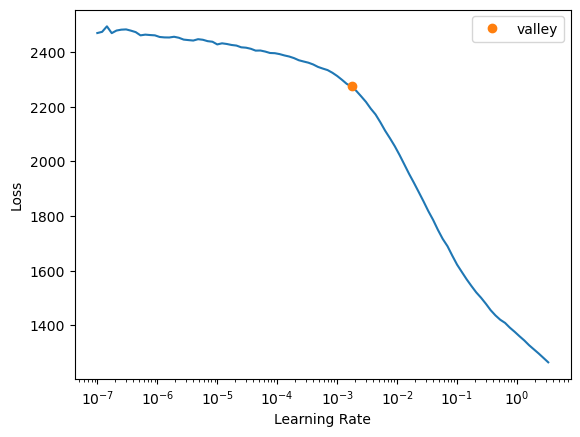

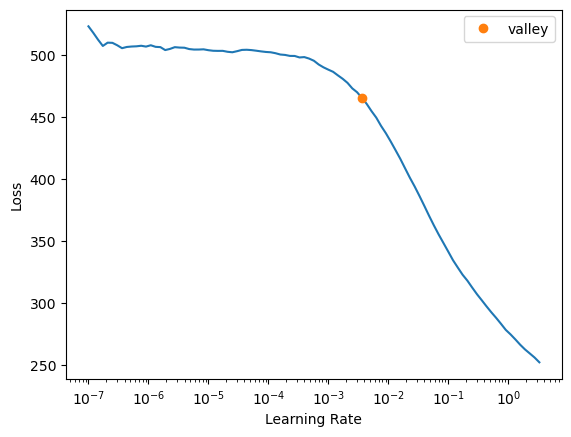

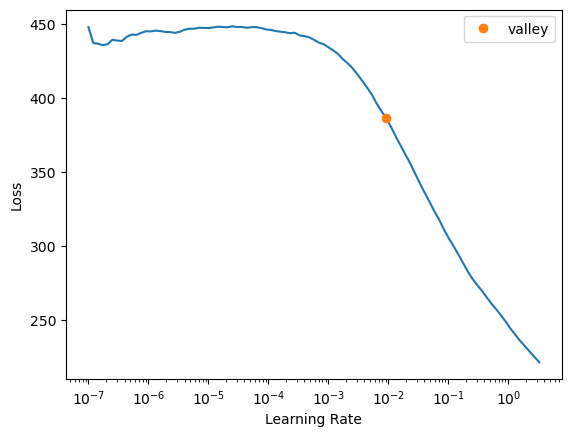

In [70]:
dep_var = "pv_measurement"
cat_names = [
    "estimated",
    "dew_or_rime:idx",
    "precip_type_5min:idx",
]
cont_names = [
    col for col in train_df.columns if col not in cat_names + [dep_var, "location"]
]

procs = [
    tabular_all.Categorify,
    tabular_all.FillMissing,
    tabular_all.Normalize,
]

all_preds = pd.DataFrame(columns=["prediction"])

importances = {"A": None, "B": None, "C": None}

for location in ("A", "B", "C"):
    tabular_all.set_seed(1111)

    temp_train = (
        train_df.copy()[train_df.location == location]
        .drop(
            columns=["location"],
            errors="ignore",
        )
        .reset_index(drop=True)
    )

    val_index = (
        temp_train[temp_train.estimated == 1].sample(frac=0.4, random_state=1111).index
    )

    splits = tabular_all.IndexSplitter(val_index)(temp_train)

    to = tabular_all.TabularPandas(
        temp_train,
        procs=procs,
        cat_names=cat_names,
        cont_names=[
            col
            for col in train_df.columns
            if col not in cat_names + [dep_var, "location"]
        ],
        y_names=dep_var,
        splits=splits,
        y_block=tabular_all.RegressionBlock(),
    )

    dls = to.dataloaders(bs=128, seed=42)

    config = tabular_all.tabular_config(ps=0.2)

    learn = tabular_all.tabular_learner(
        dls,
        metrics=[fastai.losses.L1LossFlat()],
        loss_func=fastai.losses.L1LossFlat(),
        # config=config,
        # layers=[512, 256, 128, 62],
        y_range=(0, train_df[train_df.location == location].pv_measurement.max()),
    )

    lr = learn.lr_find()

    learn.fit_one_cycle(20, lr)


    tst_dl = learn.dls.test_dl(
        test_df[test_df.location == location]
        .copy()
        .drop(
            columns=["location"],
            errors="ignore",
        )
    )
    preds, _ = learn.get_preds(dl=tst_dl)

    all_preds = pd.concat(
        [all_preds, pd.DataFrame(preds.numpy(), columns=["prediction"])]
    )

In [71]:
test_result["neural_net"] = all_preds

# 3 – Postprocessing

In [181]:
# Manually chosen weights
weights = [0.40, 0.20, 0.40]

# Weights calculated using LP Meta Model
weights_2 = np.array([-0.11873, 0.19438, 0.21091, 0.71344])

autogluon_test = np.array(test_result["autogluon"]["pv_measurement"].to_list().copy())
autogluon_test[:720] = autogluon_test[:720] * 0.8 + 0.2 * test_result["autogluon_new"]["pv_measurement"].to_numpy()[:720]
autogluon_test[1440:] = autogluon_test[1440:] * 0.9 + 0.1 * test_result["autogluon_new"]["pv_measurement"].to_numpy()[1440:]


ensamble = (
    + weights[0] * autogluon_test
    + weights[1] * test_result["neural_net"]["prediction"].to_numpy()
    + weights[2]* np.dot(weights_2, (
        test_result["general_lightgbm"].to_numpy(),
        test_result["encoded_catboost"].to_numpy(),
        test_result["transform_catboost"].to_numpy(),
        test_result["location_catboost"].to_numpy(),
    ))
)

ensamble[720:] = ensamble[720:] * 0.7 + 0.3 * test_result["autogluon_new"]["pv_measurement"].to_numpy()[720:]

ensamble = np.array(np.maximum(ensamble, 0))

print("Weights:", weights)
print("Sum:", np.sum(weights))
print("Sum:", np.sum(weights_2))

Weights: [0.4, 0.2, 0.4]
Sum: 1.0
Sum: 1.0


In [144]:
constraint = (
    data_standard[data_standard["data_type"].isin(["observed"]) & data_standard["month"].isin([5, 6, 7])]
    .groupby(["month", "hour", "location"])["pv_measurement"]
    .max()
    .reset_index()
)

In [145]:
kaggle_data = (
    data_standard[data_standard.data_type.isin(["test"])]
    .sort_values(["location", "date_forecast"])
    .copy()
).reset_index(drop=True)

kaggle_data["pv_measurement"] = ensamble
kaggle_data["pv_measurement_post"] = pd.merge(
    kaggle_data, constraint, on=["hour", "month", "location"], how="left"
)["pv_measurement_y"].values
kaggle_data["pv_measurement_post"] = np.where(
    kaggle_data["pv_measurement_post"] < kaggle_data["pv_measurement"],
    kaggle_data["pv_measurement_post"],
    kaggle_data["pv_measurement"],
)
kaggle_data["pv_measurement_post"] = np.where(
    kaggle_data["pv_measurement_post"] < 4, 0, kaggle_data["pv_measurement_post"]
)

In [146]:
np.sum(kaggle_data["pv_measurement"] - kaggle_data["pv_measurement_post"]) / 2160

0.3014354363941535

# 4 – Submission

In [147]:
output_df = pd.DataFrame(
    kaggle_data["pv_measurement_post"].values, columns=["prediction"]
)
output_df = output_df.reset_index(names="id")
output_df.to_csv(
    "../data/results/" + str(datetime.datetime.now()) + "-ensamble.csv", index=False
)